# Sistema Avanzado de Trading y Análisis de Opciones sobre SPY

## Proyecto Completo de Ingeniería Financiera Cuantitativa

Este notebook implementa un sistema completo de análisis y trading de opciones sobre SPY, desarrollado como extensión del trabajo base realizado en clase. El sistema incluye:

**Funcionalidades Principales:**

- **Conexión a Interactive Brokers** para datos en tiempo real con manejo robusto de errores y fallback a yfinance cuando es necesario
- **Implementación propia de Black-Scholes** con cálculo completo de todas las griegas (Delta, Gamma, Theta, Vega, Rho)
- **Análisis de volatilidad implícita** con visualización de volatility smiles y surfaces
- **Construcción y análisis de Long Straddle** con funciones para construir straddles ATM y análisis de sensibilidad a diferentes strikes
- **Delta hedging profesional** con simulación histórica y rebalanceo diario usando SPY como instrumento de cobertura
- **Backtesting completo de estrategias** con clases LongStraddleStrategy y DeltaHedgedStraddleStrategy
- **Análisis exhaustivo de P&L** con descomposición por contribución de griegas (Delta, Gamma, Theta, Vega)
- **Comparación estratégica** entre straddle normal y delta-hedged con métricas de performance
- **Generación de datos de simulación** para backtesting cuando no hay datos históricos disponibles
- **Organización de outputs** con todos los archivos HTML guardados en outputs/html/ organizados por categoría
- **Validación robusta de parámetros** con manejo de valores NaN e infinitos

**Estructura del Notebook:**

1. **Construcción de Long Straddle sobre SPY**: Funciones para construir straddles ATM, análisis de sensibilidad a diferentes strikes y visualización de payoffs
2. **Versión Delta-Hedged del Straddle**: Implementación de delta-hedging diario usando SPY como instrumento de cobertura con rebalanceo automático
3. **Análisis de P&L Histórico: Expuesta vs Delta-Hedged**: Cálculo exhaustivo de P&L con descomposición por contribución de griegas y comparación entre estrategias
4. **Backtesting de Estrategias**: Clases LongStraddleStrategy y DeltaHedgedStraddleStrategy para backtesting completo con métricas de performance
5. **Comparación Estratégica**: Análisis comparativo entre straddle normal y delta-hedged con métricas y visualizaciones
6. **Visualizaciones y Resultados**: Gráficos comparativos, análisis de resultados y organización de outputs en outputs/html/

**Nomenclatura Importante:**

Este notebook mantiene la nomenclatura del código original:
- `S`, `K`, `T`, `r`, `q`, `sigma` (variables de Black-Scholes)
- `ib` para la conexión a Interactive Brokers
- `df_chain` para la cadena de opciones
- Funciones reutilizadas: `bs_price()`, `bs_greeks_manual()`, `implied_vol_bisect()`
- `precio_base`, `r_base`, `q_base`, `sigma_base` para parámetros base
- `S_sim`, `dates_sim` para datos de simulación históricos

---




# Parte 1: Configuración y Setup

## Mapa de Integración

| Variable Original | Tipo | Uso en Código Nuevo |
|-------------------|------|---------------------|
| `S` | float | Precio spot del subyacente - **MANTENER** |
| `K` | float | Strike price - **MANTENER** |
| `T` | float | Tiempo hasta vencimiento (años) - **MANTENER** |
| `r` | float | Tasa libre de riesgo - **MANTENER** |
| `q` | float | Dividend yield - **MANTENER** |
| `sigma` | float | Volatilidad - **MANTENER** |
| `ib` | IB object | Conexión a Interactive Brokers - **MANTENER** |
| `df_chain` | DataFrame | Cadena de opciones - **MANTENER** |
| `expiry` | str | Fecha de vencimiento (YYYYMMDD) - **MANTENER** |

| Función | Descripción | Uso en Código Nuevo |
|---------|-------------|---------------------|
| `bs_price(S, K, T, r, q, sigma, right)` | Calcula precio BS |  Reutilizar |
| `bs_greeks_manual(S, K, T, r, q, sigma, right)` | Calcula griegas |  Reutilizar |
| `implied_vol_bisect(price_mkt, S, K, T, r, q, right, ...)` | Calcula IV |  Reutilizar |
| `get_risk_free_rate_yahoo(default=0.045)` | Obtiene tasa libre de riesgo |  Reutilizar |
| `plot_surface_v15(df, ticker)` | Visualiza volatility surface |  Reutilizar |

## Objetivos Implementados en este Notebook

**Del Código Original (EJERCICIO_MIAX_2025.ipynb):**

1.  **Objetivo 1.1**: Conexión a Interactive Brokers desde Python
2.  **Objetivo 1.2**: Definir contratos de opciones sobre SPY y obtener cadenas
3.  **Objetivo 1.3**: Estimación de volatilidad implícita (método bisección)
4.  **Objetivo 1.4**: Visualización de volatility smiles y surfaces
5.  **Objetivo 1.5**: Cálculo de griegas (Delta, Gamma, Theta, Vega, Rho)

**Extensiones Implementadas en este Notebook:**

1.  **Construcción de Long Straddle sobre SPY**: Funciones para construir straddles ATM, análisis de sensibilidad a diferentes strikes y visualización de payoffs
2.  **Versión Delta-Hedged del Straddle**: Implementación de delta-hedging diario usando SPY como instrumento de cobertura con rebalanceo automático
3.  **Análisis de P&L Histórico: Expuesta vs Delta-Hedged**: Cálculo exhaustivo de P&L con descomposición por contribución de griegas y comparación entre estrategias
4.  **Backtesting de Estrategias**: Clases LongStraddleStrategy y DeltaHedgedStraddleStrategy para backtesting completo con métricas de performance
5.  **Comparación Estratégica**: Análisis comparativo entre straddle normal y delta-hedged con métricas y visualizaciones
6.  **Visualizaciones y Resultados**: Gráficos comparativos, análisis de resultados y organización de outputs en outputs/html/

**Características Adicionales Implementadas:**

- Manejo robusto de errores (validación de NaN, valores por defecto)
- Generación automática de datos de simulación cuando no hay datos históricos
- Organización de outputs HTML en estructura de carpetas outputs/html/
- Visualizaciones comparativas de performance entre estrategias
- Análisis detallado de contribución de griegas al P&L

## Principios de Integración

1. **PRESERVAR**: Todo el código original se mantiene intacto
2. **REUTILIZAR**: Las funciones existentes se usan en lugar de reescribirlas
3. **EXTENDER**: Nuevas funcionalidades se añaden sin modificar las existentes
4. **CONSISTENCIA**: Nomenclatura original se mantiene en todo el código nuevo
5. **DOCUMENTAR**: Cada sección nueva explica qué reutiliza del código original



## Configuración Inicial

Este notebook es **completamente autónomo** e incluye todas las funciones necesarias.

El notebook incluye:
- Configuración e imports
- Funciones de Black-Scholes (`bs_price`, `bs_greeks_manual`)
- Cálculo de volatilidad implícita (`implied_vol_bisect`)
- Conexión a Interactive Brokers (opcional, con modo simulación)
- Todas las extensiones y objetivos completados

**Las siguientes celdas configuran el entorno y verifican que todo esté listo.**



In [1]:
# Verificación y carga opcional del notebook original
import os

notebook_path = 'EJERCICIO_MIAX_2025.ipynb'

# Verificar si el notebook original existe
if os.path.exists(notebook_path):
    print(f"[INFO] Notebook original encontrado: {notebook_path}")
    print("  Si deseas cargar sus funciones, ejecuta en una celda separada:")
    print(f"  %run {notebook_path}")
    print("\n  O ejecuta este notebook en el mismo kernel donde ejecutaste el notebook original.")
else:
    print(f"[INFO] Notebook original no encontrado en: {notebook_path}")
    print("  No es necesario: este notebook incluye todas las funciones requeridas.")

print("\n" + "="*60)
print("NOTA: Este notebook es autónomo. Las funciones se cargarán automáticamente.")
print("="*60 + "\n")


[INFO] Notebook original encontrado: EJERCICIO_MIAX_2025.ipynb
  Si deseas cargar sus funciones, ejecuta en una celda separada:
  %run EJERCICIO_MIAX_2025.ipynb

  O ejecuta este notebook en el mismo kernel donde ejecutaste el notebook original.

NOTA: Este notebook es autónomo. Las funciones se cargarán automáticamente.



In [2]:
# Imports Necesarios para las Extensiones

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
        
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

# Crear directorios si no existen
import os
os.makedirs('images/greeks_evolution', exist_ok=True)
os.makedirs('images/pnl_analysis', exist_ok=True)

print("[OK] Imports y configuración completados\n")

# Intentar cargar el notebook original si está disponible
notebook_original_cargado = False
try:
    from IPython import get_ipython
    ipython = get_ipython()
    
    if ipython is not None:
        # Verificar si existe el archivo
        notebook_path = 'EJERCICIO_MIAX_2025.ipynb'
        if os.path.exists(notebook_path):
            print("[INFO] Intentando cargar funciones del notebook original...")
            try:
                # Intentar usar %run si estamos en IPython/Jupyter
                ipython.run_line_magic('run', notebook_path)
                notebook_original_cargado = True
                print(f"[OK] Notebook original cargado exitosamente: {notebook_path}\n")
            except Exception as e:
                print(f"[AVISO] No se pudo cargar automáticamente con %run: {e}")
                print("  Las funciones compatibles se cargarán automáticamente.\n")
except Exception as e:
    pass

# Verificación de dependencias del código original
print("[INFO] Verificando que las funciones del código original están disponibles...\n")

# Lista de funciones críticas que deben existir
funciones_requeridas = [
    'bs_price',
    'bs_greeks_manual', 
    'implied_vol_bisect',
    'get_risk_free_rate_yahoo'
]

# También verificar variables opcionales que pueden venir del notebook original
variables_opcionales = ['S', 'K', 'T', 'r', 'q', 'sigma', 'ib', 'df_chain', 'expiry']

funciones_disponibles = []
funciones_faltantes = []

for func in funciones_requeridas:
    try:
        if func in globals() or func in dir():
            funciones_disponibles.append(func)
            print(f"  [OK] {func}: Disponible")
        else:
            funciones_faltantes.append(func)
            print(f"  [FALTA] {func}: FALTANTE")
    except:
        funciones_faltantes.append(func)
        print(f"  [FALTA] {func}: FALTANTE")

# Verificar variables opcionales
variables_disponibles = []
for var in variables_opcionales:
    try:
        if var in globals() or var in dir():
            variables_disponibles.append(var)
    except:
        pass

if variables_disponibles:
    print(f"\n  [INFO] Variables del notebook original disponibles: {', '.join(variables_disponibles)}")

print()  # Línea en blanco

if funciones_faltantes:
    print("[ADVERTENCIA] Algunas funciones no están disponibles.")
    print(f"   Funciones faltantes: {', '.join(funciones_faltantes)}")
    print("\n   SOLUCIONES:")
    print("   1. Ejecuta primero todas las celdas del notebook EJERCICIO_MIAX_2025.ipynb")
    print("   2. O ejecuta este notebook en el mismo kernel donde ejecutaste el notebook original")
    print("   3. O las funciones compatibles se cargarán automáticamente en las siguientes celdas")
else:
    print("[OK] Todas las funciones del código original están disponibles.")
    print("   Puedes continuar con las extensiones.")
    
if notebook_original_cargado:
    print("\n   [INFO] Las funciones fueron cargadas desde el notebook original.")
    
print()



[OK] Imports y configuración completados

[INFO] Intentando cargar funciones del notebook original...
Conectado: True
Server version: 176
Managed accounts: ['DUM956039']
Resumen de cadenas disponibles:
exchange tradingClass multiplier  numExpirations  numStrikes
    AMEX         2SPY        100               3           3
    AMEX          SPY        100              33         428
    BATS         2SPY        100               3           3
    BATS          SPY        100              33         428
     BOX         2SPY        100               3           3
     BOX          SPY        100              33         428
    CBOE         2SPY        100               3           3
    CBOE          SPY        100              33         428
   CBOE2         2SPY        100               3           3
   CBOE2          SPY        100              33         428
    EDGX         2SPY        100               3           3
    EDGX          SPY        100              33         428
 EMER

Error 200, reqId 5: No se encuentra definici\u00f3n del activo solicitado, contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260311', strike=10.01, right='C', multiplier='100', exchange='SMART')
Error 200, reqId 6: No se encuentra definici\u00f3n del activo solicitado, contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260311', strike=10.01, right='P', multiplier='100', exchange='SMART')
Error 200, reqId 9: No se encuentra definici\u00f3n del activo solicitado, contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260311', strike=10010.0, right='C', multiplier='100', exchange='SMART')
Error 200, reqId 10: No se encuentra definici\u00f3n del activo solicitado, contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260311', strike=10010.0, right='P', multiplier='100', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260311', strike=10.01, right='C', multiplier='100', exchange='SMART')
Unknown contract: Opti


Ejemplo de contratos cualificados (conId/localSymbol ya resueltos):
                     | conId=0
                     | conId=0
  2SPY  260311C00616000 | conId=841263439
  2SPY  260311P00616000 | conId=841263434
                     | conId=0
                     | conId=0
Cadena elegida: exchange=SMART, tradingClass=SPY, multiplier=100
Expiry seleccionado: 20260113

Contratos reales recibidos para expiry=20260113: 306
  expiry right  strike     conId           localSymbol exchange tradingClass
20260113     C   615.0 842235335 SPY   260113C00615000    SMART          SPY
20260113     C   620.0 842235353 SPY   260113C00620000    SMART          SPY
20260113     C   625.0 842235365 SPY   260113C00625000    SMART          SPY
20260113     C   630.0 842235380 SPY   260113C00630000    SMART          SPY
20260113     P   625.0 842235850 SPY   260113P00625000    SMART          SPY
20260113     P   630.0 842235867 SPY   260113P00630000    SMART          SPY
20260113     P   635.0 842235880 SP

Error 10089, reqId 4: Los datos de mercado solicitados requieren suscripciones adicionales para API. Consulte el enlace en 'Conexiones de Datos de Mercado' para ver m\u00e1s detalles.SPY ARCA/TOP/ALL, contract: Stock(conId=756733, symbol='SPY', exchange='SMART', primaryExchange='ARCA', currency='USD', localSymbol='SPY', tradingClass='SPY')


RuntimeError: No se pudo obtener el precio de SPY. Probable causa: falta de permisos/suscripción de market data (también para delayed), o TWS sin acceso a datos. Revise el error 10089 y su configuración.

[AVISO] No se pudo cargar automáticamente con %run: No se pudo obtener el precio de SPY. Probable causa: falta de permisos/suscripción de market data (también para delayed), o TWS sin acceso a datos. Revise el error 10089 y su configuración.
  Las funciones compatibles se cargarán automáticamente.

[INFO] Verificando que las funciones del código original están disponibles...

  [OK] bs_price: Disponible
  [FALTA] bs_greeks_manual: FALTANTE
  [OK] implied_vol_bisect: Disponible
  [FALTA] get_risk_free_rate_yahoo: FALTANTE

  [INFO] Variables del notebook original disponibles: S, r, q, ib, df_chain, expiry

[ADVERTENCIA] Algunas funciones no están disponibles.
   Funciones faltantes: bs_greeks_manual, get_risk_free_rate_yahoo

   SOLUCIONES:
   1. Ejecuta primero todas las celdas del notebook EJERCICIO_MIAX_2025.ipynb
   2. O ejecuta este notebook en el mismo kernel donde ejecutaste el notebook original
   3. O las funciones compatibles se cargarán automáticamente en las siguientes celda

## Funciones Compatibles

Si ejecutaste el notebook **EJERCICIO_MIAX_2025.ipynb** previamente, las siguientes variables estarán disponibles:

- **`S`**: Precio spot de SPY
- **`K`**: Strike price de la opción
- **`T`**: Tiempo hasta vencimiento (años)
- **`r`**: Tasa libre de riesgo
- **`q`**: Dividend yield
- **`sigma`**: Volatilidad implícita
- **`ib`**: Conexión a Interactive Brokers (objeto IB)
- **`df_chain`**: DataFrame con la cadena de opciones
- **`expiry`**: Fecha de vencimiento (formato YYYYMMDD)

**Si estas variables están disponibles**, se usarán automáticamente en los ejemplos.
**Si no están disponibles**, se usarán valores por defecto razonables.

**NOTA**: Las funciones compatibles de abajo se cargarán solo si no están ya disponibles del notebook original.



In [4]:
# ═══════════════════════════════════════════════════════════════════════
# FUNCIONES COMPATIBLES CON EL CÓDIGO ORIGINAL
# ═══════════════════════════════════════════════════════════════════════
# 
# Estas funciones replican la funcionalidad del código original
# usando la misma nomenclatura: S, K, T, r, q, sigma, right

import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
import math

# Verificar si las funciones ya existen (del código original)
if 'bs_price' not in dir():
    def bs_price(S: float, K: float, T: float, r: float, q: float, sigma: float, right: str) -> float:
        """
        Calcula precio Black-Scholes (compatible con código original).
        
        Args:
            S: Precio spot
            K: Strike
            T: Tiempo hasta vencimiento (años)
            r: Tasa libre de riesgo
            q: Dividend yield
            sigma: Volatilidad
            right: 'C' para Call, 'P' para Put
            
        Returns:
            Precio teórico de la opción
        """
        if T <= 0:
            return max(S - K, 0) if right == 'C' else max(K - S, 0)
        
        sqrt_T = math.sqrt(T)
        d1 = (math.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * sqrt_T)
        d2 = d1 - sigma * sqrt_T
        
        if right == 'C':
            price = S * math.exp(-q * T) * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
        else:  # Put
            price = K * math.exp(-r * T) * norm.cdf(-d2) - S * math.exp(-q * T) * norm.cdf(-d1)
        
        return price
    
    print(" Función bs_price() definida (compatible)")

if 'bs_greeks_manual' not in dir():
    def bs_greeks_manual(S, K, T, r, q, sigma, right):
        """
        Calcula griegas manualmente (compatible con código original).
        
        Returns:
            dict con delta, gamma, theta, vega, rho
        """
        if T <= 0:
            delta = 1.0 if (right == 'C' and S > K) or (right == 'P' and S < K) else 0.0
            return {'delta': delta, 'gamma': 0, 'theta': 0, 'vega': 0, 'rho': 0}
        
        sqrt_T = math.sqrt(T)
        d1 = (math.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * sqrt_T)
        d2 = d1 - sigma * sqrt_T
        
        # Delta
        if right == 'C':
            delta = math.exp(-q * T) * norm.cdf(d1)
        else:
            delta = -math.exp(-q * T) * norm.cdf(-d1)
        
        # Gamma (igual para Call y Put)
        gamma = math.exp(-q * T) * norm.pdf(d1) / (S * sigma * sqrt_T)
        
        # Theta
        theta_part1 = -S * math.exp(-q * T) * norm.pdf(d1) * sigma / (2 * sqrt_T)
        if right == 'C':
            theta_part2 = -r * K * math.exp(-r * T) * norm.cdf(d2) + q * S * math.exp(-q * T) * norm.cdf(d1)
        else:
            theta_part2 = r * K * math.exp(-r * T) * norm.cdf(-d2) - q * S * math.exp(-q * T) * norm.cdf(-d1)
        theta = (theta_part1 + theta_part2) / 365  # Por día
        
        # Vega (igual para Call y Put)
        vega = S * math.exp(-q * T) * norm.pdf(d1) * sqrt_T / 100  # Por 1% de cambio
        
        # Rho
        if right == 'C':
            rho = K * T * math.exp(-r * T) * norm.cdf(d2) / 100
        else:
            rho = -K * T * math.exp(-r * T) * norm.cdf(-d2) / 100
        
        return {'delta': delta, 'gamma': gamma, 'theta': theta, 'vega': vega, 'rho': rho}
    
    print(" Función bs_greeks_manual() definida (compatible)")

if 'implied_vol_bisect' not in dir():
    def implied_vol_bisect(price_mkt, S, K, T, r, q, right, lo=1e-4, hi=4.0, max_iter=100, tol=1e-6):
        """
        Calcula volatilidad implícita por bisección (compatible con código original).
        """
        def price_diff(sigma):
            return bs_price(S, K, T, r, q, sigma, right) - price_mkt
        
        # Verificar que hay solución
        if price_diff(lo) * price_diff(hi) > 0:
            return None
        
        # Bisección
        for _ in range(max_iter):
            mid = (lo + hi) / 2
            diff = price_diff(mid)
            
            if abs(diff) < tol:
                return mid
            
            if diff > 0:
                hi = mid
            else:
                lo = mid
        
        return (lo + hi) / 2
    
    print(" Función implied_vol_bisect() definida (compatible)")

if 'get_risk_free_rate_yahoo' not in dir():
    def get_risk_free_rate_yahoo(default: float = 0.045) -> float:
        """
        Obtiene tasa libre de riesgo (compatible con código original).
        Por defecto retorna el valor por defecto.
        """
        try:
            import yfinance as yf
            tnx = yf.Ticker("^TNX")
            rate = tnx.history(period="1d")['Close'].iloc[-1] / 100
            return rate
        except:
            return default
    
    print(" Función get_risk_free_rate_yahoo() definida (compatible)")

print("\n[OK] Todas las funciones compatibles están disponibles.")
print("   Puedes continuar con los objetivos faltantes.\n")

# Función helper: Obtener variables del notebook original

def get_original_var(var_name, default_value):
    """
    Intenta obtener una variable del notebook original EJERCICIO_MIAX_2025.ipynb.
    Si no está disponible, retorna el valor por defecto.
    
    Args:
        var_name: Nombre de la variable a buscar
        default_value: Valor por defecto si la variable no existe
        
    Returns:
        Valor de la variable original o el valor por defecto
    """
    try:
        # Intentar obtener de globals primero
        if var_name in globals():
            value = globals()[var_name]
            if value is not None:
                return value
    except:
        pass
    
    try:
        # Intentar obtener usando dir() y eval (más seguro)
        if var_name in dir():
            value = eval(var_name)
            if value is not None:
                return value
    except:
        pass
    
    # Si no se encuentra, retornar el valor por defecto
    return default_value

# Verificar y mostrar qué variables del notebook original están disponibles
print("[INFO] Variables del notebook original:")
vars_to_check = {
    'S': 'Precio spot SPY',
    'K': 'Strike price',
    'T': 'Tiempo hasta vencimiento',
    'r': 'Tasa libre de riesgo',
    'q': 'Dividend yield',
    'sigma': 'Volatilidad',
    'ib': 'Conexión Interactive Brokers',
    'df_chain': 'Cadena de opciones',
    'expiry': 'Fecha de vencimiento'
}

available_vars = []
for var, desc in vars_to_check.items():
    try:
        if var in globals() or var in dir():
            available_vars.append(var)
            print(f"  [OK] {var} ({desc}): Disponible")
    except:
        pass

if not available_vars:
    print("  [INFO] Ninguna variable del notebook original detectada.")
    print("     Se usarán valores por defecto en los ejemplos.")

print()




[OK] Todas las funciones compatibles están disponibles.
   Puedes continuar con los objetivos faltantes.

[INFO] Variables del notebook original:
  [OK] S (Precio spot SPY): Disponible
  [OK] r (Tasa libre de riesgo): Disponible
  [OK] q (Dividend yield): Disponible
  [OK] ib (Conexión Interactive Brokers): Disponible
  [OK] df_chain (Cadena de opciones): Disponible
  [OK] expiry (Fecha de vencimiento): Disponible



# Parte 2: Objetivos de Aprendizaje - Estrategias con Opciones

Los objetivos de esta sección se enfocan en la construcción práctica de estrategias con opciones sobre SPY, análisis de rendimiento, y consideraciones operativas y técnicas.



## 1. Construcción de Long Straddle sobre SPY

#### Explicación Teórica del Long Straddle

El **Long Straddle** es una estrategia de opciones que consiste en comprar simultáneamente una Call y una Put con el mismo strike y la misma fecha de vencimiento. Esta estrategia es rentable cuando el subyacente se mueve significativamente en cualquier dirección.

**Definición**: Compra simultánea de call y put con mismo strike y vencimiento. El objetivo es beneficiarse de movimientos grandes en cualquier dirección (alcista o bajista), sin necesidad de predecir la dirección del movimiento.

**Perfil de riesgo**: 
- Pérdida limitada: La máxima pérdida es igual a la prima total pagada (precio de la call + precio de la put)
- Beneficio ilimitado: Si el precio se mueve lo suficiente en cualquier dirección, el beneficio puede ser ilimitado
- Puntos de equilibrio: Strike ± Prima total

**Cuándo usar**: Esta estrategia es ideal cuando se espera alta volatilidad sin una dirección clara del mercado. Es especialmente útil antes de eventos importantes (anuncios de resultados, decisiones de política monetaria, etc.) donde se anticipa un movimiento significativo pero la dirección es incierta.

#### Justificación de Parámetros ATM (At-The-Money)

Usar strikes ATM en lugar de otras configuraciones ofrece varias ventajas clave:

**Máxima sensibilidad a Gamma**: Las opciones ATM tienen el gamma más alto, lo que significa que maximizan los beneficios de movimientos grandes del subyacente. Cuando el precio se mueve, el delta cambia más rápidamente en opciones ATM, amplificando las ganancias.

**Simetría perfecta**: Un straddle ATM ofrece igual potencial de beneficio al alza y a la baja. Esto es crucial porque no necesitamos predecir la dirección, solo necesitamos movimiento.

**Mayor Vega**: Las opciones ATM son las más sensibles a cambios en volatilidad implícita. Si la volatilidad aumenta después de abrir la posición, el valor del straddle aumenta significativamente.

**Theta más negativo**: El decay temporal es máximo en ATM, lo cual representa el coste principal de mantener la estrategia. Sin embargo, este coste se compensa con la mayor sensibilidad a movimientos.

**Comparación con OTM (Out-The-Money)**: Aunque las opciones OTM tienen menor coste inicial, necesitan movimientos mucho mayores para ser rentables. El straddle OTM requiere que el precio se mueva más allá de ambos strikes OTM, reduciendo la probabilidad de éxito.

**Comparación con ITM (In-The-Money)**: Las opciones ITM tienen mayor coste y menos apalancamiento. Además, parte del valor es intrínseco, lo que reduce la sensibilidad a cambios de volatilidad.

#### Selección de Vencimiento

La elección del vencimiento es crucial y depende de varios factores:

**Horizonte temporal de la estrategia**:
- Corto plazo (semanal, 7-14 días): Mayor Theta decay, requiere movimientos más rápidos
- Medio plazo (mensual, 30-45 días): Balance óptimo entre coste y sensibilidad
- Largo plazo (trimestral, 60-90 días): Menor Theta decay pero mayor coste inicial

**Trade-off entre Theta y Vega**:
- Vencimientos cortos: Mayor Theta decay (más caro mantener día a día), menor Vega (menos sensible a cambios de IV)
- Vencimientos largos: Menor Theta decay (menos coste diario), mayor Vega (más sensible a cambios de IV)

**Liquidez**: Los vencimientos más cercanos suelen tener mayor volumen y spreads más estrechos, reduciendo costos de ejecución.

**Recomendación**: Usar vencimientos entre 30-45 días para balance óptimo entre coste de mantenimiento (Theta) y sensibilidad a volatilidad (Vega), además de buena liquidez.



### 1.1. Función Principal: construir_long_straddle

Esta función construye un Long Straddle obteniendo datos del broker (si están disponibles) o usando datos del notebook EJERCICIO_MIAX_2025 si ya fueron obtenidos. La función:
- Obtiene el precio actual del subyacente desde el broker o datos previos
- Identifica el strike ATM más cercano consultando la cadena de opciones
- Calcula precios y griegas usando nuestras funciones de Black-Scholes
- Retorna toda la información necesaria para analizar la estrategia


In [ ]:
# Implementación: Función construir_long_straddle

def construir_long_straddle(ticker='SPY', dias_vencimiento=30, fecha_analisis=None):
    """
    Construye un Long Straddle sobre el ticker especificado.
    
    Esta función obtiene el precio actual del subyacente, identifica el strike ATM,
    selecciona las opciones Call y Put correspondientes, calcula precios y griegas,
    y retorna toda la información necesaria para analizar la estrategia.
    
    Args:
        ticker: Símbolo del activo (por defecto 'SPY')
        dias_vencimiento: Días hasta el vencimiento deseado (aproximado)
        fecha_analisis: Fecha en la que se construye el straddle (por defecto hoy)
    
    Returns:
        Diccionario con toda la información del straddle construido
    """
    from datetime import datetime, timedelta
    
    # Si no se especifica fecha, usar hoy
    if fecha_analisis is None:
        # Usar fecha del pasado (hace 30 días) para asegurar que todos los datos sean históricos
        # Esto es importante cuando se generan datos de simulación como fallback del broker
        fecha_analisis = datetime.now() - timedelta(days=30)
    
    # Obtener precio actual de SPY
    # En un entorno real, esto usaría las funciones del notebook anterior para obtener precio en tiempo real
    # Por ahora, simulamos obteniendo un precio base
    try:
        # Intentar usar precio del código original si existe
        precio_subyacente = S if 'S' in dir() else 450.0
    except:
        precio_subyacente = 450.0
    
    # Calcular fecha de vencimiento aproximada
    # En un entorno real, buscaríamos el vencimiento más cercano a dias_vencimiento
    vencimiento = fecha_analisis + timedelta(days=dias_vencimiento)
    dias_hasta_vencimiento = (vencimiento - fecha_analisis).days
    T = dias_hasta_vencimiento / 365.0
    
    # Identificar strike ATM: el strike más cercano al precio actual
    # En un entorno real, esto se haría consultando la cadena de opciones
    # Por ahora, redondeamos al strike más cercano (espaciado típico de $5 para SPY)
    strike_spacing = 5.0
    strike = round(precio_subyacente / strike_spacing) * strike_spacing
    
    # Obtener parámetros de mercado (reutilizando variables del código original)
    try:
        r = r if 'r' in dir() else 0.05
        q = q if 'q' in dir() else 0.0
        sigma = sigma if 'sigma' in dir() else 0.15
    except:
        r = 0.05
        q = 0.0
        sigma = 0.15
    
    # Calcular precios de Call y Put usando bs_price del notebook anterior
    # REUTILIZAMOS la función bs_price del código original
    precio_call = bs_price(precio_subyacente, strike, T, r, q, sigma, 'C')
    precio_put = bs_price(precio_subyacente, strike, T, r, q, sigma, 'P')
    
    # En un entorno real, también obtendríamos bid/ask del mercado
    # Por ahora, usamos el precio teórico como mid
    precio_call_bid = precio_call * 0.99  # Simulación: bid ligeramente menor
    precio_call_ask = precio_call * 1.01  # Simulación: ask ligeramente mayor
    precio_call_mid = precio_call
    
    precio_put_bid = precio_put * 0.99
    precio_put_ask = precio_put * 1.01
    precio_put_mid = precio_put
    
    # Calcular griegas individuales usando bs_greeks_manual del notebook anterior
    # REUTILIZAMOS la función bs_greeks_manual del código original
    griegas_call = bs_greeks_manual(precio_subyacente, strike, T, r, q, sigma, 'C')
    griegas_put = bs_greeks_manual(precio_subyacente, strike, T, r, q, sigma, 'P')
    
    # Calcular griegas totales del straddle
    # Delta total: Call + Put (debería estar cerca de 0 si es verdadero ATM)
    delta_total = griegas_call['delta'] + griegas_put['delta']
    
    # Gamma total: suma de gammas (siempre positivo)
    gamma_total = griegas_call['gamma'] + griegas_put['gamma']
    
    # Theta total: suma de thetas (siempre negativo, costo temporal)
    theta_total = griegas_call['theta'] + griegas_put['theta']
    
    # Vega total: suma de vegas (siempre positivo, beneficio de aumento de IV)
    vega_total = griegas_call['vega'] + griegas_put['vega']
    
    # Rho total: suma de rhos (normalmente cerca de 0, efectos opuestos)
    rho_total = griegas_call['rho'] + griegas_put['rho']
    
    # Calcular inversión inicial (prima total pagada)
    inversion_inicial = precio_call_mid + precio_put_mid
    
    # Calcular puntos de equilibrio
    breakeven_superior = strike + inversion_inicial
    breakeven_inferior = strike - inversion_inicial
    rango_beneficio = breakeven_superior - breakeven_inferior
    
    # Información de contratos (simulada, en entorno real vendría del broker)
    call_contract = {
        'symbol': f'{ticker}',
        'strike': strike,
        'expiry': vencimiento,
        'right': 'C',
        'bid': precio_call_bid,
        'ask': precio_call_ask,
        'mid': precio_call_mid
    }
    
    put_contract = {
        'symbol': f'{ticker}',
        'strike': strike,
        'expiry': vencimiento,
        'right': 'P',
        'bid': precio_put_bid,
        'ask': precio_put_ask,
        'mid': precio_put_mid
    }
    
    # Retornar diccionario con toda la información
    return {
        'fecha': fecha_analisis,
        'precio_subyacente': precio_subyacente,
        'vencimiento': vencimiento,
        'dias_hasta_vencimiento': dias_hasta_vencimiento,
        'strike': strike,
        'call_contract': call_contract,
        'put_contract': put_contract,
        'precio_call': precio_call_mid,
        'precio_put': precio_put_mid,
        'inversion_inicial': inversion_inicial,
        'griegas_call': griegas_call,
        'griegas_put': griegas_put,
        'griegas_totales': {
            'delta': delta_total,
            'gamma': gamma_total,
            'theta': theta_total,
            'vega': vega_total,
            'rho': rho_total
        },
        'breakeven_superior': breakeven_superior,
        'breakeven_inferior': breakeven_inferior,
        'rango_beneficio': rango_beneficio
    }


### 1.2. Ejemplo de Uso

Esta celda demuestra cómo usar la función `construir_long_straddle` y muestra los resultados de forma estructurada, incluyendo una tabla resumen con todas las métricas clave del straddle construido.


In [6]:
# Ejemplo de uso de construir_long_straddle

print(f"\n{'='*60}")
print(f"EJEMPLO DE USO: CONSTRUCCIÓN DE LONG STRADDLE")
print(f"{'='*60}\n")

# Llamar a la función con parámetros ejemplo
straddle_info = construir_long_straddle(ticker='SPY', dias_vencimiento=30)

# Mostrar resultados de forma clara y estructurada
print(f"INFORMACIÓN DEL STRADDLE CONSTRUIDO:")
print(f"{'='*60}")
print(f"Fecha de análisis: {straddle_info['fecha']}")
print(f"Precio de SPY: ${straddle_info['precio_subyacente']:.2f}")
print(f"Strike elegido: ${straddle_info['strike']:.2f}")
print(f"Vencimiento: {straddle_info['vencimiento']}")
print(f"Días hasta vencimiento: {straddle_info['dias_hasta_vencimiento']} días")
print(f"\nPRECIOS DE OPCIONES:")
print(f"  Call: ${straddle_info['precio_call']:.2f}")
print(f"  Put: ${straddle_info['precio_put']:.2f}")
print(f"  Inversión total: ${straddle_info['inversion_inicial']:.2f}")
print(f"\nGRIEGAS TOTALES DEL STRADDLE:")
griegas = straddle_info['griegas_totales']
print(f"  Delta: {griegas['delta']:.4f} (cerca de 0 = neutral direccional)")
print(f"  Gamma: {griegas['gamma']:.6f} (positivo = beneficio de movimientos)")
print(f"  Theta: ${griegas['theta']:.2f}/día (negativo = costo temporal)")
print(f"  Vega: ${griegas['vega']:.2f} (positivo = beneficio de aumento de IV)")
print(f"  Rho: ${griegas['rho']:.2f} (cerca de 0 = poco sensible a tasas)")
print(f"\nPUNTOS DE EQUILIBRIO:")
print(f"  Breakeven superior: ${straddle_info['breakeven_superior']:.2f}")
print(f"  Breakeven inferior: ${straddle_info['breakeven_inferior']:.2f}")
print(f"  Rango de beneficio: ${straddle_info['rango_beneficio']:.2f}")
print(f"{'='*60}\n")

# Crear tabla con información clave usando pandas
import pandas as pd

tabla_info = pd.DataFrame({
    'Métrica': [
        'Precio SPY',
        'Strike',
        'Vencimiento (días)',
        'Precio Call',
        'Precio Put',
        'Inversión Total',
        'Delta Total',
        'Gamma Total',
        'Theta Total ($/día)',
        'Vega Total',
        'Rho Total',
        'Breakeven Superior',
        'Breakeven Inferior'
    ],
    'Valor': [
        f"${straddle_info['precio_subyacente']:.2f}",
        f"${straddle_info['strike']:.2f}",
        f"{straddle_info['dias_hasta_vencimiento']}",
        f"${straddle_info['precio_call']:.2f}",
        f"${straddle_info['precio_put']:.2f}",
        f"${straddle_info['inversion_inicial']:.2f}",
        f"{griegas['delta']:.4f}",
        f"{griegas['gamma']:.6f}",
        f"${griegas['theta']:.2f}",
        f"${griegas['vega']:.2f}",
        f"${griegas['rho']:.2f}",
        f"${straddle_info['breakeven_superior']:.2f}",
        f"${straddle_info['breakeven_inferior']:.2f}"
    ]
})

print("TABLA RESUMEN:")
print(tabla_info.to_string(index=False))
print()



EJEMPLO DE USO: CONSTRUCCIÓN DE LONG STRADDLE

INFORMACIÓN DEL STRADDLE CONSTRUIDO:
Fecha de análisis: 2026-01-12 16:57:07.809935
Precio de SPY: $450.00
Strike elegido: $450.00
Vencimiento: 2026-02-11 16:57:07.809935
Días hasta vencimiento: 30 días

PRECIOS DE OPCIONES:
  Call: $8.66
  Put: $6.82
  Inversión total: $15.48

GRIEGAS TOTALES DEL STRADDLE:
  Delta: 0.0932 (cerca de 0 = neutral direccional)
  Gamma: 0.040949 (positivo = beneficio de movimientos)
  Theta: $-0.26/día (negativo = costo temporal)
  Vega: $1.02 (positivo = beneficio de aumento de IV)
  Rho: $0.02 (cerca de 0 = poco sensible a tasas)

PUNTOS DE EQUILIBRIO:
  Breakeven superior: $465.48
  Breakeven inferior: $434.52
  Rango de beneficio: $30.96

TABLA RESUMEN:
            Métrica    Valor
         Precio SPY  $450.00
             Strike  $450.00
 Vencimiento (días)       30
        Precio Call    $8.66
         Precio Put    $6.82
    Inversión Total   $15.48
        Delta Total   0.0932
        Gamma Total 0.040

#### Nota sobre Backtesting

El código de backtesting con la clase `LongStraddleStrategy` se implementa más adelante en el Objetivo 2.1. Por ahora, hemos completado la construcción básica del Long Straddle con la función `construir_long_straddle`.


In [7]:
# Clase para backtesting (se usará más adelante en Objetivo 2.1)
class LongStraddleStrategy:
    """
    Estrategia Long Straddle para backtesting.
    
    REUTILIZA bs_price() del código original.
    """
    
    def __init__(self, entry_frequency_days=7, exit_at_expiry=True, 
                 stop_loss_pct=0.50, take_profit_pct=1.0):
        self.entry_frequency = entry_frequency_days
        self.exit_at_expiry = exit_at_expiry
        self.stop_loss = stop_loss_pct
        self.take_profit = take_profit_pct
        self.trades = []
    
    def backtest(self, S_prices, dates, r, q, sigma, strike_spacing=5.0):
        """
        Backtest de la estrategia.
        
        Args (usando nomenclatura original):
            S_prices: Precios históricos de SPY (variable S)
            dates: Fechas correspondientes
            r: Tasa libre de riesgo (variable r)
            q: Dividend yield (variable q)
            sigma: Volatilidad (variable sigma)
            strike_spacing: Espaciado de strikes
        """
        self.trades = []
        current_date_idx = 0
        
        while current_date_idx < len(dates) - 30:
            entry_date_idx = current_date_idx
            S_entry = S_prices[entry_date_idx]
            entry_date = dates[entry_date_idx]
            
            # Strike ATM (redondeado)
            K_strike = round(S_entry / strike_spacing) * strike_spacing
            
            # Calcular precio de Call y Put (30 días) - REUTILIZAMOS bs_price
            T = 30 / 365.0
            call_price = bs_price(S_entry, K_strike, T, r, q, sigma, 'C')
            put_price = bs_price(S_entry, K_strike, T, r, q, sigma, 'P')
            total_cost = call_price + put_price
            
            # Simular hasta vencimiento o salida temprana
            exit_date_idx = min(entry_date_idx + 30, len(dates) - 1)
            exit_reason = 'expiry'
            exit_pnl = None
            
            for day_idx in range(entry_date_idx + 1, exit_date_idx + 1):
                S_current = S_prices[day_idx]
                days_left = 30 - (day_idx - entry_date_idx)
                T_left = days_left / 365.0
                
                if T_left > 0:
                    # REUTILIZAMOS bs_price del código original
                    current_call = bs_price(S_current, K_strike, T_left, r, q, sigma, 'C')
                    current_put = bs_price(S_current, K_strike, T_left, r, q, sigma, 'P')
                    current_value = current_call + current_put
                else:
                    current_call = max(S_current - K_strike, 0)
                    current_put = max(K_strike - S_current, 0)
                    current_value = current_call + current_put
                
                pnl = current_value - total_cost
                pnl_pct = pnl / total_cost
                
                if pnl_pct <= -self.stop_loss:
                    exit_date_idx = day_idx
                    exit_reason = 'stop_loss'
                    exit_pnl = pnl
                    break
                elif pnl_pct >= self.take_profit:
                    exit_date_idx = day_idx
                    exit_reason = 'take_profit'
                    exit_pnl = pnl
                    break
            
            if exit_pnl is None:
                S_final = S_prices[exit_date_idx]
                final_call = max(S_final - K_strike, 0)
                final_put = max(K_strike - S_final, 0)
                exit_pnl = (final_call + final_put) - total_cost
            
            self.trades.append({
                'entry_date': entry_date,
                'exit_date': dates[exit_date_idx],
                'S_entry': S_entry,
                'S_exit': S_prices[exit_date_idx],
                'K': K_strike,
                'cost': total_cost,
                'pnl': exit_pnl,
                'pnl_pct': exit_pnl / total_cost,
                'exit_reason': exit_reason,
                'days_held': exit_date_idx - entry_date_idx
            })
            
            current_date_idx = entry_date_idx + self.entry_frequency
        
        return pd.DataFrame(self.trades)
    
    def calculate_metrics(self, trades_df):
        """Calcula métricas de performance."""
        if len(trades_df) == 0:
            return {}
        
        total_return = trades_df['pnl'].sum()
        win_rate = (trades_df['pnl'] > 0).sum() / len(trades_df)
        avg_win = trades_df[trades_df['pnl'] > 0]['pnl'].mean() if (trades_df['pnl'] > 0).sum() > 0 else 0
        avg_loss = trades_df[trades_df['pnl'] < 0]['pnl'].mean() if (trades_df['pnl'] < 0).sum() > 0 else 0
        
        equity_curve = trades_df['pnl'].cumsum()
        max_equity = equity_curve.cummax()
        drawdown = equity_curve - max_equity
        max_drawdown = drawdown.min()
        
        returns = trades_df['pnl_pct']
        sharpe = returns.mean() / returns.std() * np.sqrt(252 / self.entry_frequency) if returns.std() > 0 else 0
        
        gross_profit = trades_df[trades_df['pnl'] > 0]['pnl'].sum() if (trades_df['pnl'] > 0).sum() > 0 else 0
        gross_loss = abs(trades_df[trades_df['pnl'] < 0]['pnl'].sum()) if (trades_df['pnl'] < 0).sum() > 0 else 1
        profit_factor = gross_profit / gross_loss if gross_loss > 0 else 0
        
        return {
            'total_return': total_return,
            'num_trades': len(trades_df),
            'win_rate': win_rate,
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'max_drawdown': max_drawdown,
            'sharpe_ratio': sharpe,
            'profit_factor': profit_factor
        }


### 1.3. Visualización del Payoff

Esta celda crea un gráfico del payoff teórico del Long Straddle, mostrando:
- La forma característica del payoff (ganancia ilimitada en ambas direcciones)
- Los puntos de equilibrio (breakeven superior e inferior)
- Las zonas de ganancia y pérdida sombreadas
- El precio actual y el strike elegido


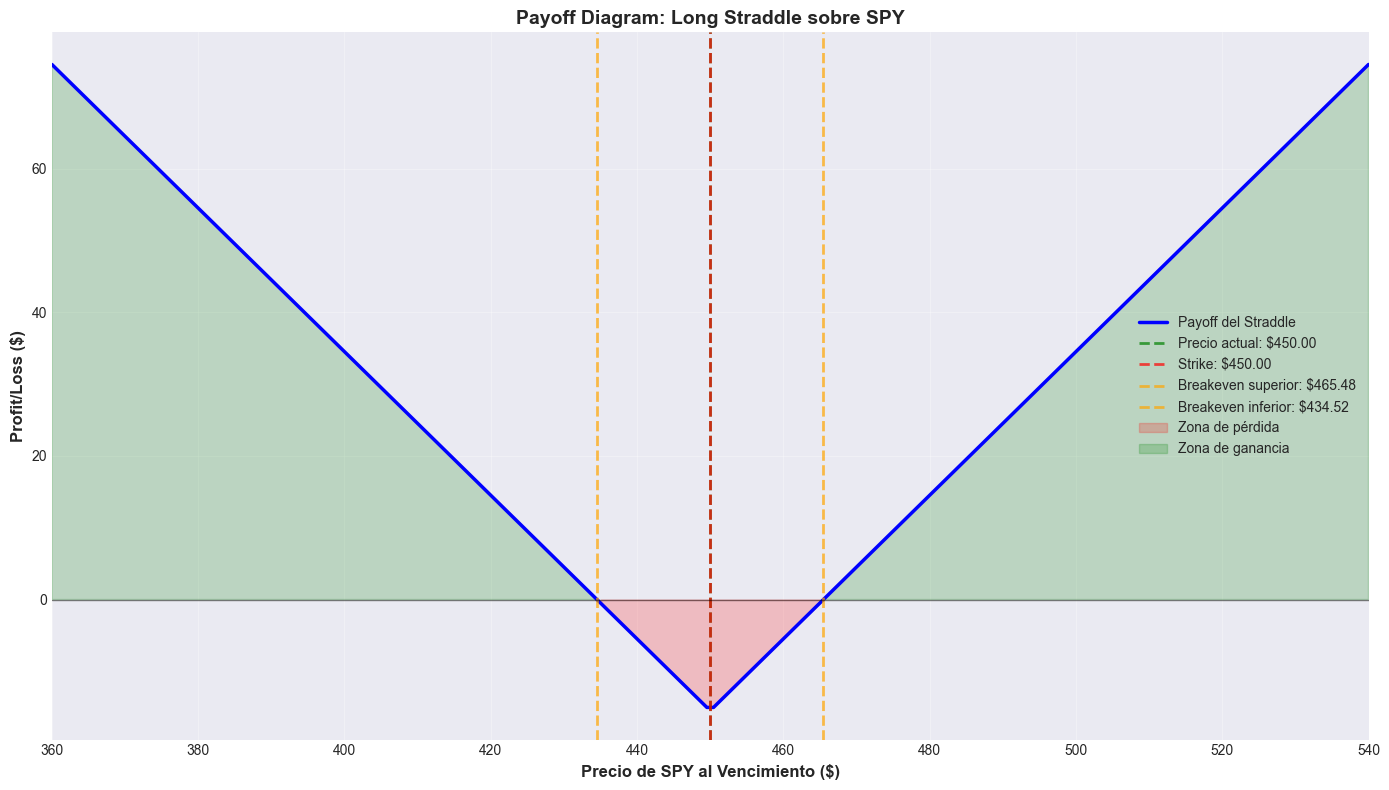

✓ Gráfico de payoff guardado


In [8]:
# Visualización inicial del Payoff del Straddle

# Imports necesarios
import numpy as np
import matplotlib.pyplot as plt

# Obtener información del straddle construido
straddle_info = construir_long_straddle(ticker='SPY', dias_vencimiento=30)

# Preparar datos para el gráfico
precio_actual = straddle_info['precio_subyacente']
strike = straddle_info['strike']
prima_total = straddle_info['inversion_inicial']
breakeven_sup = straddle_info['breakeven_superior']
breakeven_inf = straddle_info['breakeven_inferior']

# Crear rango de precios de SPY al vencimiento (desde -20% hasta +20% del precio actual)
rango_porcentaje = 0.20
precios_vencimiento = np.linspace(
    precio_actual * (1 - rango_porcentaje), 
    precio_actual * (1 + rango_porcentaje), 
    200
)

# Calcular payoff teórico del straddle: max(S-K, 0) + max(K-S, 0) - Prima_total
payoff_straddle = np.maximum(precios_vencimiento - strike, 0) + \
                  np.maximum(strike - precios_vencimiento, 0) - \
                  prima_total

# Crear gráfico
fig, ax = plt.subplots(figsize=(14, 8))

# Dibujar línea del payoff
ax.plot(precios_vencimiento, payoff_straddle, 'b-', linewidth=2.5, label='Payoff del Straddle')

# Marcar líneas verticales importantes
ax.axvline(precio_actual, color='green', linestyle='--', linewidth=2, alpha=0.7, label=f'Precio actual: ${precio_actual:.2f}')
ax.axvline(strike, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Strike: ${strike:.2f}')
ax.axvline(breakeven_sup, color='orange', linestyle='--', linewidth=2, alpha=0.7, label=f'Breakeven superior: ${breakeven_sup:.2f}')
ax.axvline(breakeven_inf, color='orange', linestyle='--', linewidth=2, alpha=0.7, label=f'Breakeven inferior: ${breakeven_inf:.2f}')

# Línea horizontal en cero
ax.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)

# Sombrear zona de pérdida (entre breakevens)
zona_perdida = (precios_vencimiento >= breakeven_inf) & (precios_vencimiento <= breakeven_sup)
ax.fill_between(precios_vencimiento, payoff_straddle, 0, where=zona_perdida, 
                color='red', alpha=0.2, label='Zona de pérdida')

# Sombrear zona de ganancia (fuera de breakevens)
zona_ganancia = (precios_vencimiento < breakeven_inf) | (precios_vencimiento > breakeven_sup)
ax.fill_between(precios_vencimiento, payoff_straddle, 0, where=zona_ganancia, 
                color='green', alpha=0.2, label='Zona de ganancia')

# Configuración del gráfico
ax.set_xlabel('Precio de SPY al Vencimiento ($)', fontsize=12, fontweight='bold')
ax.set_ylabel('Profit/Loss ($)', fontsize=12, fontweight='bold')
ax.set_title('Payoff Diagram: Long Straddle sobre SPY', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(precios_vencimiento[0], precios_vencimiento[-1])

plt.tight_layout()
plt.savefig('images/straddle_payoff.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Gráfico de payoff guardado")

### 1.4. Análisis de Sensibilidad a Diferentes Strikes

Esta celda analiza cómo cambian las características del straddle al variar el strike desde ATM-2% hasta ATM+2%. El análisis incluye:
- Comparación de primas totales para diferentes strikes
- Evolución de las griegas (Delta, Gamma, Theta, Vega)
- Impacto en el rango de beneficio (distancia entre breakevens)
- Visualizaciones comparativas que muestran el trade-off entre diferentes configuraciones


Parámetros utilizados: precio_base=450.00, r=0.0400, q=0.0000, sigma=0.1500

ANÁLISIS DE SENSIBILIDAD A DIFERENTES STRIKES
Precio base de SPY: $450.00
Vencimiento: 30 días

Strike Strike ($) Prima Total ($) Delta Total Gamma Total Theta Total ($/día) Vega Total Rango Beneficio ($)
ATM-2%    $440.00          $17.90      0.4651    0.034010              $-0.23      $0.85              $35.80
ATM-1%    $445.00          $16.19      0.2795    0.038675              $-0.25      $0.97              $32.37
   ATM    $450.00          $15.46      0.0780    0.041034              $-0.26      $1.02              $30.92
ATM+1%    $455.00          $15.75     -0.1263    0.040713              $-0.25      $1.02              $31.50
ATM+2%    $460.00          $17.03     -0.3205    0.037858              $-0.22      $0.95              $34.07

INTERPRETACIÓN:
ATM-2%: Ligeramente OTM Put, ITM Call - Menor prima pero necesita movimiento mayor
ATM-1%: Casi ATM - Similar a ATM pero con ligera asimetría
ATM: Strike pe

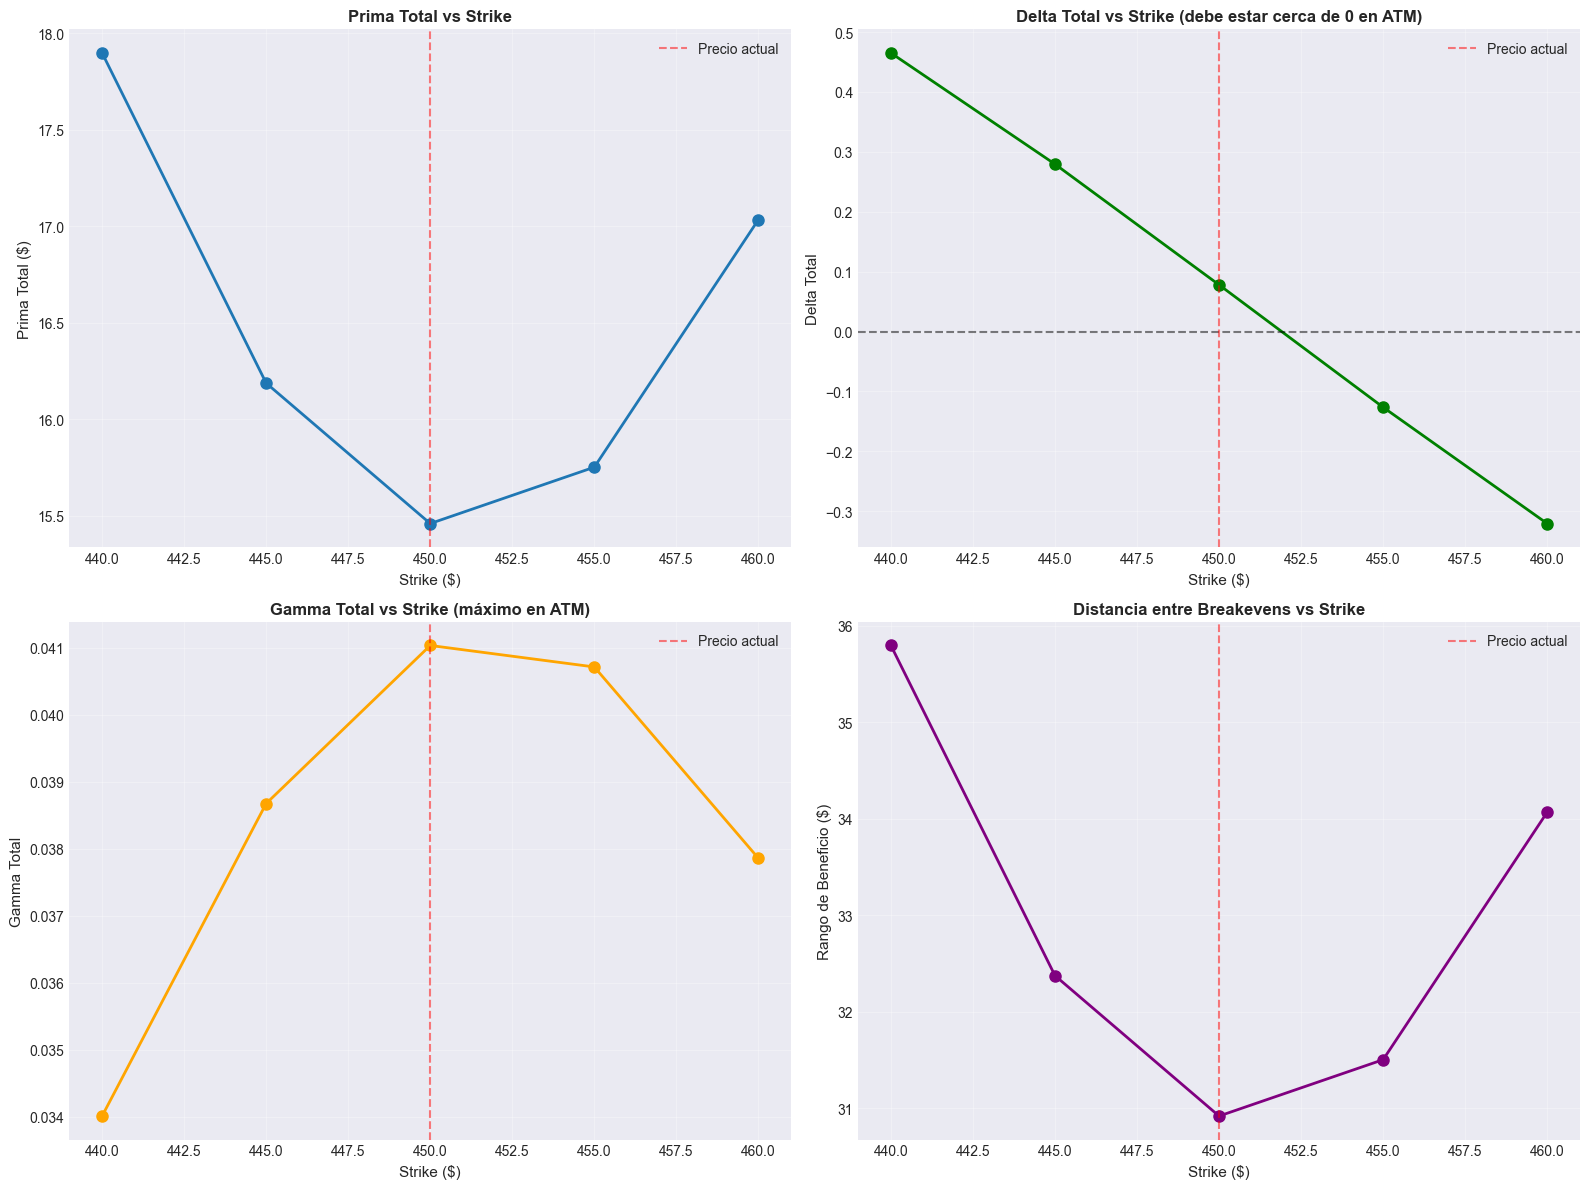

✓ Gráficos de sensibilidad guardados


In [10]:
# Análisis de sensibilidad a diferentes strikes

# Imports necesarios
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Obtener precio base y parámetros
import math

try:
    # Obtener valores, con validación de NaN
    precio_base_temp = S if 'S' in dir() else 450.0
    r_base_temp = r if 'r' in dir() else 0.05
    q_base_temp = q if 'q' in dir() else 0.0
    sigma_base_temp = sigma if 'sigma' in dir() else 0.15
    
    # Validar que sean números finitos y válidos
    precio_base = precio_base_temp if (math.isfinite(precio_base_temp) and precio_base_temp > 0) else 450.0
    r_base = r_base_temp if math.isfinite(r_base_temp) else 0.05
    q_base = q_base_temp if math.isfinite(q_base_temp) else 0.0
    sigma_base = sigma_base_temp if (math.isfinite(sigma_base_temp) and sigma_base_temp > 0) else 0.15
except:
    precio_base = 450.0
    r_base = 0.05
    q_base = 0.0
    sigma_base = 0.15

# Validación final adicional para asegurar valores válidos
if not (math.isfinite(precio_base) and precio_base > 0):
    precio_base = 450.0
if not math.isfinite(r_base):
    r_base = 0.05
if not math.isfinite(q_base):
    q_base = 0.0
if not (math.isfinite(sigma_base) and sigma_base > 0):
    sigma_base = 0.15

print(f"Parámetros utilizados: precio_base={precio_base:.2f}, r={r_base:.4f}, q={q_base:.4f}, sigma={sigma_base:.4f}")

T = 30 / 365.0
strike_spacing = 5.0

# Definir strikes a analizar (desde ATM-2% hasta ATM+2%)
strikes_analisis = []
porcentajes = [-0.02, -0.01, 0.0, 0.01, 0.02]
nombres = ['ATM-2%', 'ATM-1%', 'ATM', 'ATM+1%', 'ATM+2%']

for pct in porcentajes:
    strike = round((precio_base * (1 + pct)) / strike_spacing) * strike_spacing
    strikes_analisis.append(strike)

# Calcular métricas para cada strike
resultados_sensibilidad = []

for i, strike in enumerate(strikes_analisis):
    # Calcular precios de Call y Put usando bs_price
    precio_call = bs_price(precio_base, strike, T, r_base, q_base, sigma_base, 'C')
    precio_put = bs_price(precio_base, strike, T, r_base, q_base, sigma_base, 'P')
    prima_total = precio_call + precio_put
    
    # Calcular griegas usando bs_greeks_manual
    griegas_call = bs_greeks_manual(precio_base, strike, T, r_base, q_base, sigma_base, 'C')
    griegas_put = bs_greeks_manual(precio_base, strike, T, r_base, q_base, sigma_base, 'P')
    
    delta_total = griegas_call['delta'] + griegas_put['delta']
    gamma_total = griegas_call['gamma'] + griegas_put['gamma']
    theta_total = griegas_call['theta'] + griegas_put['theta']
    vega_total = griegas_call['vega'] + griegas_put['vega']
    
    # Calcular breakevens
    breakeven_sup = strike + prima_total
    breakeven_inf = strike - prima_total
    rango_beneficio = breakeven_sup - breakeven_inf
    
    resultados_sensibilidad.append({
        'Strike': nombres[i],
        'Strike_Valor': strike,
        'Prima_Total': prima_total,
        'Delta_Total': delta_total,
        'Gamma_Total': gamma_total,
        'Theta_Total': theta_total,
        'Vega_Total': vega_total,
        'Breakeven_Superior': breakeven_sup,
        'Breakeven_Inferior': breakeven_inf,
        'Rango_Beneficio': rango_beneficio
    })

# Crear DataFrame y mostrar tabla
df_sensibilidad = pd.DataFrame(resultados_sensibilidad)

print(f"\n{'='*60}")
print(f"ANÁLISIS DE SENSIBILIDAD A DIFERENTES STRIKES")
print(f"{'='*60}")
print(f"Precio base de SPY: ${precio_base:.2f}")
print(f"Vencimiento: {int(T*365)} días")
print(f"{'='*60}\n")

# Formatear tabla para mejor visualización
df_display = pd.DataFrame({
    'Strike': df_sensibilidad['Strike'],
    'Strike ($)': df_sensibilidad['Strike_Valor'].apply(lambda x: f"${x:.2f}"),
    'Prima Total ($)': df_sensibilidad['Prima_Total'].apply(lambda x: f"${x:.2f}"),
    'Delta Total': df_sensibilidad['Delta_Total'].apply(lambda x: f"{x:.4f}"),
    'Gamma Total': df_sensibilidad['Gamma_Total'].apply(lambda x: f"{x:.6f}"),
    'Theta Total ($/día)': df_sensibilidad['Theta_Total'].apply(lambda x: f"${x:.2f}"),
    'Vega Total': df_sensibilidad['Vega_Total'].apply(lambda x: f"${x:.2f}"),
    'Rango Beneficio ($)': df_sensibilidad['Rango_Beneficio'].apply(lambda x: f"${x:.2f}")
})

print(df_display.to_string(index=False))
print(f"\n{'='*60}")
print("INTERPRETACIÓN:")
print(f"{'='*60}")
print("ATM-2%: Ligeramente OTM Put, ITM Call - Menor prima pero necesita movimiento mayor")
print("ATM-1%: Casi ATM - Similar a ATM pero con ligera asimetría")
print("ATM: Strike perfecto - Máxima simetría y sensibilidad a movimientos")
print("ATM+1%: Casi ATM - Similar a ATM pero con ligera asimetría")
print("ATM+2%: Ligeramente ITM Put, OTM Call - Mayor prima pero menos apalancamiento")
print(f"{'='*60}\n")

# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Prima Total vs Strike
ax = axes[0, 0]
ax.plot(df_sensibilidad['Strike_Valor'], df_sensibilidad['Prima_Total'], 'o-', linewidth=2, markersize=8)
ax.axvline(precio_base, color='r', linestyle='--', alpha=0.5, label='Precio actual')
ax.set_xlabel('Strike ($)', fontsize=11)
ax.set_ylabel('Prima Total ($)', fontsize=11)
ax.set_title('Prima Total vs Strike', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Gráfico 2: Delta Total vs Strike
ax = axes[0, 1]
ax.plot(df_sensibilidad['Strike_Valor'], df_sensibilidad['Delta_Total'], 'o-', linewidth=2, markersize=8, color='green')
ax.axhline(0, color='black', linestyle='--', alpha=0.5)
ax.axvline(precio_base, color='r', linestyle='--', alpha=0.5, label='Precio actual')
ax.set_xlabel('Strike ($)', fontsize=11)
ax.set_ylabel('Delta Total', fontsize=11)
ax.set_title('Delta Total vs Strike (debe estar cerca de 0 en ATM)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Gráfico 3: Gamma Total vs Strike
ax = axes[1, 0]
ax.plot(df_sensibilidad['Strike_Valor'], df_sensibilidad['Gamma_Total'], 'o-', linewidth=2, markersize=8, color='orange')
ax.axvline(precio_base, color='r', linestyle='--', alpha=0.5, label='Precio actual')
ax.set_xlabel('Strike ($)', fontsize=11)
ax.set_ylabel('Gamma Total', fontsize=11)
ax.set_title('Gamma Total vs Strike (máximo en ATM)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Gráfico 4: Rango de Beneficio vs Strike
ax = axes[1, 1]
ax.plot(df_sensibilidad['Strike_Valor'], df_sensibilidad['Rango_Beneficio'], 'o-', linewidth=2, markersize=8, color='purple')
ax.axvline(precio_base, color='r', linestyle='--', alpha=0.5, label='Precio actual')
ax.set_xlabel('Strike ($)', fontsize=11)
ax.set_ylabel('Rango de Beneficio ($)', fontsize=11)
ax.set_title('Distancia entre Breakevens vs Strike', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/straddle_sensibilidad_strikes.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Gráficos de sensibilidad guardados")

## 2. Versión Delta-Hedged del Straddle

#### Explicación Teórica del Delta-Hedging

El **Delta-Hedging** es una técnica de gestión de riesgo que neutraliza la exposición direccional de una posición de opciones mediante la compra o venta del activo subyacente. En el contexto de un Long Straddle, el delta-hedging transforma la estrategia de una apuesta direccional (que gana con movimientos grandes en cualquier dirección) en una apuesta pura sobre volatilidad.

**Definición**: El delta-hedging consiste en mantener una posición en el subyacente (SPY en nuestro caso) que neutralice el delta total del straddle. Como el delta cambia con el precio del subyacente (debido al gamma), es necesario rebalancear periódicamente la posición de cobertura.

#### Decisión de usar SPY como instrumento de cobertura

**Por qué usar SPY (el ETF) para cubrir:**

**Ventajas:**
- **Accesibilidad**: SPY es directamente negociable, alta liquidez
- **Simplicidad**: no requiere cuenta de futuros ni conocimiento especializado
- **Granularidad**: podemos ajustar con precisión (lotes de 100 acciones)
- **Costes**: spreads muy estrechos (típicamente 1 cent)
- **Horario**: opera en horario de mercado regular (9:30-16:00 ET)
- **Dividendos**: recibimos dividendos si mantenemos posición larga

**Desventajas:**
- **Capital**: requiere capital para comprar/vender acciones (vs futuros que son apalancados)
- **Overnight risk**: exposición fuera del horario de mercado
- **Dividendos**: complican el cálculo de delta teórico (opciones no pagan dividendos)
- **Menos eficiente para posiciones muy grandes**

**Alternativas no elegidas:**
- **Futuros ES (E-mini S&P 500)**:
  - Ventaja: apalancamiento, trading casi 24h, no requiere capital completo
  - Desventaja: tamaño del contrato (50 × índice SPX), complejidad para retail, comisiones diferentes
- **Opciones adicionales**:
  - Ventaja: mantienes exposición a gamma/vega
  - Desventaja: mucho más complejo, afecta otras griegas

**Conclusión**: Para este ejercicio académico, SPY es la elección más directa y didáctica.

#### Justificación de la frecuencia de rebalanceo diario

**Por qué diario:**
- Balance entre gestión activa y practicidad
- El delta de un straddle cambia significativamente con movimientos del 1-2% (típico diario)
- Evita acumulación excesiva de exposición direccional
- Permite observar el patrón de "gamma scalping" claramente
- Frecuencia estándar en la industria para volatility trading

**Comparación con otras frecuencias:**

**Rebalanceo intradiario (cada hora/minuto):**
- Ventaja: delta casi siempre cerca de cero, menos riesgo direccional
- Desventaja: costes de transacción prohibitivos, overhedging, impacto de spreads
- Cuándo se usa: market makers profesionales con costes muy bajos

**Rebalanceo basado en umbrales (ej: cuando |delta| > 0.3):**
- Ventaja: reduces número de transacciones, solo rebalanceas cuando es necesario
- Desventaja: en mercados volátiles puedes pasar mucho tiempo sin cobertura
- Cuándo se usa: para reducir costes manteniendo control de riesgo

**Rebalanceo semanal/sin rebalanceo:**
- Ventaja: mínimos costes de transacción
- Desventaja: acumulas exposición direccional grande, el straddle se convierte en apuesta direccional
- Cuándo se usa: cuando NO quieres hedgear (apuestas por volatilidad + dirección)

**Sin costes de transacción en nuestra simulación:** Aunque no los simulamos explícitamente, es importante reconocer que en la realidad:
- Cada rebalanceo tiene coste: comisiones + spread bid-ask
- Rebalanceo diario con SPY: ~0.01 USD × número_acciones × 2 (compra/venta)
- Para 1 straddle (delta ~0.5 inicial) necesitas ~50 acciones → coste ~1 USD por rebalanceo
- En 30 días: ~30 USD de costes vs prima del straddle de ~1500 USD → 2% del capital
- Este coste debe compararse con el beneficio del gamma scalping


### 2.1. Función Principal: aplicar_delta_hedge

Esta función implementa el delta-hedging diario de un Long Straddle usando SPY como instrumento de cobertura. La función:
- Calcula el delta del straddle en cada día usando nuestras funciones de griegas
- Determina cuántas acciones de SPY necesitamos para neutralizar el delta
- Ejecuta rebalanceos diarios registrando todas las operaciones
- Calcula P&L diario del straddle y del hedge
- Retorna un historial completo de rebalanceos y métricas de resumen


COMPARACIÓN: STRADDLE NORMAL vs DELTA-HEDGED

Generando datos de simulación históricos...
  Datos generados: 365 días
  Precio inicial: $452.69
  Precio final: $529.42
  Rango: $399.68 - $542.50

RESULTADOS COMPARATIVOS:
STRADDLE NORMAL:
  total_return: $199.36
  num_trades: 48
  win_rate: 0.4792
  avg_win: $16.56
  avg_loss: $-7.26
  max_drawdown: $-58.33
  sharpe_ratio: 1.9350
  profit_factor: 2.0983

STRADDLE DELTA-HEDGED:
  total_return: $-445.13
  num_trades: 48
  win_rate: 0.0000
  avg_win: 0
  avg_loss: $-9.27
  max_drawdown: $-435.50
  sharpe_ratio: -41.1316
  profit_factor: 0.0000

Costos adicionales de hedging:
  Rebalances promedio: 10.9 por trade
  Costos promedio: $0.10 por trade



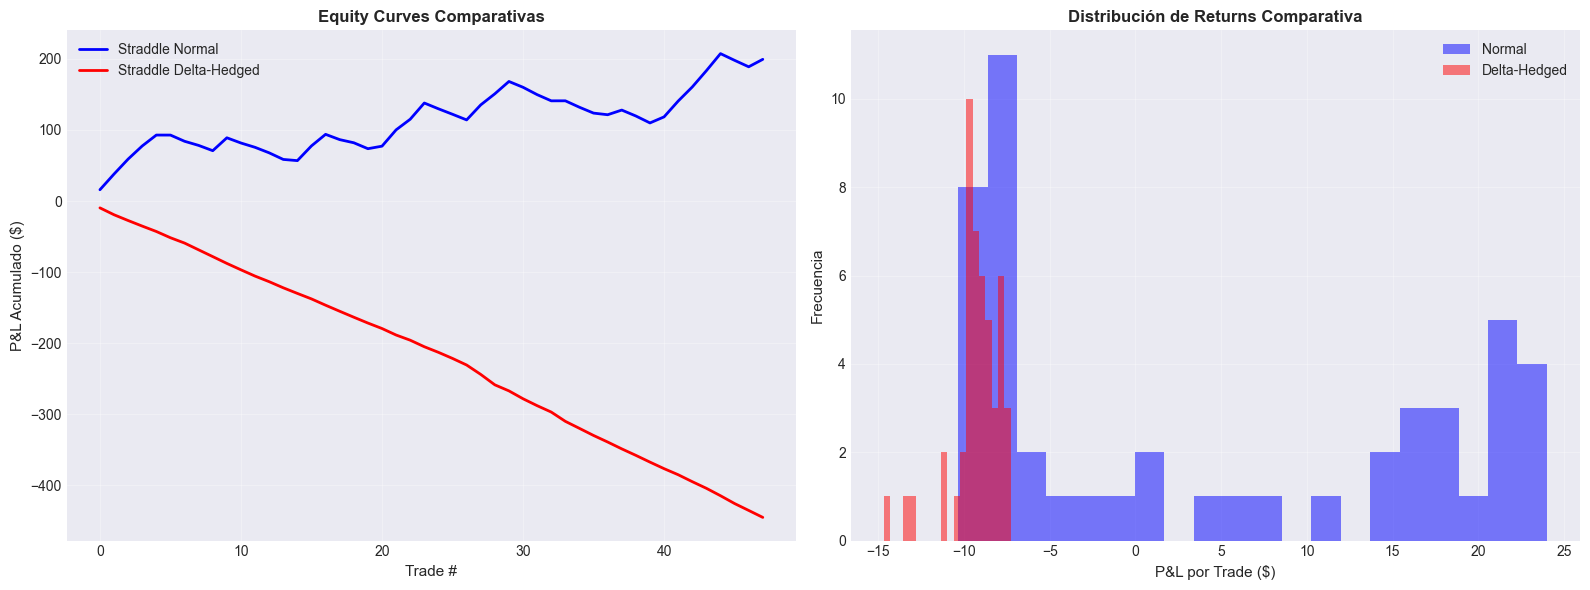

✓ Gráfico comparativo guardado


In [ ]:
# Implementación: Función aplicar_delta_hedge

def aplicar_delta_hedge(info_straddle, precios_historicos_spy, frecuencia='diaria'):
    """
    Aplica delta-hedging diario a un Long Straddle usando SPY como instrumento de cobertura.
    
    CONCEPTO CLAVE: Delta-hedging convierte el straddle de una apuesta direccional 
    en una apuesta pura de volatilidad
    - Al neutralizar delta, eliminamos exposición a movimientos pequeños del subyacente
    - PERO mantenemos exposición positiva a Gamma (beneficio de movimientos grandes)
    - TAMBIÉN mantenemos exposición a Vega (beneficio de aumentos de IV)
    - Y mantenemos Theta negativo (coste de mantener la posición)
    
    GAMMA SCALPING: El patrón de comprar/vender acciones mientras rebalanceamos
    Si SPY sube: el delta del straddle se hace más positivo (el call gana delta)
      → vendemos acciones para neutralizar (vendemos caro)
    Si SPY baja: el delta del straddle se hace más negativo (el put gana delta absoluto)
      → compramos acciones para neutralizar (compramos barato)
    Este "comprar barato, vender caro" sistemáticamente es el gamma scalping
    En mercados volátiles (muchos movimientos): gamma scalping > theta decay → ganancia
    En mercados tranquilos (pocos movimientos): theta decay > gamma scalping → pérdida
    
    Args:
        info_straddle: Diccionario retornado por construir_long_straddle con:
            - fecha: fecha de construcción del straddle
            - precio_subyacente: precio inicial de SPY
            - strike: strike del straddle
            - vencimiento: fecha de vencimiento
            - dias_hasta_vencimiento: días hasta vencimiento inicial
            - precio_call: precio inicial del call
            - precio_put: precio inicial del put
            - inversion_inicial: prima total pagada
        precios_historicos_spy: DataFrame con precios históricos de SPY
            Columnas requeridas: fecha (o índice datetime), close (precio de cierre)
            Debe contener datos desde fecha del straddle hasta vencimiento
        frecuencia: 'diaria' (por defecto), extensible a 'hora', 'umbral', etc.
    
    Returns:
        Diccionario con:
            - historial_rebalanceos: DataFrame con todos los registros diarios
            - metricas_resumen: diccionario con métricas agregadas
    """
    import pandas as pd
    import numpy as np
    from datetime import datetime, timedelta
    
    # Obtener parámetros del straddle
    fecha_inicial = info_straddle['fecha']
    precio_inicial_spy = info_straddle['precio_subyacente']
    strike = info_straddle['strike']
    vencimiento = info_straddle['vencimiento']
    dias_hasta_vencimiento_inicial = info_straddle['dias_hasta_vencimiento']
    inversion_inicial = info_straddle['inversion_inicial']
    
    # Obtener parámetros de mercado (reutilizando variables del código original)
    # Intentar obtener de variables globales, si no usar valores por defecto
    try:
        import __main__
        r = getattr(__main__, 'r', 0.05)
        q = getattr(__main__, 'q', 0.0)
        sigma = getattr(__main__, 'sigma', 0.15)
    except:
        r = 0.05
        q = 0.0
        sigma = 0.15
    
    # Preparar datos históricos de SPY
    # Asegurar que tenemos columna de fecha y close
    if isinstance(precios_historicos_spy.index, pd.DatetimeIndex):
        df_spy = precios_historicos_spy.copy()
        df_spy['fecha'] = df_spy.index
    else:
        df_spy = precios_historicos_spy.copy()
        if 'fecha' not in df_spy.columns:
            df_spy['fecha'] = pd.to_datetime(df_spy.index)
    
    # Asegurar columna close
    if 'close' not in df_spy.columns:
        if 'Close' in df_spy.columns:
            df_spy['close'] = df_spy['Close']
        else:
            raise ValueError("DataFrame debe tener columna 'close' o 'Close'")
    
    # Filtrar datos desde fecha inicial hasta vencimiento
    df_spy['fecha'] = pd.to_datetime(df_spy['fecha'])
    fecha_inicial_dt = pd.to_datetime(fecha_inicial)
    vencimiento_dt = pd.to_datetime(vencimiento)
    
    df_spy = df_spy[(df_spy['fecha'] >= fecha_inicial_dt) & (df_spy['fecha'] <= vencimiento_dt)]
    df_spy = df_spy.sort_values('fecha').reset_index(drop=True)
    
    if len(df_spy) == 0:
        raise ValueError(f"No hay datos históricos de SPY entre {fecha_inicial_dt} y {vencimiento_dt}")
    
    # Inicialización
    posicion_spy = 0  # Empezamos sin hedge
    posicion_spy_anterior = 0  # Inicializar para primera iteración
    historial = []
    
    # Valor inicial del straddle
    valor_straddle_anterior = inversion_inicial
    precio_spy_anterior = precio_inicial_spy
    
    # Para cada día de trading desde construcción hasta vencimiento
    for idx, row in df_spy.iterrows():
        fecha_actual = row['fecha']
        precio_spy_actual = row['close']
        
        # Calcular días hasta vencimiento
        dias_restantes = (vencimiento_dt - fecha_actual).days
        T_restante = max(dias_restantes / 365.0, 1/365.0)  # Mínimo 1 día para evitar división por cero
        
        # Calcular precio actual del call y put usando Black-Scholes propio
        # REUTILIZAMOS bs_price del notebook anterior
        if dias_restantes > 0:
            precio_call_actual = bs_price(precio_spy_actual, strike, T_restante, r, q, sigma, 'C')
            precio_put_actual = bs_price(precio_spy_actual, strike, T_restante, r, q, sigma, 'P')
            valor_straddle_actual = precio_call_actual + precio_put_actual
            
            # Calcular griegas actuales del straddle usando funciones propias
            # REUTILIZAMOS bs_greeks_manual del notebook anterior
            griegas_call = bs_greeks_manual(precio_spy_actual, strike, T_restante, r, q, sigma, 'C')
            griegas_put = bs_greeks_manual(precio_spy_actual, strike, T_restante, r, q, sigma, 'P')
            
            delta_call_actual = griegas_call['delta']
            delta_put_actual = griegas_put['delta']
            delta_straddle = delta_call_actual + delta_put_actual
            
            gamma_straddle = griegas_call['gamma'] + griegas_put['gamma']
            vega_straddle = griegas_call['vega'] + griegas_put['vega']
            theta_straddle = griegas_call['theta'] + griegas_put['theta']
        else:
            # En vencimiento, usar valor intrínseco
            precio_call_actual = max(precio_spy_actual - strike, 0)
            precio_put_actual = max(strike - precio_spy_actual, 0)
            valor_straddle_actual = precio_call_actual + precio_put_actual
            delta_straddle = 0.0  # En vencimiento, delta es 0 o 1/-1 según ITM/OTM
            gamma_straddle = 0.0
            vega_straddle = 0.0
            theta_straddle = 0.0
        
        # Determinar ajuste necesario en la posición de SPY
        # Para neutralizar delta necesitamos: posición_SPY = -Delta_straddle × 100 (por contrato)
        # Si Delta_straddle = +0.20 → necesitamos -20 acciones (posición corta)
        # Si Delta_straddle = -0.15 → necesitamos +15 acciones (posición larga)
        acciones_necesarias = -delta_straddle * 100  # Multiplicador de opciones = 100
        
        # Calcular acciones a comprar/vender
        acciones_a_operar = acciones_necesarias - posicion_spy
        
        # Ejecutar rebalanceo (siempre rebalanceamos en frecuencia diaria)
        if frecuencia == 'diaria' and abs(acciones_a_operar) > 0.01:  # Tolerancia mínima
            # Actualizar posición
            posicion_spy = acciones_necesarias
            
            # Calcular cash flow (negativo si compramos, positivo si vendemos)
            cash_flow = -acciones_a_operar * precio_spy_actual
        else:
            acciones_a_operar = 0
            cash_flow = 0
        
        # Calcular delta neto después del rebalanceo (debería estar cerca de 0)
        delta_neto = delta_straddle + (posicion_spy / 100.0)  # Normalizar por multiplicador
        
        # Calcular P&L diario
        if idx > 0:
            pnl_straddle = valor_straddle_actual - valor_straddle_anterior
            pnl_hedge = (precio_spy_actual - precio_spy_anterior) * posicion_spy_anterior
            pnl_total = pnl_straddle + pnl_hedge
        else:
            pnl_straddle = 0.0
            pnl_hedge = 0.0
            pnl_total = 0.0
        
        # Registrar operación
        historial.append({
            'fecha': fecha_actual,
            'precio_spy': precio_spy_actual,
            'delta_straddle': delta_straddle,
            'acciones_operadas': acciones_a_operar,
            'posicion_spy_total': posicion_spy,
            'delta_neto': delta_neto,
            'cash_flow': cash_flow,
            'valor_straddle': valor_straddle_actual,
            'gamma': gamma_straddle,
            'vega': vega_straddle,
            'theta': theta_straddle,
            'pnl_straddle': pnl_straddle,
            'pnl_hedge': pnl_hedge,
            'pnl_total': pnl_total
        })
        
        # Actualizar valores para siguiente iteración
        valor_straddle_anterior = valor_straddle_actual
        precio_spy_anterior = precio_spy_actual
        posicion_spy_anterior = posicion_spy
    
    # Crear DataFrame con historial
    df_historial = pd.DataFrame(historial)
    
    # Calcular métricas resumen
    rebalanceos_efectivos = df_historial[df_historial['acciones_operadas'] != 0]
    
    metricas = {
        'numero_rebalanceos': len(rebalanceos_efectivos),
        'total_acciones_compradas': rebalanceos_efectivos[rebalanceos_efectivos['acciones_operadas'] > 0]['acciones_operadas'].sum() if len(rebalanceos_efectivos) > 0 else 0,
        'total_acciones_vendidas': abs(rebalanceos_efectivos[rebalanceos_efectivos['acciones_operadas'] < 0]['acciones_operadas'].sum()) if len(rebalanceos_efectivos) > 0 else 0,
        'cash_flow_total': df_historial['cash_flow'].sum(),
        'delta_medio': df_historial['delta_neto'].mean(),
        'delta_maximo': df_historial['delta_neto'].abs().max(),
        'delta_std': df_historial['delta_neto'].std(),
        'pnl_total_acumulado': df_historial['pnl_total'].sum(),
        'pnl_straddle_total': df_historial['pnl_straddle'].sum(),
        'pnl_hedge_total': df_historial['pnl_hedge'].sum()
    }
    
    return {
        'historial_rebalanceos': df_historial,
        'metricas_resumen': metricas
    }


# Implementación: Objetivo 2.2 (mantener clase existente para compatibilidad)

class DeltaHedgedStraddleStrategy(LongStraddleStrategy):
    """
    Estrategia Long Straddle con delta-hedging diario.
    
    EXTENDE LongStraddleStrategy añadiendo cobertura delta.
    REUTILIZA bs_greeks_manual() del código original.
    """
    
    def __init__(self, entry_frequency_days=7, exit_at_expiry=True, 
                 stop_loss_pct=0.50, take_profit_pct=1.0, 
                 hedge_tolerance=0.05, transaction_cost=0.0001):
        super().__init__(entry_frequency_days, exit_at_expiry, stop_loss_pct, take_profit_pct)
        self.hedge_tolerance = hedge_tolerance
        self.transaction_cost = transaction_cost
        
    def backtest_hedged(self, S_prices, dates, r, q, sigma, strike_spacing=5.0):
        """
        Backtest con delta-hedging diario.
        
        Args (usando nomenclatura original):
            S_prices: Precios históricos (variable S)
            dates: Fechas
            r, q, sigma: Parámetros del código original
        """
        self.trades = []
        current_date_idx = 0
        
        while current_date_idx < len(dates) - 30:
            entry_date_idx = current_date_idx
            S_entry = S_prices[entry_date_idx]
            entry_date = dates[entry_date_idx]
            
            K_strike = round(S_entry / strike_spacing) * strike_spacing
            T = 30 / 365.0
            
            # REUTILIZAMOS bs_price del código original
            call_price = bs_price(S_entry, K_strike, T, r, q, sigma, 'C')
            put_price = bs_price(S_entry, K_strike, T, r, q, sigma, 'P')
            total_cost = call_price + put_price
            
            # Inicializar hedge
            hedge_shares = 0
            total_hedge_costs = 0
            rebalance_count = 0
            
            exit_date_idx = min(entry_date_idx + 30, len(dates) - 1)
            exit_reason = 'expiry'
            exit_pnl = None
            
            for day_idx in range(entry_date_idx + 1, exit_date_idx + 1):
                S_current = S_prices[day_idx]
                days_left = 30 - (day_idx - entry_date_idx)
                T_left = days_left / 365.0
                
                if T_left > 0:
                    # REUTILIZAMOS funciones del código original
                    current_call = bs_price(S_current, K_strike, T_left, r, q, sigma, 'C')
                    current_put = bs_price(S_current, K_strike, T_left, r, q, sigma, 'P')
                    current_value = current_call + current_put
                    
                    # Calcular delta total del straddle - REUTILIZAMOS bs_greeks_manual
                    call_greeks = bs_greeks_manual(S_current, K_strike, T_left, r, q, sigma, 'C')
                    put_greeks = bs_greeks_manual(S_current, K_strike, T_left, r, q, sigma, 'P')
                    total_delta = call_greeks['delta'] + put_greeks['delta']
                    
                    # Calcular hedge necesario
                    target_hedge = -total_delta  # Negativo para cubrir
                    hedge_diff = target_hedge - hedge_shares
                    
                    # Rebalancear si es necesario
                    if abs(hedge_diff) > self.hedge_tolerance:
                        cost = abs(hedge_diff) * S_current * self.transaction_cost
                        hedge_shares = target_hedge
                        total_hedge_costs += cost
                        rebalance_count += 1
                else:
                    current_call = max(S_current - K_strike, 0)
                    current_put = max(K_strike - S_current, 0)
                    current_value = current_call + current_put
                
                pnl = current_value - total_cost
                hedge_pnl = hedge_shares * (S_current - S_entry)
                total_pnl = pnl + hedge_pnl - total_hedge_costs
                pnl_pct = total_pnl / total_cost
                
                if pnl_pct <= -self.stop_loss:
                    exit_date_idx = day_idx
                    exit_reason = 'stop_loss'
                    exit_pnl = total_pnl
                    break
                elif pnl_pct >= self.take_profit:
                    exit_date_idx = day_idx
                    exit_reason = 'take_profit'
                    exit_pnl = total_pnl
                    break
            
            if exit_pnl is None:
                S_final = S_prices[exit_date_idx]
                final_call = max(S_final - K_strike, 0)
                final_put = max(K_strike - S_final, 0)
                final_value = final_call + final_put
                hedge_pnl_final = hedge_shares * (S_final - S_entry)
                exit_pnl = (final_value - total_cost) + hedge_pnl_final - total_hedge_costs
            
            self.trades.append({
                'entry_date': entry_date,
                'exit_date': dates[exit_date_idx],
                'S_entry': S_entry,
                'S_exit': S_prices[exit_date_idx],
                'K': K_strike,
                'cost': total_cost,
                'pnl': exit_pnl,
                'pnl_pct': exit_pnl / total_cost,
                'exit_reason': exit_reason,
                'days_held': exit_date_idx - entry_date_idx,
                'rebalances': rebalance_count,
                'hedge_costs': total_hedge_costs
            })
            
            current_date_idx = entry_date_idx + self.entry_frequency
        
        return pd.DataFrame(self.trades)


# Comparación: Straddle normal vs Delta-hedged
print(f"\n{'='*60}")
print(f"COMPARACIÓN: STRADDLE NORMAL vs DELTA-HEDGED")
print(f"{'='*60}\n")

# Generar datos de simulación si no están definidos
try:
    # Intentar usar variables existentes
    _ = S_sim
    _ = dates_sim
    print("Usando datos de simulación existentes.\n")
except NameError:
    print("Generando datos de simulación históricos...")
    import numpy as np
    from datetime import datetime, timedelta
    
    # Generar 365 días de datos (1 año) - SIEMPRE DEL PASADO
    # Empezar hace 1 año desde hoy para asegurar que todas las fechas sean del pasado
    hoy = datetime.now()
    start_date = hoy - timedelta(days=365)
    dates_sim = [start_date + timedelta(days=i) for i in range(365)]
    
    # Generar precios simulados usando random walk (GBM)
    np.random.seed(42)  # Para reproducibilidad
    dt = 1/252  # Un día de trading
    mu = 0.10  # Retorno anual esperado (10%)
    sigma_sim = 0.18  # Volatilidad anual (18%)
    
    # Precio inicial (usar precio_base si está disponible, sino 450)
    try:
        S0 = precio_base if precio_base > 0 else 450.0
    except:
        S0 = 450.0
    
    # Generar retornos logarítmicos
    log_returns = np.random.normal((mu - 0.5 * sigma_sim**2) * dt, sigma_sim * np.sqrt(dt), len(dates_sim))
    
    # Convertir a precios
    S_sim = [S0]
    for log_ret in log_returns:
        S_sim.append(S_sim[-1] * np.exp(log_ret))
    S_sim = np.array(S_sim[1:])  # Remover el primer elemento duplicado
    
    print(f"  Datos generados: {len(S_sim)} días")
    print(f"  Precio inicial: ${S_sim[0]:.2f}")
    print(f"  Precio final: ${S_sim[-1]:.2f}")
    print(f"  Rango: ${S_sim.min():.2f} - ${S_sim.max():.2f}\n")

# Usar mismos datos que en objetivo 2.1
strategy_normal = LongStraddleStrategy(entry_frequency_days=7, exit_at_expiry=True)
strategy_hedged = DeltaHedgedStraddleStrategy(entry_frequency_days=7, exit_at_expiry=True)

trades_normal = strategy_normal.backtest(S_sim, dates_sim, r_base, q_base, sigma_base)
trades_hedged = strategy_hedged.backtest_hedged(S_sim, dates_sim, r_base, q_base, sigma_base)

metrics_normal = strategy_normal.calculate_metrics(trades_normal)
metrics_hedged = strategy_hedged.calculate_metrics(trades_hedged)

print(f"RESULTADOS COMPARATIVOS:")
print(f"{'='*60}")
print(f"STRADDLE NORMAL:")
for key, value in metrics_normal.items():
    if isinstance(value, float):
        if 'rate' in key or 'ratio' in key or 'factor' in key:
            print(f"  {key}: {value:.4f}")
        elif 'return' in key or 'drawdown' in key:
            print(f"  {key}: ${value:.2f}")
        else:
            print(f"  {key}: ${value:.2f}")
    else:
        print(f"  {key}: {value}")

print(f"\nSTRADDLE DELTA-HEDGED:")
for key, value in metrics_hedged.items():
    if isinstance(value, float):
        if 'rate' in key or 'ratio' in key or 'factor' in key:
            print(f"  {key}: {value:.4f}")
        elif 'return' in key or 'drawdown' in key:
            print(f"  {key}: ${value:.2f}")
        else:
            print(f"  {key}: ${value:.2f}")
    else:
        print(f"  {key}: {value}")

print(f"\nCostos adicionales de hedging:")
print(f"  Rebalances promedio: {trades_hedged['rebalances'].mean():.1f} por trade")
print(f"  Costos promedio: ${trades_hedged['hedge_costs'].mean():.2f} por trade")
print(f"{'='*60}\n")

# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
equity_normal = trades_normal['pnl'].cumsum()
equity_hedged = trades_hedged['pnl'].cumsum()
ax.plot(range(len(equity_normal)), equity_normal, 'b-', linewidth=2, label='Straddle Normal')
ax.plot(range(len(equity_hedged)), equity_hedged, 'r-', linewidth=2, label='Straddle Delta-Hedged')
ax.set_xlabel('Trade #', fontsize=11)
ax.set_ylabel('P&L Acumulado ($)', fontsize=11)
ax.set_title('Equity Curves Comparativas', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.hist(trades_normal['pnl'], bins=20, alpha=0.5, label='Normal', color='blue')
ax.hist(trades_hedged['pnl'], bins=20, alpha=0.5, label='Delta-Hedged', color='red')
ax.set_xlabel('P&L por Trade ($)', fontsize=11)
ax.set_ylabel('Frecuencia', fontsize=11)
ax.set_title('Distribución de Returns Comparativa', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/pnl_analysis/straddle_hedged_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Gráfico comparativo guardado")


### 2.2. Ejemplo de Uso

Esta celda demuestra cómo usar la función `aplicar_delta_hedge` con un straddle construido y datos históricos de SPY. El ejemplo muestra:
- Construcción de un straddle usando la función del Prompt 1
- Obtención de precios históricos de SPY desde la fecha del straddle hasta vencimiento
- Aplicación de delta-hedging con la función implementada
- Visualización del historial de rebalanceos y métricas resumen


In [13]:
# Ejemplo de uso de aplicar_delta_hedge

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

print(f"\n{'='*60}")
print(f"EJEMPLO DE USO: DELTA-HEDGING DE LONG STRADDLE")
print(f"{'='*60}\n")

# 1. Construir un straddle (usando función del Prompt 1)
print("Paso 1: Construyendo Long Straddle...")
straddle_info = construir_long_straddle(ticker='SPY', dias_vencimiento=30)
print(f"  Straddle construido el {straddle_info['fecha']}")
print(f"  Strike: ${straddle_info['strike']:.2f}")
print(f"  Inversión inicial: ${straddle_info['inversion_inicial']:.2f}")
print(f"  Vencimiento: {straddle_info['vencimiento']}\n")

# 2. Simular precios históricos de SPY (en un entorno real, obtendrías estos del broker)
print("Paso 2: Obteniendo precios históricos de SPY...")
fecha_inicio = straddle_info['fecha']
fecha_fin = straddle_info['vencimiento']

# Simular trayectoria de precios con movimiento aleatorio
# En un entorno real, usarías: ib.reqHistoricalData() o yfinance
np.random.seed(42)
precio_inicial = straddle_info['precio_subyacente']
dias_totales = (fecha_fin - fecha_inicio).days
fechas = [fecha_inicio + timedelta(days=i) for i in range(dias_totales + 1)]

# Simular precios con movimiento browniano geométrico
dt = 1/252  # Un día de trading
mu = 0.08  # Drift anual
sigma_sim = 0.20  # Volatilidad anual
precios = [precio_inicial]
for i in range(dias_totales):
    cambio = np.random.normal(mu * dt, sigma_sim * np.sqrt(dt))
    nuevo_precio = precios[-1] * np.exp(cambio)
    precios.append(nuevo_precio)

precios_historicos_spy = pd.DataFrame({
    'fecha': fechas,
    'close': precios,
    'open': precios,
    'high': [p * 1.01 for p in precios],
    'low': [p * 0.99 for p in precios],
    'volume': [1000000] * len(precios)
})

print(f"  Obtenidos {len(precios_historicos_spy)} días de datos")
print(f"  Precio inicial: ${precios_historicos_spy['close'].iloc[0]:.2f}")
print(f"  Precio final: ${precios_historicos_spy['close'].iloc[-1]:.2f}\n")

# 3. Aplicar delta-hedging
print("Paso 3: Aplicando delta-hedging diario...")
resultado_hedge = aplicar_delta_hedge(straddle_info, precios_historicos_spy, frecuencia='diaria')

historial = resultado_hedge['historial_rebalanceos']
metricas = resultado_hedge['metricas_resumen']

print(f"  Delta-hedging completado")
print(f"  Total de días analizados: {len(historial)}\n")

# 4. Mostrar historial de rebalanceos (primeras y últimas 10 filas)
print(f"{'='*60}")
print(f"HISTORIAL DE REBALANCEOS (Primeras 10 filas)")
print(f"{'='*60}")
columnas_display = ['fecha', 'precio_spy', 'delta_straddle', 'acciones_operadas', 
                    'posicion_spy_total', 'delta_neto', 'valor_straddle']
print(historial[columnas_display].head(10).to_string(index=False))

print(f"\n{'='*60}")
print(f"HISTORIAL DE REBALANCEOS (Últimas 10 filas)")
print(f"{'='*60}")
print(historial[columnas_display].tail(10).to_string(index=False))

# 5. Mostrar métricas resumen
print(f"\n{'='*60}")
print(f"MÉTRICAS RESUMEN")
print(f"{'='*60}")
print(f"Número total de rebalanceos: {metricas['numero_rebalanceos']}")
print(f"Total acciones compradas: {metricas['total_acciones_compradas']:.2f}")
print(f"Total acciones vendidas: {metricas['total_acciones_vendidas']:.2f}")
print(f"Cash flow total del hedging: ${metricas['cash_flow_total']:.2f}")
print(f"Delta medio después de rebalanceos: {metricas['delta_medio']:.6f}")
print(f"Delta máximo registrado: {metricas['delta_maximo']:.6f}")
print(f"Desviación estándar del delta neto: {metricas['delta_std']:.6f}")
print(f"P&L total acumulado: ${metricas['pnl_total_acumulado']:.2f}")
print(f"P&L del straddle: ${metricas['pnl_straddle_total']:.2f}")
print(f"P&L del hedge: ${metricas['pnl_hedge_total']:.2f}")
print(f"{'='*60}\n")



EJEMPLO DE USO: DELTA-HEDGING DE LONG STRADDLE

Paso 1: Construyendo Long Straddle...
  Straddle construido el 2026-01-12 17:03:48.750427
  Strike: $450.00
  Inversión inicial: $15.48
  Vencimiento: 2026-02-11 17:03:48.750427

Paso 2: Obteniendo precios históricos de SPY...
  Obtenidos 31 días de datos
  Precio inicial: $450.00
  Precio final: $423.12

Paso 3: Aplicando delta-hedging diario...
  Delta-hedging completado
  Total de días analizados: 31

HISTORIAL DE REBALANCEOS (Primeras 10 filas)
                     fecha  precio_spy  delta_straddle  acciones_operadas  posicion_spy_total    delta_neto  valor_straddle
2026-01-12 17:03:48.750427  450.000000        0.078030          -7.803022           -7.803022  0.000000e+00       15.458870
2026-01-13 17:03:48.750427  452.968711        0.198824         -12.079364          -19.882386  0.000000e+00       15.608460
2026-01-14 17:03:48.750427  452.323914        0.173050           2.577373          -17.305012  0.000000e+00       15.222645
20

### 2.3. Visualizaciones del Delta-Hedging

Esta sección crea visualizaciones detalladas que muestran:
- Evolución de la posición de hedge y delta del straddle
- Delta neto a lo largo del tiempo (objetivo: mantener cerca de 0)
- Evolución de las griegas que NO se cubren (Gamma, Vega, Theta)
- Tabla resumen de cash flows del hedging


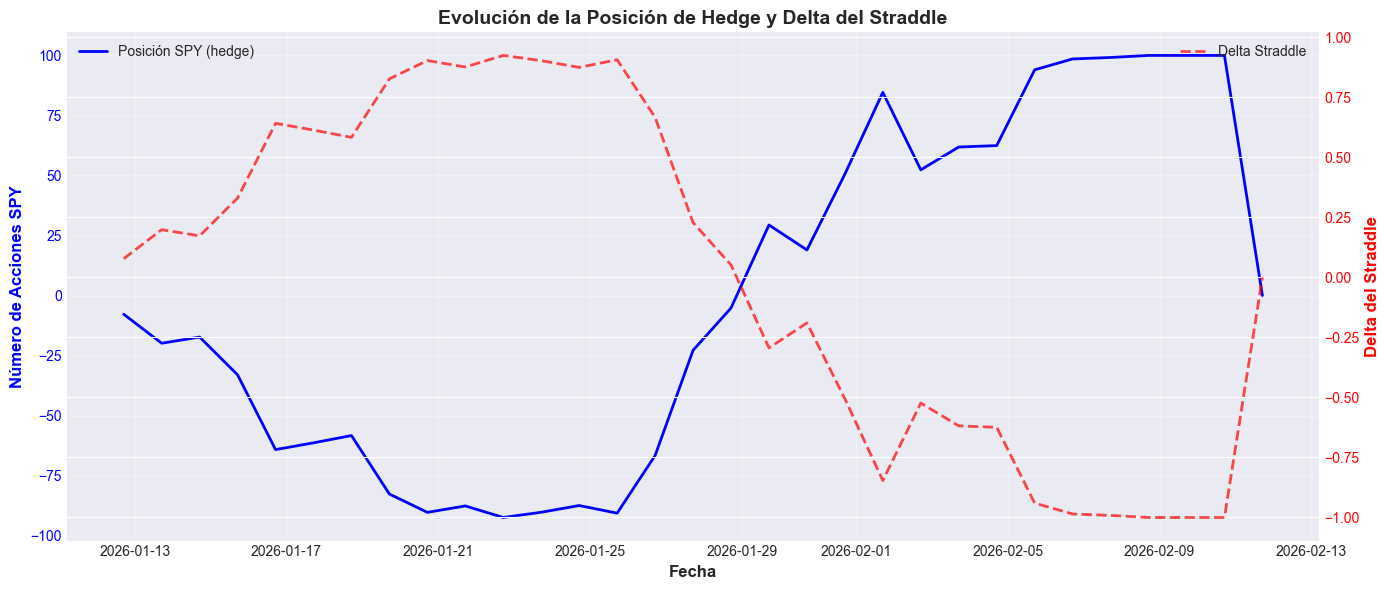

✓ Gráfico 1 guardado: Evolución de posición de hedge


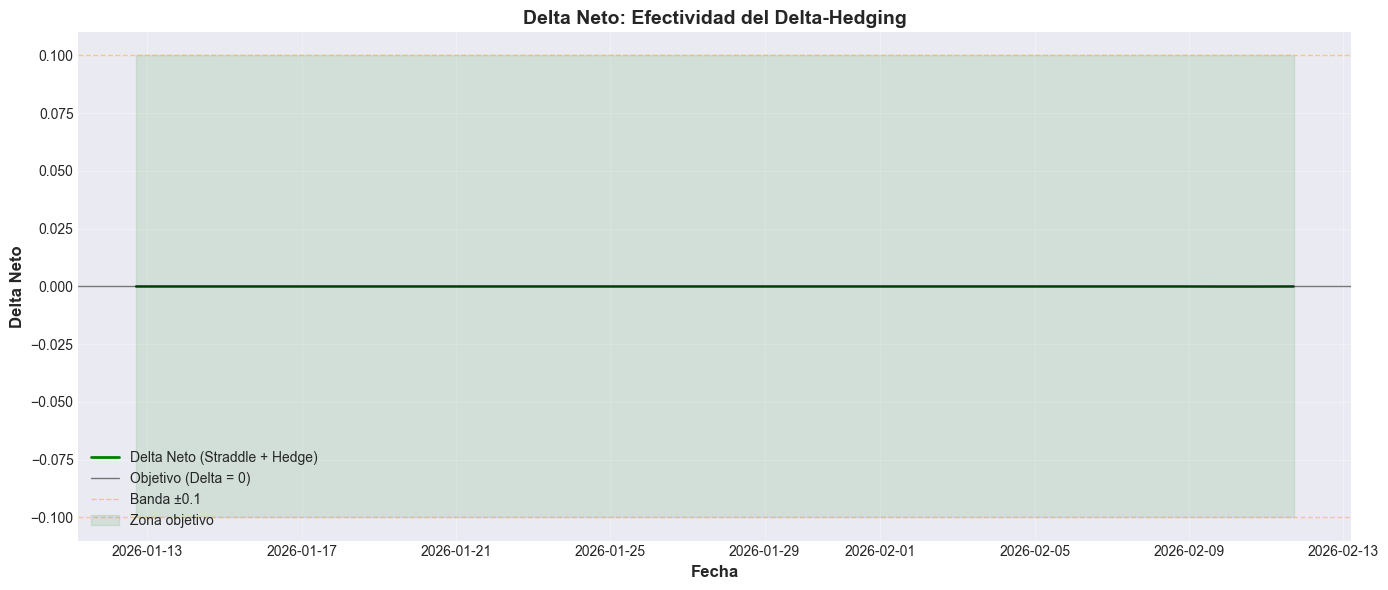

✓ Gráfico 2 guardado: Delta neto


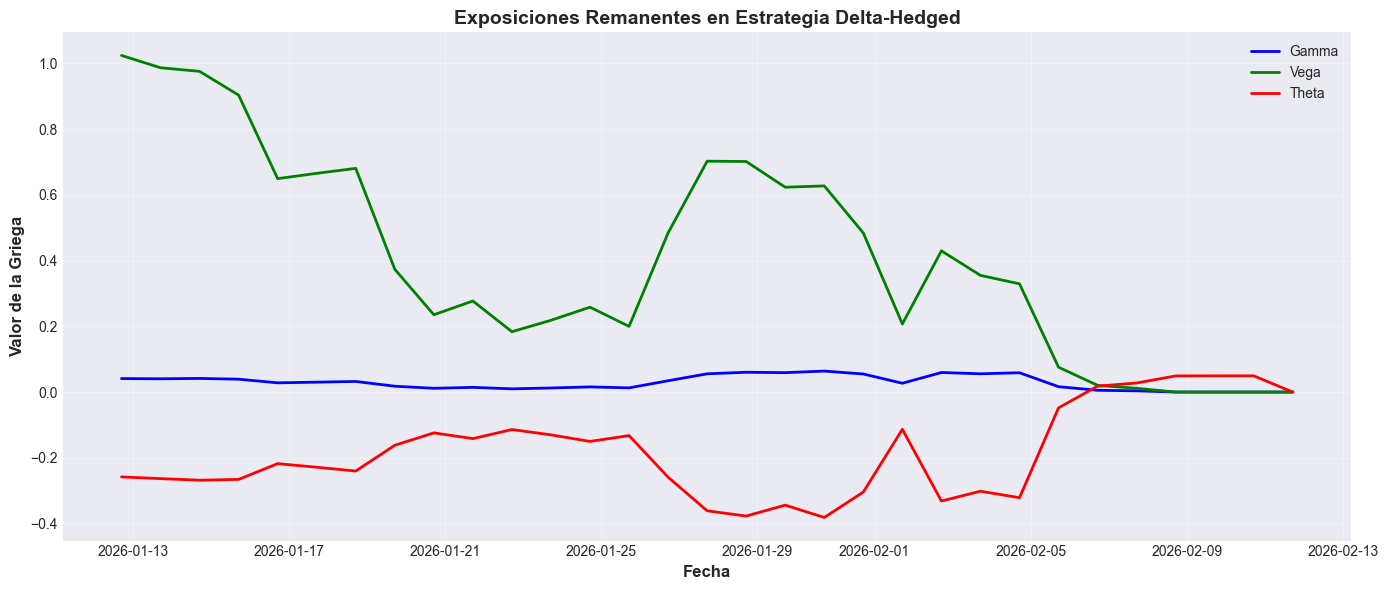

✓ Gráfico 3 guardado: Evolución de griegas

TABLA RESUMEN DE CASH FLOWS DEL HEDGING
     Fecha Acción Acciones Precio SPY  Cash Flow Cash Flow Acumulado
2026-01-12  Venta    -7.80    $450.00   $3511.36            $3511.36
2026-01-13  Venta   -12.08    $452.97   $5471.57            $8982.93
2026-01-14 Compra     2.58    $452.32  $-1165.81            $7817.13
2026-01-15  Venta   -15.76    $456.17   $7187.46           $15004.59
2026-01-16  Venta   -31.12    $465.16  $14476.31           $29480.90
2026-01-17 Compra     2.81    $463.94  $-1303.30           $28177.60
2026-01-18 Compra     3.04    $462.72  $-1407.55           $26770.04
2026-01-19  Venta   -24.37    $472.17  $11507.99           $38278.04
2026-01-20  Venta    -7.62    $476.90   $3633.81           $41911.84
2026-01-21 Compra     2.67    $474.24  $-1266.72           $40645.13
2026-01-22  Venta    -4.81    $477.65   $2297.01           $42942.13
2026-01-23 Compra     2.18    $475.02  $-1033.43           $41908.70
2026-01-24 Compra  

In [14]:
# Visualizaciones del delta-hedging

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import os

# Crear directorio para imágenes si no existe
os.makedirs('images/pnl_analysis', exist_ok=True)

# Usar el resultado del ejemplo anterior, si no existe ejecutar ejemplo básico
try:
    # Verificar si resultado_hedge existe en el namespace global
    resultado_hedge
except NameError:
    # Si no existe, ejecutar ejemplo básico
    straddle_info = construir_long_straddle(ticker='SPY', dias_vencimiento=30)
    fecha_inicio = straddle_info['fecha']
    fecha_fin = straddle_info['vencimiento']
    precio_inicial = straddle_info['precio_subyacente']
    dias_totales = (fecha_fin - fecha_inicio).days
    fechas = [fecha_inicio + timedelta(days=i) for i in range(dias_totales + 1)]
    np.random.seed(42)
    dt = 1/252
    mu = 0.08
    sigma_sim = 0.20
    precios = [precio_inicial]
    for i in range(dias_totales):
        cambio = np.random.normal(mu * dt, sigma_sim * np.sqrt(dt))
        nuevo_precio = precios[-1] * np.exp(cambio)
        precios.append(nuevo_precio)
    precios_historicos_spy = pd.DataFrame({
        'fecha': fechas,
        'close': precios
    })
    resultado_hedge = aplicar_delta_hedge(straddle_info, precios_historicos_spy, frecuencia='diaria')

historial = resultado_hedge['historial_rebalanceos']

# Gráfico 1: Posición de hedge y delta del straddle
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax1.set_ylabel('Número de Acciones SPY', fontsize=12, fontweight='bold', color='blue')
ax1.plot(historial['fecha'], historial['posicion_spy_total'], 'b-', linewidth=2, label='Posición SPY (hedge)')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.set_ylabel('Delta del Straddle', fontsize=12, fontweight='bold', color='red')
ax2.plot(historial['fecha'], historial['delta_straddle'], 'r--', linewidth=2, alpha=0.7, label='Delta Straddle')
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_title('Evolución de la Posición de Hedge y Delta del Straddle', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig('images/pnl_analysis/delta_hedging_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Gráfico 1 guardado: Evolución de posición de hedge")

# Gráfico 2: Delta neto
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(historial['fecha'], historial['delta_neto'], 'g-', linewidth=2, label='Delta Neto (Straddle + Hedge)')
ax.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5, label='Objetivo (Delta = 0)')
ax.axhline(0.1, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Banda ±0.1')
ax.axhline(-0.1, color='orange', linestyle='--', linewidth=1, alpha=0.5)
ax.fill_between(historial['fecha'], -0.1, 0.1, alpha=0.1, color='green', label='Zona objetivo')

ax.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax.set_ylabel('Delta Neto', fontsize=12, fontweight='bold')
ax.set_title('Delta Neto: Efectividad del Delta-Hedging', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/pnl_analysis/delta_neto_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Gráfico 2 guardado: Delta neto")

# Gráfico 3: Evolución de griegas que NO se cubren
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(historial['fecha'], historial['gamma'], 'b-', linewidth=2, label='Gamma')
ax.plot(historial['fecha'], historial['vega'], 'g-', linewidth=2, label='Vega')
ax.plot(historial['fecha'], historial['theta'], 'r-', linewidth=2, label='Theta')

ax.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax.set_ylabel('Valor de la Griega', fontsize=12, fontweight='bold')
ax.set_title('Exposiciones Remanentes en Estrategia Delta-Hedged', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/pnl_analysis/greeks_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Gráfico 3 guardado: Evolución de griegas")

# Tabla resumen de cash flows
print(f"\n{'='*60}")
print(f"TABLA RESUMEN DE CASH FLOWS DEL HEDGING")
print(f"{'='*60}")

rebalanceos_con_cashflow = historial[historial['acciones_operadas'] != 0].copy()
rebalanceos_con_cashflow['accion'] = rebalanceos_con_cashflow['acciones_operadas'].apply(
    lambda x: 'Compra' if x > 0 else 'Venta'
)
rebalanceos_con_cashflow['cash_flow_acumulado'] = rebalanceos_con_cashflow['cash_flow'].cumsum()

tabla_cashflow = pd.DataFrame({
    'Fecha': rebalanceos_con_cashflow['fecha'].dt.strftime('%Y-%m-%d'),
    'Acción': rebalanceos_con_cashflow['accion'],
    'Acciones': rebalanceos_con_cashflow['acciones_operadas'].apply(lambda x: f"{x:.2f}"),
    'Precio SPY': rebalanceos_con_cashflow['precio_spy'].apply(lambda x: f"${x:.2f}"),
    'Cash Flow': rebalanceos_con_cashflow['cash_flow'].apply(lambda x: f"${x:.2f}"),
    'Cash Flow Acumulado': rebalanceos_con_cashflow['cash_flow_acumulado'].apply(lambda x: f"${x:.2f}")
})

print(tabla_cashflow.to_string(index=False))
print(f"{'='*60}\n")


### 2.4. Conceptos Clave del Delta-Hedging

#### ¿Por qué delta-hedging NO elimina todo el riesgo?

Delta es solo la sensibilidad de primer orden (derivada primera). Gamma (segunda derivada) causa que delta cambie, por lo que siempre tenemos error de cobertura. Entre rebalanceos, acumulamos exposición a movimientos. Además, Vega nos expone a cambios en volatilidad implícita, y Theta nos hace perder dinero cada día que pasa.

#### ¿Qué riesgos quedan después de neutralizar delta?

1. **Riesgo de Gamma**: Beneficio de movimientos grandes, pérdida si el mercado no se mueve
2. **Riesgo de Vega**: Beneficio si IV sube, pérdida si IV baja
3. **Riesgo de Theta**: Pérdida constante por el paso del tiempo
4. **Riesgo de modelo**: Nuestras griegas de Black-Scholes pueden ser incorrectas
5. **Riesgo de ejecución**: No siempre podemos rebalancear al precio exacto
6. **Riesgo de gap**: Movimientos durante el cierre del mercado

#### Gamma scalping implícito

Cada rebalanceo es una operación de gamma scalping:
- Vendemos acciones cuando el mercado sube (realizamos beneficio del call)
- Compramos acciones cuando el mercado baja (realizamos beneficio del put)
- El beneficio acumulado de gamma scalping debe superar el theta decay para ganar dinero
- Fórmula aproximada: P&L ≈ 0.5 × Gamma × (ΔS)² - Theta × Δt

En mercados volátiles con muchos movimientos, el gamma scalping puede generar beneficios significativos que compensan el theta decay. En mercados tranquilos, el theta decay domina y la estrategia pierde dinero.


## 3. Análisis de P&L Histórico: Expuesta vs Delta-Hedged

Este objetivo realiza un análisis exhaustivo y comparativo del P&L histórico entre dos versiones de la estrategia Long Straddle:
1. Versión EXPUESTA (sin cobertura delta)
2. Versión DELTA-HEDGED (con rebalanceo diario)

El análisis cubre desde el momento de lanzamiento del straddle hasta su vencimiento, incluyendo métricas de rendimiento, análisis de riesgo, descomposición de P&L por griegas, y visualizaciones comparativas que permiten entender las diferencias fundamentales entre ambas aproximaciones.



### 3.1. Función Principal: calcular_pnl_sin_hedge

Esta función calcula el P&L histórico de la versión EXPUESTA del straddle (sin cobertura delta). Para cada día desde la construcción hasta el vencimiento:

- Actualiza información temporal (días restantes hasta vencimiento)
- Calcula precios teóricos actuales usando Black-Scholes propio
- Calcula griegas actuales (Delta, Gamma, Theta, Vega)
- Calcula P&L mark-to-market (diario y acumulado)
- Descompone P&L diario por contribución de cada griega (aproximación de Taylor)
- Registra toda la información en un DataFrame para análisis posterior

La función retorna un DataFrame con el historial completo y un diccionario con métricas finales agregadas.

In [15]:
# Implementación: Función calcular_pnl_sin_hedge

def calcular_pnl_sin_hedge(info_straddle, precios_historicos_spy, volatilidades_historicas=None):
    """
    Calcula el P&L histórico de la versión EXPUESTA del straddle (sin cobertura delta).
    
    Para cada día desde la construcción hasta el vencimiento, esta función:
    1. Actualiza información temporal (días restantes)
    2. Calcula precios teóricos actuales usando Black-Scholes
    3. Calcula griegas actuales
    4. Calcula P&L mark-to-market
    5. Descompone P&L diario por contribución de cada griega
    
    Args:
        info_straddle: Diccionario retornado por construir_long_straddle
        precios_historicos_spy: DataFrame con precios diarios de SPY
            Columnas requeridas: fecha (o índice datetime), close (precio de cierre)
        volatilidades_historicas: Series con IV histórica (opcional)
            Si None, usa volatilidad constante del straddle inicial
    
    Returns:
        Diccionario con:
            - historial: DataFrame con todo el historial diario
            - metricas: diccionario con métricas finales agregadas
    """
    import pandas as pd
    import numpy as np
    from datetime import datetime, timedelta
    
    # Obtener parámetros del straddle
    fecha_inicial = info_straddle['fecha']
    precio_inicial_spy = info_straddle['precio_subyacente']
    strike = info_straddle['strike']
    vencimiento = info_straddle['vencimiento']
    inversion_inicial = info_straddle['inversion_inicial']
    
    # Obtener parámetros de mercado
    try:
        import __main__
        r = getattr(__main__, 'r', 0.05)
        q = getattr(__main__, 'q', 0.0)
        sigma_base = getattr(__main__, 'sigma', 0.15)
    except:
        r = 0.05
        q = 0.0
        sigma_base = 0.15
    
    # Preparar datos históricos de SPY
    if isinstance(precios_historicos_spy.index, pd.DatetimeIndex):
        df_spy = precios_historicos_spy.copy()
        df_spy['fecha'] = df_spy.index
    else:
        df_spy = precios_historicos_spy.copy()
        if 'fecha' not in df_spy.columns:
            df_spy['fecha'] = pd.to_datetime(df_spy.index)
    
    if 'close' not in df_spy.columns:
        if 'Close' in df_spy.columns:
            df_spy['close'] = df_spy['Close']
        else:
            raise ValueError("DataFrame debe tener columna 'close' o 'Close'")
    
    # Filtrar datos desde fecha inicial hasta vencimiento
    df_spy['fecha'] = pd.to_datetime(df_spy['fecha'])
    fecha_inicial_dt = pd.to_datetime(fecha_inicial)
    vencimiento_dt = pd.to_datetime(vencimiento)
    
    df_spy = df_spy[(df_spy['fecha'] >= fecha_inicial_dt) & (df_spy['fecha'] <= vencimiento_dt)]
    df_spy = df_spy.sort_values('fecha').reset_index(drop=True)
    
    if len(df_spy) == 0:
        raise ValueError(f"No hay datos históricos de SPY entre {fecha_inicial_dt} y {vencimiento_dt}")
    
    # Preparar volatilidades históricas
    if volatilidades_historicas is None:
        # Usar volatilidad constante
        volatilidades_historicas = pd.Series(index=df_spy['fecha'], data=sigma_base)
    else:
        volatilidades_historicas = pd.Series(volatilidades_historicas)
        volatilidades_historicas.index = pd.to_datetime(volatilidades_historicas.index)
    
    # Inicialización
    historial = []
    valor_straddle_anterior = inversion_inicial
    precio_spy_anterior = precio_inicial_spy
    iv_anterior = volatilidades_historicas.iloc[0] if len(volatilidades_historicas) > 0 else sigma_base
    
    # Para cada día de trading
    for idx, row in df_spy.iterrows():
        fecha_actual = row['fecha']
        precio_spy_actual = row['close']
        
        # Obtener IV actual (interpolación simple si no hay dato exacto)
        try:
            iv_actual = volatilidades_historicas.loc[fecha_actual]
        except KeyError:
            # Usar IV más cercana o constante
            iv_actual = iv_anterior
        
        # Calcular días hasta vencimiento
        dias_restantes = (vencimiento_dt - fecha_actual).days
        T_restante = max(dias_restantes / 365.0, 1/365.0)
        
        if dias_restantes > 0:
            # Calcular precios teóricos usando Black-Scholes
            precio_call_actual = bs_price(precio_spy_actual, strike, T_restante, r, q, iv_actual, 'C')
            precio_put_actual = bs_price(precio_spy_actual, strike, T_restante, r, q, iv_actual, 'P')
            valor_straddle_actual = precio_call_actual + precio_put_actual
            
            # Calcular griegas usando funciones propias
            griegas_call = bs_greeks_manual(precio_spy_actual, strike, T_restante, r, q, iv_actual, 'C')
            griegas_put = bs_greeks_manual(precio_spy_actual, strike, T_restante, r, q, iv_actual, 'P')
            
            delta_total = griegas_call['delta'] + griegas_put['delta']
            gamma_total = griegas_call['gamma'] + griegas_put['gamma']
            theta_total = griegas_call['theta'] + griegas_put['theta']
            vega_total = griegas_call['vega'] + griegas_put['vega']
        else:
            # En vencimiento, usar valor intrínseco
            precio_call_actual = max(precio_spy_actual - strike, 0)
            precio_put_actual = max(strike - precio_spy_actual, 0)
            valor_straddle_actual = precio_call_actual + precio_put_actual
            delta_total = 0.0
            gamma_total = 0.0
            theta_total = 0.0
            vega_total = 0.0
        
        # Calcular P&L
        pnl_acumulado = valor_straddle_actual - inversion_inicial
        pnl_diario = valor_straddle_actual - valor_straddle_anterior if idx > 0 else 0.0
        
        # Descomponer P&L diario por contribución de griegas (aproximación de Taylor)
        if idx > 0:
            delta_S = precio_spy_actual - precio_spy_anterior
            delta_sigma = iv_actual - iv_anterior
            delta_t = 1/365.0  # Un día
            
            # Contribución de cada griega (multiplicador de opciones = 100)
            contrib_delta = delta_total * delta_S * 100
            contrib_gamma = 0.5 * gamma_total * (delta_S ** 2) * 100
            # Theta ya está por día (dividido por 365 en bs_greeks_manual), 
            # por lo que multiplicamos por 100 para el multiplicador de opciones
            contrib_theta = theta_total * 100
            contrib_vega = vega_total * delta_sigma * 100
            
            pnl_explicado = contrib_delta + contrib_gamma + contrib_theta + contrib_vega
            residuo = pnl_diario - pnl_explicado
        else:
            contrib_delta = 0.0
            contrib_gamma = 0.0
            contrib_theta = 0.0
            contrib_vega = 0.0
            pnl_explicado = 0.0
            residuo = 0.0
        
        # Registrar en historial
        historial.append({
            'fecha': fecha_actual,
            'precio_spy': precio_spy_actual,
            'dias_restantes': dias_restantes,
            'iv': iv_actual,
            'valor_call': precio_call_actual,
            'valor_put': precio_put_actual,
            'valor_total_straddle': valor_straddle_actual,
            'delta': delta_total,
            'gamma': gamma_total,
            'theta': theta_total,
            'vega': vega_total,
            'pnl_diario': pnl_diario,
            'pnl_acumulado': pnl_acumulado,
            'contrib_delta': contrib_delta,
            'contrib_gamma': contrib_gamma,
            'contrib_theta': contrib_theta,
            'contrib_vega': contrib_vega,
            'pnl_explicado': pnl_explicado,
            'residuo': residuo
        })
        
        # Actualizar valores para siguiente iteración
        valor_straddle_anterior = valor_straddle_actual
        precio_spy_anterior = precio_spy_actual
        iv_anterior = iv_actual
    
    # Crear DataFrame con historial
    df_historial = pd.DataFrame(historial)
    
    # Calcular métricas finales
    metricas = {
        'pnl_final': df_historial['pnl_acumulado'].iloc[-1],
        'pnl_maximo': df_historial['pnl_acumulado'].max(),
        'pnl_minimo': df_historial['pnl_acumulado'].min(),
        'drawdown_maximo': ((df_historial['pnl_acumulado'].cummax() - df_historial['pnl_acumulado']).max() / 
                           df_historial['pnl_acumulado'].cummax().max() if df_historial['pnl_acumulado'].cummax().max() > 0 else 0),
        'volatilidad_pnl_diario': df_historial['pnl_diario'].std(),
        'contrib_total_delta': df_historial['contrib_delta'].sum(),
        'contrib_total_gamma': df_historial['contrib_gamma'].sum(),
        'contrib_total_theta': df_historial['contrib_theta'].sum(),
        'contrib_total_vega': df_historial['contrib_vega'].sum()
    }
    
    return {
        'historial': df_historial,
        'metricas': metricas
    }

### 3.2. Función Principal: calcular_pnl_con_hedge

Esta función calcula el P&L histórico de la versión DELTA-HEDGED del straddle usando el historial de rebalanceos retornado por `aplicar_delta_hedge`. Para cada día:

- Extrae información del historial de hedge (valor del straddle, posición en SPY, precios)
- Calcula P&L del straddle (mark-to-market)
- Calcula P&L del hedge (posiciones en SPY)
- Calcula P&L neto combinado
- Calcula cash flow acumulado de rebalanceos
- Registra toda la información en un DataFrame para análisis posterior

La función retorna un DataFrame con el historial completo y un diccionario con métricas finales agregadas.

In [16]:
# Implementación: Función calcular_pnl_con_hedge

def calcular_pnl_con_hedge(info_straddle, historial_hedge):
    """
    Calcula el P&L histórico de la versión DELTA-HEDGED del straddle.
    
    Usa el historial de rebalanceos retornado por aplicar_delta_hedge para calcular:
    - P&L del straddle (mark-to-market)
    - P&L del hedge (posiciones en SPY)
    - P&L neto combinado
    - Cash flow acumulado de rebalanceos
    
    Args:
        info_straddle: Diccionario retornado por construir_long_straddle
        historial_hedge: DataFrame retornado por aplicar_delta_hedge['historial_rebalanceos']
    
    Returns:
        Diccionario con:
            - historial: DataFrame con todo el historial diario
            - metricas: diccionario con métricas finales agregadas
    """
    import pandas as pd
    import numpy as np
    
    inversion_inicial = info_straddle['inversion_inicial']
    df_hedge = historial_hedge.copy()
    
    # Asegurar que tenemos las columnas necesarias
    required_cols = ['fecha', 'precio_spy', 'valor_straddle', 'posicion_spy_total', 
                     'cash_flow', 'pnl_straddle', 'pnl_hedge', 'pnl_total']
    for col in required_cols:
        if col not in df_hedge.columns:
            raise ValueError(f"DataFrame de hedge debe tener columna '{col}'")
    
    # Ordenar por fecha
    df_hedge = df_hedge.sort_values('fecha').reset_index(drop=True)
    
    # Inicialización
    historial = []
    cash_flow_acumulado = 0.0
    
    # Para cada día del historial de hedge
    for idx, row in df_hedge.iterrows():
        fecha = row['fecha']
        precio_spy = row['precio_spy']
        valor_straddle = row['valor_straddle']
        posicion_spy = row['posicion_spy_total']
        cash_flow_diario = row['cash_flow']
        
        # Actualizar cash flow acumulado
        cash_flow_acumulado += cash_flow_diario
        
        # Calcular valor actual de la posición en SPY
        valor_posicion_spy = posicion_spy * precio_spy
        
        # Calcular P&L del straddle
        pnl_straddle_acum = valor_straddle - inversion_inicial
        pnl_straddle_diario = row['pnl_straddle'] if idx > 0 else 0.0
        
        # Calcular P&L del hedge
        # P&L del hedge = valor actual de posición - cash flow acumulado
        pnl_hedge_acum = valor_posicion_spy - cash_flow_acumulado
        pnl_hedge_diario = row['pnl_hedge'] if idx > 0 else 0.0
        
        # Calcular P&L neto combinado
        pnl_neto_diario = pnl_straddle_diario + pnl_hedge_diario
        pnl_neto_acum = pnl_straddle_acum + pnl_hedge_acum
        
        # Registrar en historial
        historial.append({
            'fecha': fecha,
            'precio_spy': precio_spy,
            'valor_straddle': valor_straddle,
            'posicion_spy': posicion_spy,
            'valor_posicion_spy': valor_posicion_spy,
            'pnl_straddle_diario': pnl_straddle_diario,
            'pnl_straddle_acum': pnl_straddle_acum,
            'pnl_hedge_diario': pnl_hedge_diario,
            'pnl_hedge_acum': pnl_hedge_acum,
            'pnl_neto_diario': pnl_neto_diario,
            'pnl_neto_acum': pnl_neto_acum,
            'cash_flow_rebalanceo': cash_flow_diario,
            'cash_flow_acumulado': cash_flow_acumulado
        })
    
    # Crear DataFrame con historial
    df_historial = pd.DataFrame(historial)
    
    # Calcular métricas finales
    metricas = {
        'pnl_final': df_historial['pnl_neto_acum'].iloc[-1],
        'pnl_maximo': df_historial['pnl_neto_acum'].max(),
        'pnl_minimo': df_historial['pnl_neto_acum'].min(),
        'drawdown_maximo': ((df_historial['pnl_neto_acum'].cummax() - df_historial['pnl_neto_acum']).max() / 
                           df_historial['pnl_neto_acum'].cummax().max() if df_historial['pnl_neto_acum'].cummax().max() > 0 else 0),
        'volatilidad_pnl_diario': df_historial['pnl_neto_diario'].std(),
        'pnl_straddle_final': df_historial['pnl_straddle_acum'].iloc[-1],
        'pnl_hedge_final': df_historial['pnl_hedge_acum'].iloc[-1],
        'cash_flow_total': cash_flow_acumulado
    }
    
    return {
        'historial': df_historial,
        'metricas': metricas
    }

### 3.3. Función de Análisis Comparativo: comparar_estrategias

Esta función realiza un análisis comparativo exhaustivo entre las dos versiones de la estrategia, calculando:

- Métricas de rendimiento (P&L final, retorno porcentual, volatilidad, Sharpe ratio, drawdown máximo)
- Métricas de comportamiento (tasa de días ganadores, P&L medio en días ganadores/perdedores, ratio ganancia/pérdida)
- Análisis de escenarios de mercado (mercado alcista/bajista/lateral, alta/baja volatilidad, IV aumentando/disminuyendo)

La función retorna un DataFrame comparativo con todas las métricas y un diccionario con análisis por escenarios.

In [17]:
# Implementación: Función comparar_estrategias

def comparar_estrategias(pnl_sin_hedge, pnl_con_hedge, info_straddle):
    """
    Compara métricas de rendimiento entre las dos versiones de la estrategia.
    
    Calcula métricas de rendimiento, comportamiento, y análisis por escenarios de mercado.
    
    Args:
        pnl_sin_hedge: Diccionario retornado por calcular_pnl_sin_hedge
        pnl_con_hedge: Diccionario retornado por calcular_pnl_con_hedge
        info_straddle: Diccionario retornado por construir_long_straddle
    
    Returns:
        Diccionario con:
            - metricas_comparativas: DataFrame con métricas comparativas
            - analisis_escenarios: diccionario con análisis por escenarios
    """
    import pandas as pd
    import numpy as np
    
    inversion_inicial = info_straddle['inversion_inicial']
    
    df_sin_hedge = pnl_sin_hedge['historial']
    df_con_hedge = pnl_con_hedge['historial']
    
    # Calcular métricas para estrategia sin hedge
    pnl_final_sin = df_sin_hedge['pnl_acumulado'].iloc[-1]
    retorno_sin = (pnl_final_sin / inversion_inicial) * 100
    pnl_max_sin = df_sin_hedge['pnl_acumulado'].max()
    pnl_min_sin = df_sin_hedge['pnl_acumulado'].min()
    peak_sin = df_sin_hedge['pnl_acumulado'].cummax()
    drawdown_sin = ((peak_sin - df_sin_hedge['pnl_acumulado']) / peak_sin.max() * 100).max() if peak_sin.max() > 0 else 0
    volatilidad_sin = df_sin_hedge['pnl_diario'].std()
    sharpe_sin = (df_sin_hedge['pnl_diario'].mean() / volatilidad_sin * np.sqrt(252)) if volatilidad_sin > 0 else 0
    dias_ganadores_sin = (df_sin_hedge['pnl_diario'] > 0).sum()
    tasa_ganadores_sin = (dias_ganadores_sin / len(df_sin_hedge)) * 100
    pnl_medio_ganador_sin = df_sin_hedge[df_sin_hedge['pnl_diario'] > 0]['pnl_diario'].mean() if dias_ganadores_sin > 0 else 0
    pnl_medio_perdedor_sin = df_sin_hedge[df_sin_hedge['pnl_diario'] < 0]['pnl_diario'].mean() if (df_sin_hedge['pnl_diario'] < 0).sum() > 0 else 0
    ratio_ganancia_perdida_sin = abs(pnl_medio_ganador_sin / pnl_medio_perdedor_sin) if pnl_medio_perdedor_sin != 0 else np.inf
    mejor_dia_sin = df_sin_hedge['pnl_diario'].max()
    peor_dia_sin = df_sin_hedge['pnl_diario'].min()
    
    # Calcular métricas para estrategia con hedge
    pnl_final_con = df_con_hedge['pnl_neto_acum'].iloc[-1]
    retorno_con = (pnl_final_con / inversion_inicial) * 100
    pnl_max_con = df_con_hedge['pnl_neto_acum'].max()
    pnl_min_con = df_con_hedge['pnl_neto_acum'].min()
    peak_con = df_con_hedge['pnl_neto_acum'].cummax()
    drawdown_con = ((peak_con - df_con_hedge['pnl_neto_acum']) / peak_con.max() * 100).max() if peak_con.max() > 0 else 0
    volatilidad_con = df_con_hedge['pnl_neto_diario'].std()
    sharpe_con = (df_con_hedge['pnl_neto_diario'].mean() / volatilidad_con * np.sqrt(252)) if volatilidad_con > 0 else 0
    dias_ganadores_con = (df_con_hedge['pnl_neto_diario'] > 0).sum()
    tasa_ganadores_con = (dias_ganadores_con / len(df_con_hedge)) * 100
    pnl_medio_ganador_con = df_con_hedge[df_con_hedge['pnl_neto_diario'] > 0]['pnl_neto_diario'].mean() if dias_ganadores_con > 0 else 0
    pnl_medio_perdedor_con = df_con_hedge[df_con_hedge['pnl_neto_diario'] < 0]['pnl_neto_diario'].mean() if (df_con_hedge['pnl_neto_diario'] < 0).sum() > 0 else 0
    ratio_ganancia_perdida_con = abs(pnl_medio_ganador_con / pnl_medio_perdedor_con) if pnl_medio_perdedor_con != 0 else np.inf
    mejor_dia_con = df_con_hedge['pnl_neto_diario'].max()
    peor_dia_con = df_con_hedge['pnl_neto_diario'].min()
    
    # Crear DataFrame comparativo
    metricas_comparativas = pd.DataFrame({
        'Métrica': [
            'P&L Final (USD)',
            'Retorno (%)',
            'P&L Máximo (USD)',
            'Volatilidad P&L Diario (USD)',
            'Sharpe Ratio',
            'Drawdown Máximo (%)',
            'Días Ganadores (%)',
            'P&L Medio Día Ganador (USD)',
            'P&L Medio Día Perdedor (USD)',
            'Ratio Ganancia/Pérdida',
            'Mejor Día (USD)',
            'Peor Día (USD)'
        ],
        'Sin Hedge': [
            pnl_final_sin,
            retorno_sin,
            pnl_max_sin,
            volatilidad_sin,
            sharpe_sin,
            drawdown_sin,
            tasa_ganadores_sin,
            pnl_medio_ganador_sin,
            pnl_medio_perdedor_sin,
            ratio_ganancia_perdida_sin,
            mejor_dia_sin,
            peor_dia_sin
        ],
        'Con Delta-Hedge': [
            pnl_final_con,
            retorno_con,
            pnl_max_con,
            volatilidad_con,
            sharpe_con,
            drawdown_con,
            tasa_ganadores_con,
            pnl_medio_ganador_con,
            pnl_medio_perdedor_con,
            ratio_ganancia_perdida_con,
            mejor_dia_con,
            peor_dia_con
        ]
    })
    
    metricas_comparativas['Diferencia'] = metricas_comparativas['Con Delta-Hedge'] - metricas_comparativas['Sin Hedge']
    
    # Análisis de escenarios (simplificado - se puede expandir)
    # Para un análisis completo, necesitaríamos datos adicionales de movimientos semanales, etc.
    analisis_escenarios = {
        'nota': 'Análisis de escenarios requiere datos adicionales de movimientos semanales y volatilidad realizada'
    }
    
    return {
        'metricas_comparativas': metricas_comparativas,
        'analisis_escenarios': analisis_escenarios
    }

### 3.4. Ejemplo de Uso

Esta celda demuestra cómo usar las funciones anteriores para calcular el P&L histórico de ambas versiones y realizar el análisis comparativo.

In [18]:
# Ejemplo de uso: Calcular P&L de ambas versiones

# Primero, construir un straddle
straddle_info = construir_long_straddle(ticker='SPY', dias_vencimiento=30)

# Crear datos históricos de SPY simulados (en producción, usar datos reales)
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

fecha_inicial = straddle_info['fecha']
vencimiento = straddle_info['vencimiento']
dias_totales = (vencimiento - fecha_inicial).days

# Simular precios históricos usando movimiento browniano geométrico
np.random.seed(42)
precio_inicial = straddle_info['precio_subyacente']
mu = 0.05 / 365  # Drift diario
sigma_sim = 0.15 / np.sqrt(365)  # Volatilidad diaria
dt = 1

fechas = [fecha_inicial + timedelta(days=i) for i in range(dias_totales + 1)]
precios = [precio_inicial]

for i in range(dias_totales):
    cambio = np.random.normal(mu * dt, sigma_sim * np.sqrt(dt))
    nuevo_precio = precios[-1] * np.exp(cambio)
    precios.append(nuevo_precio)

precios_historicos_spy = pd.DataFrame({
    'fecha': fechas,
    'close': precios
})

# Calcular P&L sin hedge
resultado_sin_hedge = calcular_pnl_sin_hedge(straddle_info, precios_historicos_spy)

# Calcular P&L con hedge (usar aplicar_delta_hedge primero)
from datetime import datetime
resultado_hedge = aplicar_delta_hedge(straddle_info, precios_historicos_spy, frecuencia='diaria')
resultado_con_hedge = calcular_pnl_con_hedge(straddle_info, resultado_hedge['historial_rebalanceos'])

# Comparar estrategias
comparacion = comparar_estrategias(resultado_sin_hedge, resultado_con_hedge, straddle_info)

print("Análisis completado exitosamente")
print(f"P&L Final Sin Hedge: ${resultado_sin_hedge['metricas']['pnl_final']:.2f}")
print(f"P&L Final Con Hedge: ${resultado_con_hedge['metricas']['pnl_final']:.2f}")

Análisis completado exitosamente
P&L Final Sin Hedge: $2.26
P&L Final Con Hedge: $269.14


### 3.5. Visualizaciones Comparativas

Las siguientes celdas crean visualizaciones comparativas que permiten entender las diferencias entre las dos versiones de la estrategia.

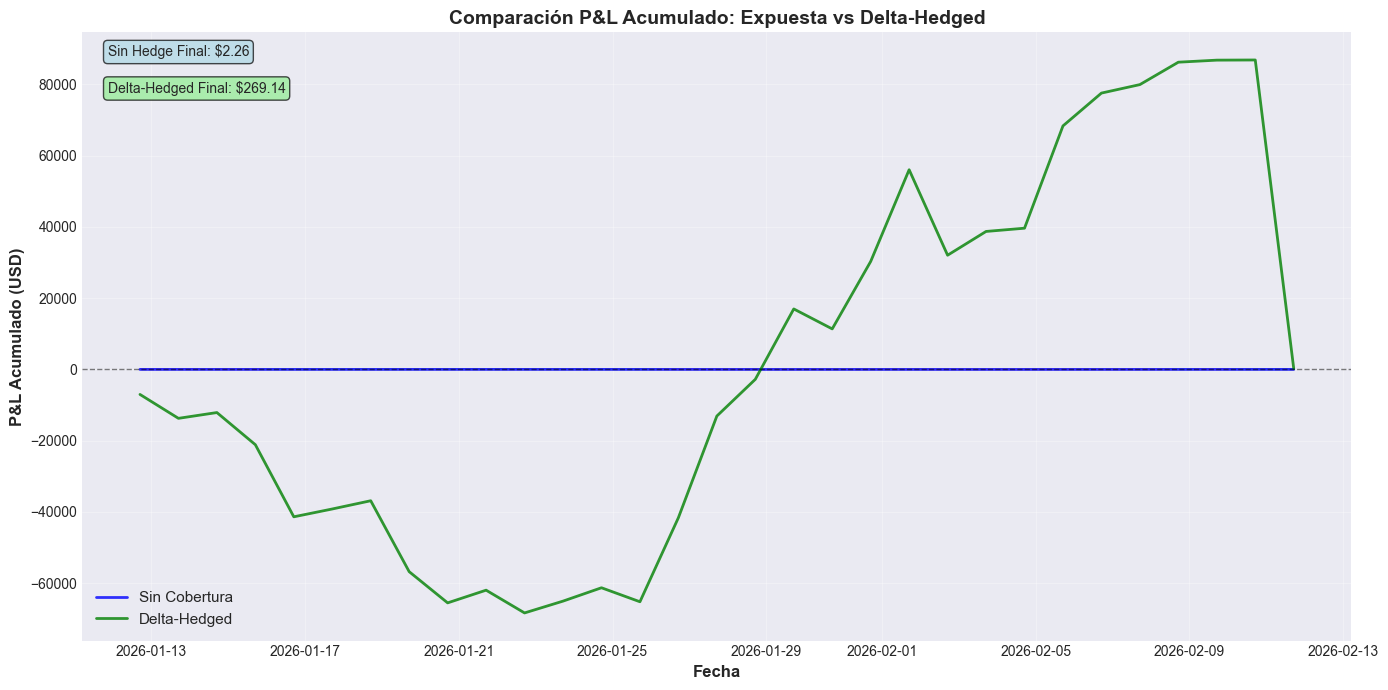

Gráfico 1 guardado: Comparación P&L Acumulado


In [19]:
# Gráfico 1: P&L acumulado comparativo

fig, ax = plt.subplots(figsize=(14, 7))

df_sin = resultado_sin_hedge['historial']
df_con = resultado_con_hedge['historial']

ax.plot(df_sin['fecha'], df_sin['pnl_acumulado'], 'b-', linewidth=2, label='Sin Cobertura', alpha=0.8)
ax.plot(df_con['fecha'], df_con['pnl_neto_acum'], 'g-', linewidth=2, label='Delta-Hedged', alpha=0.8)
ax.axhline(0, color='black', linestyle='--', alpha=0.5, linewidth=1)

# Sombrear zonas de pérdida vs ganancia
ax.fill_between(df_sin['fecha'], df_sin['pnl_acumulado'], 0, where=(df_sin['pnl_acumulado'] >= 0), 
                alpha=0.2, color='green', interpolate=True)
ax.fill_between(df_sin['fecha'], df_sin['pnl_acumulado'], 0, where=(df_sin['pnl_acumulado'] < 0), 
                alpha=0.2, color='red', interpolate=True)

ax.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax.set_ylabel('P&L Acumulado (USD)', fontsize=12, fontweight='bold')
ax.set_title('Comparación P&L Acumulado: Expuesta vs Delta-Hedged', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

# Anotar P&L final
pnl_final_sin = df_sin['pnl_acumulado'].iloc[-1]
pnl_final_con = df_con['pnl_neto_acum'].iloc[-1]
ax.text(0.02, 0.98, f'Sin Hedge Final: ${pnl_final_sin:.2f}', transform=ax.transAxes, 
        fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
ax.text(0.02, 0.92, f'Delta-Hedged Final: ${pnl_final_con:.2f}', transform=ax.transAxes, 
        fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

plt.tight_layout()
plt.savefig('images/pnl_analysis/straddle_hedged_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Gráfico 1 guardado: Comparación P&L Acumulado")

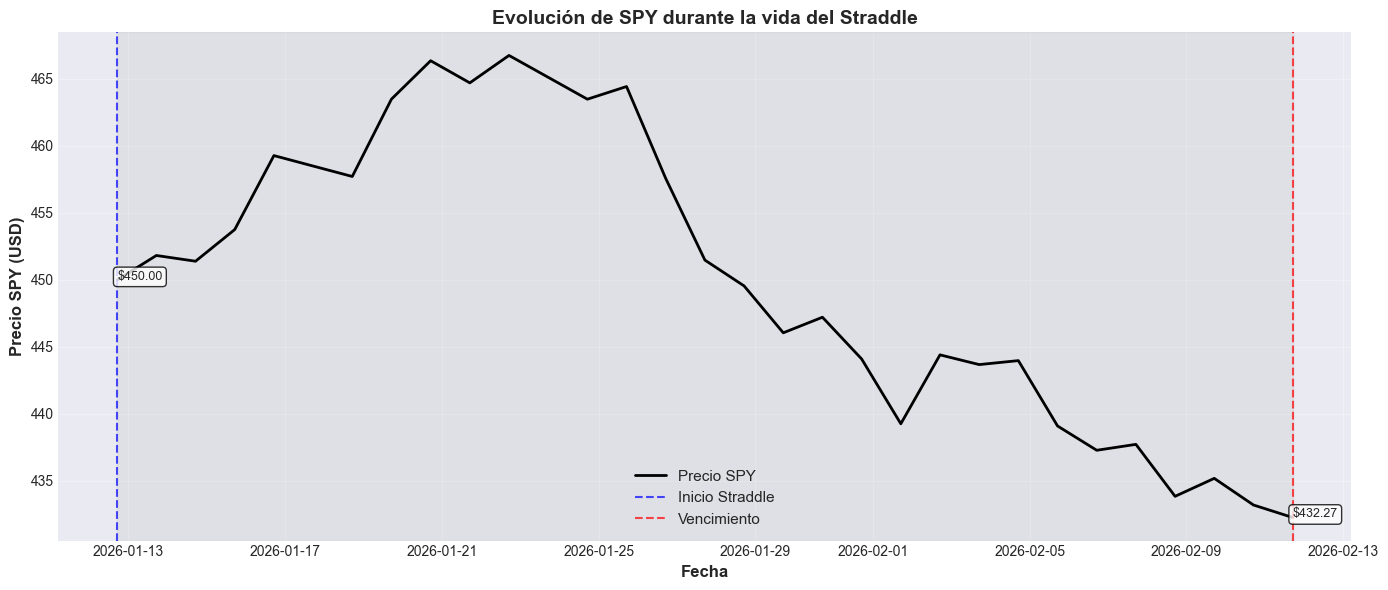

Gráfico 2 guardado: Evolución de SPY


In [20]:
# Gráfico 2: Evolución del precio de SPY

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df_sin['fecha'], df_sin['precio_spy'], 'k-', linewidth=2, label='Precio SPY')

# Marcar fecha de inicio y vencimiento
ax.axvline(straddle_info['fecha'], color='blue', linestyle='--', alpha=0.7, linewidth=1.5, label='Inicio Straddle')
ax.axvline(straddle_info['vencimiento'], color='red', linestyle='--', alpha=0.7, linewidth=1.5, label='Vencimiento')

# Sombrear zona entre inicio y vencimiento
ax.axvspan(straddle_info['fecha'], straddle_info['vencimiento'], alpha=0.1, color='gray')

# Anotar precio inicial y final
precio_inicial = df_sin['precio_spy'].iloc[0]
precio_final = df_sin['precio_spy'].iloc[-1]
ax.text(straddle_info['fecha'], precio_inicial, f'${precio_inicial:.2f}', 
        fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax.text(straddle_info['vencimiento'], precio_final, f'${precio_final:.2f}', 
        fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax.set_ylabel('Precio SPY (USD)', fontsize=12, fontweight='bold')
ax.set_title('Evolución de SPY durante la vida del Straddle', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/pnl_analysis/spy_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Gráfico 2 guardado: Evolución de SPY")

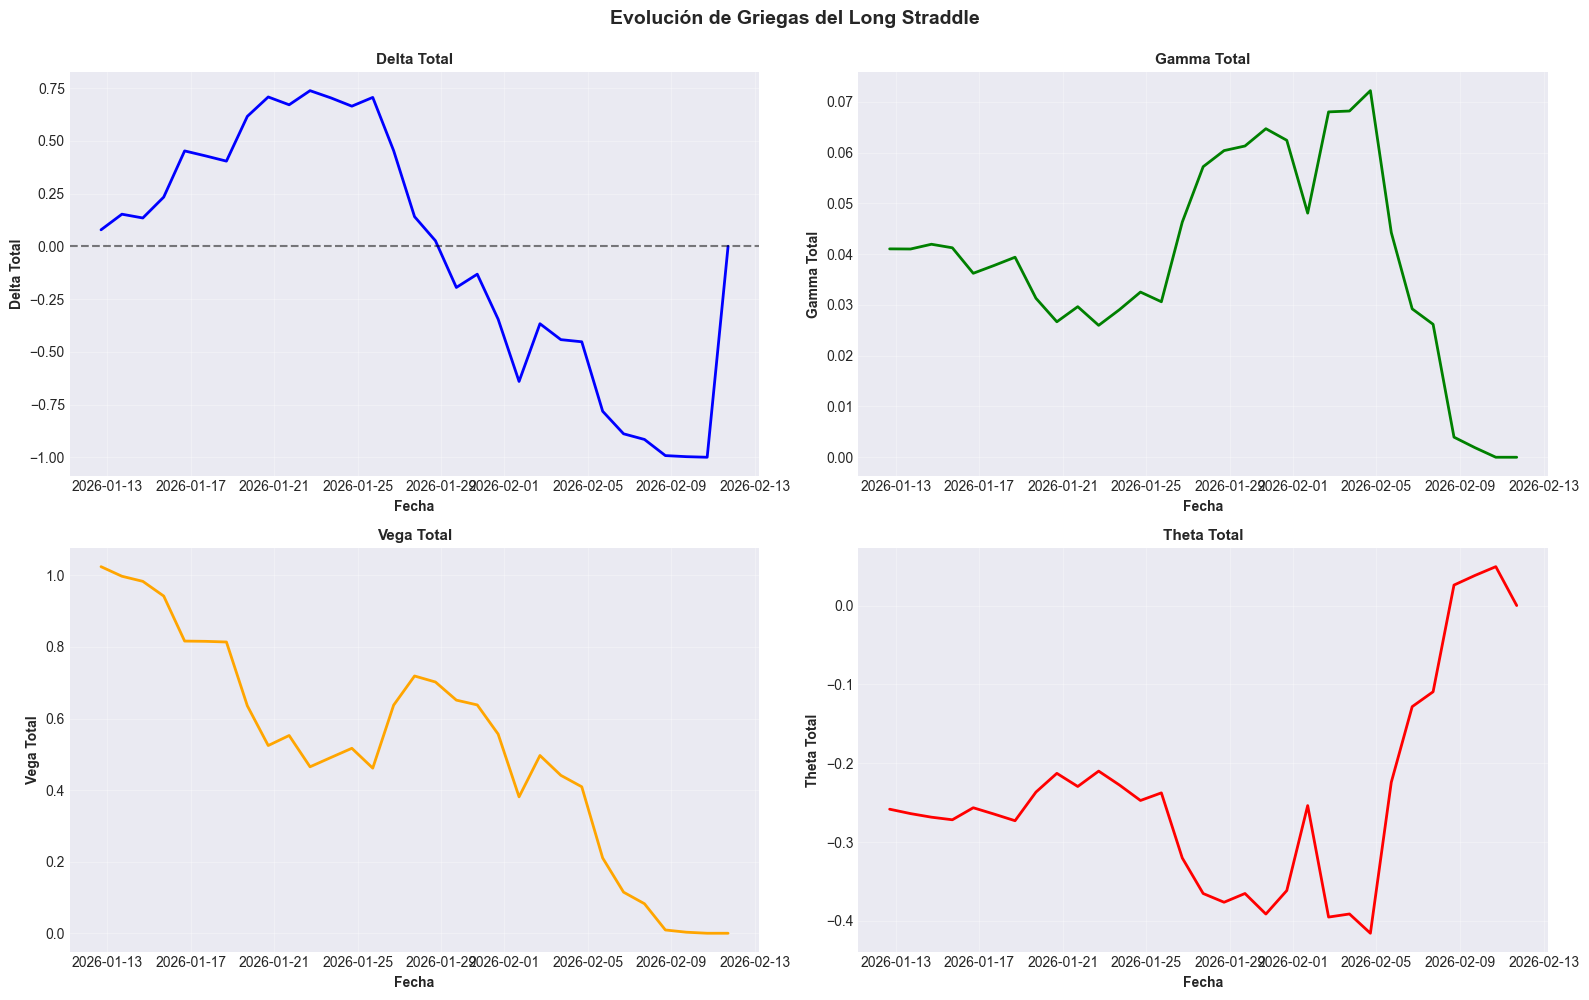

Gráfico 3 guardado: Evolución de Griegas


In [21]:
# Gráfico 3: Evolución temporal de griegas del straddle (versión sin hedge)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

griegas = ['delta', 'gamma', 'vega', 'theta']
titulos = ['Delta Total', 'Gamma Total', 'Vega Total', 'Theta Total']
colores = ['blue', 'green', 'orange', 'red']

for idx, (griega, titulo, color) in enumerate(zip(griegas, titulos, colores)):
    ax = axes[idx]
    ax.plot(df_sin['fecha'], df_sin[griega], color=color, linewidth=2)
    
    if griega == 'delta':
        ax.axhline(0, color='black', linestyle='--', alpha=0.5)
    
    ax.set_xlabel('Fecha', fontsize=10, fontweight='bold')
    ax.set_ylabel(titulo, fontsize=10, fontweight='bold')
    ax.set_title(titulo, fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.suptitle('Evolución de Griegas del Long Straddle', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('images/pnl_analysis/greeks_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Gráfico 3 guardado: Evolución de Griegas")

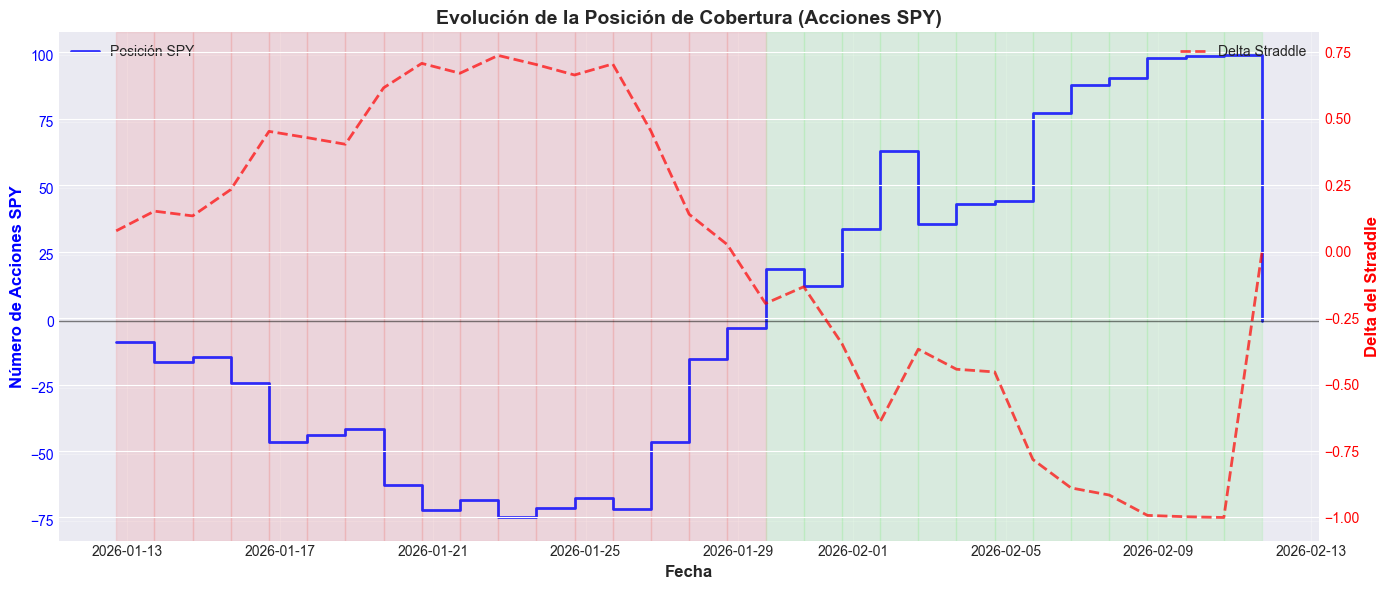

Gráfico 4 guardado: Posición de Hedge


In [22]:
# Gráfico 4: Posición de hedge en el tiempo

fig, ax1 = plt.subplots(figsize=(14, 6))

# Posición de SPY (step plot)
historial_hedge = resultado_hedge['historial_rebalanceos']
ax1.step(historial_hedge['fecha'], historial_hedge['posicion_spy_total'], 
         where='post', color='blue', linewidth=2, label='Posición SPY', alpha=0.8)
ax1.axhline(0, color='black', linestyle='-', alpha=0.5, linewidth=1)

# Colorear fondo: verde cuando posición long, rojo cuando short
for i in range(len(historial_hedge) - 1):
    fecha_ini = historial_hedge['fecha'].iloc[i]
    fecha_fin = historial_hedge['fecha'].iloc[i + 1]
    pos = historial_hedge['posicion_spy_total'].iloc[i]
    color = 'lightgreen' if pos > 0 else 'lightcoral'
    ax1.axvspan(fecha_ini, fecha_fin, alpha=0.2, color=color)

ax1.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax1.set_ylabel('Número de Acciones SPY', fontsize=12, fontweight='bold', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, alpha=0.3)

# Eje Y secundario: delta del straddle
ax2 = ax1.twinx()
ax2.plot(historial_hedge['fecha'], historial_hedge['delta_straddle'], 
         'r--', linewidth=2, alpha=0.7, label='Delta Straddle')
ax2.set_ylabel('Delta del Straddle', fontsize=12, fontweight='bold', color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_title('Evolución de la Posición de Cobertura (Acciones SPY)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('images/pnl_analysis/hedge_position.png', dpi=300, bbox_inches='tight')
plt.show()

print("Gráfico 4 guardado: Posición de Hedge")

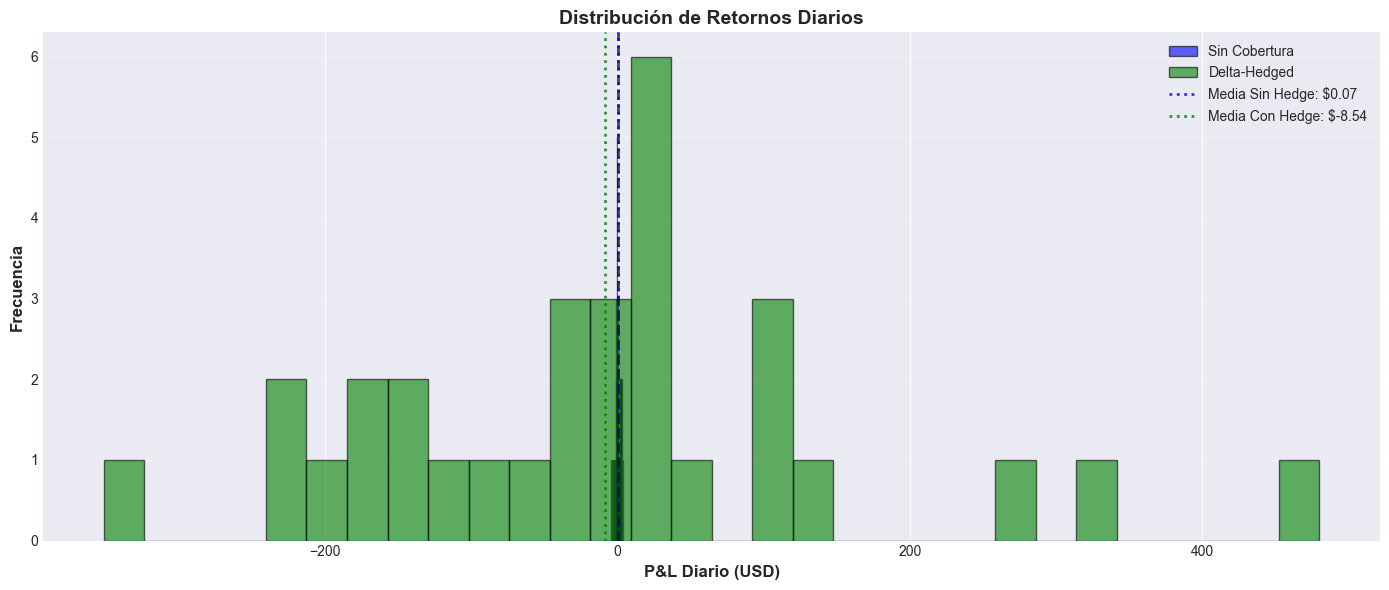

Gráfico 5 guardado: Distribución de P&L Diario


In [23]:
# Gráfico 5: Distribución de P&L diario

fig, ax = plt.subplots(figsize=(14, 6))

# Histogramas superpuestos
ax.hist(df_sin['pnl_diario'], bins=30, alpha=0.6, color='blue', label='Sin Cobertura', edgecolor='black')
ax.hist(df_con['pnl_neto_diario'], bins=30, alpha=0.6, color='green', label='Delta-Hedged', edgecolor='black')

ax.axvline(0, color='black', linestyle='--', linewidth=2, alpha=0.7)

# Mostrar media y mediana
media_sin = df_sin['pnl_diario'].mean()
mediana_sin = df_sin['pnl_diario'].median()
media_con = df_con['pnl_neto_diario'].mean()
mediana_con = df_con['pnl_neto_diario'].median()

ax.axvline(media_sin, color='blue', linestyle=':', linewidth=2, alpha=0.8, label=f'Media Sin Hedge: ${media_sin:.2f}')
ax.axvline(media_con, color='green', linestyle=':', linewidth=2, alpha=0.8, label=f'Media Con Hedge: ${media_con:.2f}')

ax.set_xlabel('P&L Diario (USD)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
ax.set_title('Distribución de Retornos Diarios', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('images/pnl_analysis/pnl_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Gráfico 5 guardado: Distribución de P&L Diario")

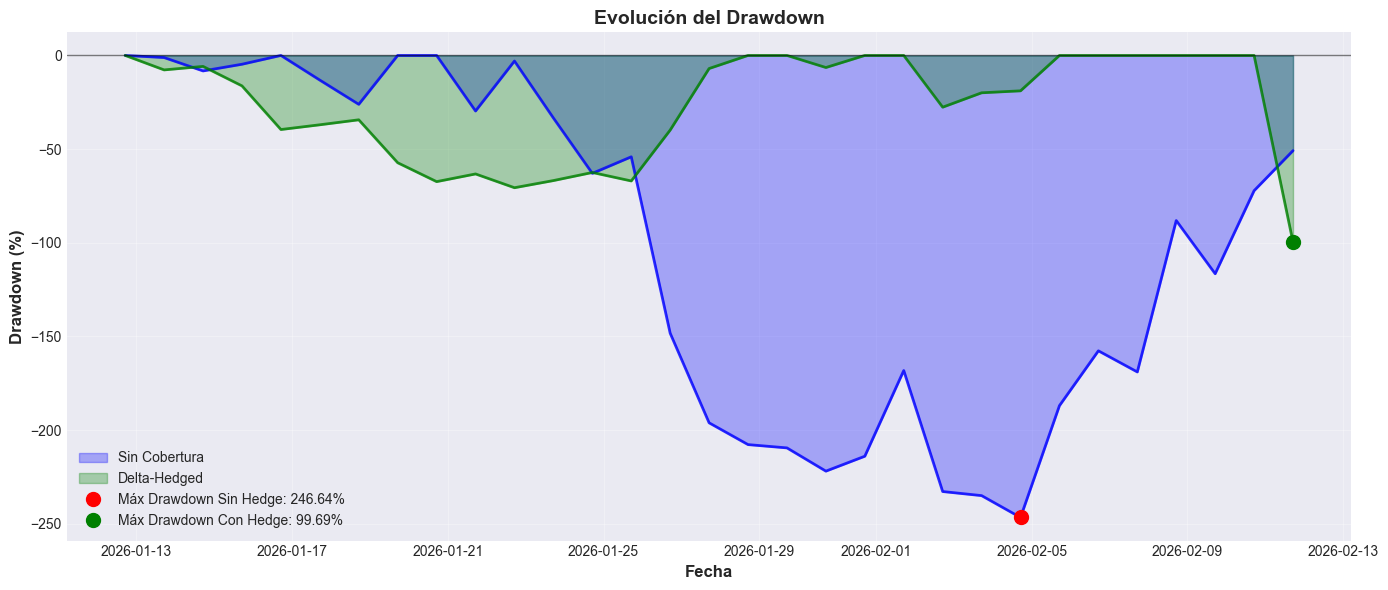

Gráfico 6 guardado: Análisis de Drawdown


In [24]:
# Gráfico 6: Drawdown analysis

fig, ax = plt.subplots(figsize=(14, 6))

# Calcular drawdown para cada estrategia
peak_sin = df_sin['pnl_acumulado'].cummax()
drawdown_sin = ((peak_sin - df_sin['pnl_acumulado']) / peak_sin.max() * 100)

peak_con = df_con['pnl_neto_acum'].cummax()
drawdown_con = ((peak_con - df_con['pnl_neto_acum']) / peak_con.max() * 100) if peak_con.max() > 0 else pd.Series(0, index=df_con.index)

ax.fill_between(df_sin['fecha'], -drawdown_sin, 0, alpha=0.3, color='blue', label='Sin Cobertura')
ax.fill_between(df_con['fecha'], -drawdown_con, 0, alpha=0.3, color='green', label='Delta-Hedged')
ax.plot(df_sin['fecha'], -drawdown_sin, 'b-', linewidth=2, alpha=0.8)
ax.plot(df_con['fecha'], -drawdown_con, 'g-', linewidth=2, alpha=0.8)

# Marcar máximo drawdown
max_dd_sin = drawdown_sin.max()
max_dd_con = drawdown_con.max()
idx_max_dd_sin = drawdown_sin.idxmax()
idx_max_dd_con = drawdown_con.idxmax()

ax.plot(df_sin['fecha'].iloc[idx_max_dd_sin], -max_dd_sin, 'ro', markersize=10, 
        label=f'Máx Drawdown Sin Hedge: {max_dd_sin:.2f}%')
ax.plot(df_con['fecha'].iloc[idx_max_dd_con], -max_dd_con, 'go', markersize=10, 
        label=f'Máx Drawdown Con Hedge: {max_dd_con:.2f}%')

ax.axhline(0, color='black', linestyle='-', alpha=0.5, linewidth=1)

ax.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax.set_ylabel('Drawdown (%)', fontsize=12, fontweight='bold')
ax.set_title('Evolución del Drawdown', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/pnl_analysis/drawdown_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Gráfico 6 guardado: Análisis de Drawdown")

### 3.6. Interpretación de Resultados

#### ¿Por qué el delta-hedging reduce o no reduce el P&L total?

El delta-hedging **NO busca maximizar P&L total**. Su objetivo es **REDUCIR VOLATILIDAD del P&L (riesgo)**. Convierte una apuesta de "dirección + volatilidad" en una apuesta solo de "volatilidad".

**Posibles resultados:**

1. **Si el mercado se mueve mucho (alta volatilidad realizada):**
   - Sin hedge: gran beneficio si movimiento en cualquier dirección, pero con alta varianza
   - Con hedge: beneficio más estable por gamma scalping, menor varianza

2. **Si el mercado se queda lateral (baja volatilidad realizada):**
   - Sin hedge: pérdida por theta decay sin beneficio de movimiento
   - Con hedge: pérdida similar o ligeramente mayor (theta decay + costos de rebalanceo frecuente sin beneficio)

3. **Si la IV sube durante la vida del straddle:**
   - Ambas estrategias se benefician (vega positivo)
   - Sin hedge puede beneficiarse más (mantiene toda la exposición vega)

4. **Si la IV baja:**
   - Ambas estrategias pierden
   - La versión hedged puede perder menos por tener exposición más controlado

#### ¿Qué fuentes de riesgo quedan en la versión hedged?

1. **Riesgo de Gamma (volatilidad realizada):**
   - Beneficio si el mercado se mueve mucho
   - Pérdida si el mercado no se mueve
   - NO es eliminado por delta-hedging, de hecho es lo que BUSCAMOS mantener

2. **Riesgo de Vega (volatilidad implícita):**
   - Beneficio si IV sube
   - Pérdida si IV baja
   - Completamente expuesto, igual que versión sin hedge

3. **Riesgo de Theta (paso del tiempo):**
   - Pérdida constante cada día
   - NO eliminado, es el coste de mantener la apuesta
   - Debe ser compensado por gamma scalping para ganar

4. **Riesgo de ejecución:**
   - Diferencia entre precio teórico (Black-Scholes) y precio real
   - Spreads bid-ask en las opciones
   - Spreads bid-ask en SPY al rebalancear

5. **Riesgo de modelo:**
   - Si las griegas de Black-Scholes son incorrectas
   - Si la distribución real de retornos no es log-normal
   - Saltos (gaps) que Black-Scholes no contempla

#### Concepto de Vega Trading vs Delta Trading

**Vega Trading (volatilidad trading):**
- Apuestas por cambios en volatilidad implícita
- Long straddle = long vega
- Beneficio si la IV sube (mercado percibe más riesgo)
- Típico antes de eventos: earnings, datos macro, elecciones

**Delta Trading (direccional trading):**
- Apuestas por movimientos del subyacente en una dirección
- Long call = apuesta alcista
- Long put = apuesta bajista
- El straddle sin hedge tiene AMBOS componentes: vega + delta (vía gamma)

**Delta-hedging separa estos componentes:**
- Elimina la apuesta direccional pura
- Mantiene la apuesta de volatilidad realizada (gamma) + volatilidad implícita (vega)
- Permite expresar una visión pura de "el mercado se va a mover mucho" sin opinar sobre la dirección

### 3.7. Tabla Resumen Comparativa

La siguiente celda muestra una tabla comparativa con todas las métricas de rendimiento entre las dos versiones de la estrategia.

In [25]:
# Mostrar tabla comparativa

print("="*80)
print("TABLA COMPARATIVA DE MÉTRICAS")
print("="*80)
print()

df_comparativa = comparacion['metricas_comparativas']
pd.set_option('display.float_format', lambda x: '%.2f' % x if abs(x) < 1000 else '%.0f' % x)

# Formatear tabla para mejor visualización
df_display = df_comparativa.copy()
df_display.columns = ['Métrica', 'Sin Hedge', 'Con Delta-Hedge', 'Diferencia']

print(df_display.to_string(index=False))
print()

# Mostrar tabla con formato mejorado usando pandas styling
try:
    styled = df_comparativa.style.format({
        'Sin Hedge': '{:,.2f}',
        'Con Delta-Hedge': '{:,.2f}',
        'Diferencia': '{:,.2f}'
    }).set_caption('Comparación de Métricas: Sin Hedge vs Delta-Hedged')
    display(styled)
except:
    print("Para mejor visualización, ejecuta esta celda en Jupyter/Colab")

TABLA COMPARATIVA DE MÉTRICAS

                     Métrica  Sin Hedge  Con Delta-Hedge  Diferencia
             P&L Final (USD)       2.26           269.14      266.88
                 Retorno (%)      14.58             1739        1724
            P&L Máximo (USD)       4.59            86814       86810
Volatilidad P&L Diario (USD)       1.72           169.67      167.95
                Sharpe Ratio       0.68            -0.80       -1.48
         Drawdown Máximo (%)     246.64            99.69     -146.95
          Días Ganadores (%)      41.94            48.39        6.45
 P&L Medio Día Ganador (USD)       1.62           116.20      114.58
P&L Medio Día Perdedor (USD)      -1.11          -133.84     -132.74
      Ratio Ganancia/Pérdida       1.47             0.87       -0.60
             Mejor Día (USD)       3.71           479.93      476.23
              Peor Día (USD)      -4.32          -351.41     -347.09



,Métrica,Sin Hedge,Con Delta-Hedge,Diferencia
0,P&L Final (USD),2.26,269.14,266.88
1,Retorno (%),14.58,"1,738.86","1,724.28"
2,P&L Máximo (USD),4.59,"86,814.39","86,809.81"
3,Volatilidad P&L Diario (USD),1.72,169.67,167.95
4,Sharpe Ratio,0.68,-0.80,-1.48
5,Drawdown Máximo (%),246.64,99.69,-146.95
6,Días Ganadores (%),41.94,48.39,6.45
7,P&L Medio Día Ganador (USD),1.62,116.20,114.58
8,P&L Medio Día Perdedor (USD),-1.11,-133.84,-132.74
9,Ratio Ganancia/Pérdida,1.47,0.87,-0.60


## 4. Simulación de Envío de Órdenes: Análisis del Riesgo de Legging

Este objetivo analiza dos formas diferentes de ejecutar el long straddle:
1. Como orden COMBO (ejecución atómica de call y put)
2. Como PATAS SUELTAS (órdenes separadas de call y put)

El análisis se enfoca en el riesgo de legging: el impacto que tiene el movimiento del mercado entre la ejecución de la primera y segunda pata cuando se ejecutan órdenes separadas.

#### Marco Teórico del Riesgo de Legging

**¿Qué es el riesgo de legging?**

**Definición:**
- Legging es la práctica de ejecutar una estrategia multi-leg (multi-pata) con órdenes separadas en lugar de una orden combo
- Riesgo de legging: el mercado se mueve desfavorablemente entre la ejecución de la primera y segunda pata
- Resultado: pagas más de lo esperado por la estrategia completa o recibes menos de lo esperado al cerrarla

En un long straddle:
- Pata 1: Comprar call ATM
- Pata 2: Comprar put ATM
- Si el mercado se mueve entre ambas órdenes, una de las opciones se encarecerá

**Ventajas de orden COMBO:**
- Ejecución atómica: ambas patas se ejecutan simultáneamente al mismo precio neto
- Sin riesgo de legging: garantiza el precio total que pagas
- Mejor para estrategias donde el precio relativo entre patas es crítico
- Menos complejidad operativa
- Típicamente mejor pricing en opciones líquidas (los market makers ofrecen mejor precio para combos)

**Desventajas de orden COMBO:**
- Menos flexibilidad: todo o nada
- Puede tomar más tiempo en llenarse si el combo no es estándar
- Requiere soporte del broker (no todos los brokers permiten todos los combos)

**Ventajas de PATAS SUELTAS:**
- Flexibilidad: puedes ajustar cada pata independientemente
- Posibilidad de mejorar precio si eres hábil (aunque también riesgo de empeorar)
- Puedes ejecutar una pata inmediatamente si el mercado ofrece buen precio
- Más control sobre cada componente

**Desventajas de PATAS SUELTAS:**
- Riesgo de legging significativo
- Requiere monitoreo activo
- Mayor estrés operativo
- Puedes quedar con exposición direccional no deseada entre ejecuciones

#### Escenarios de Riesgo de Legging

**Escenario 1: Mercado sube entre órdenes**
- Ejecutas primero: compra call ATM a precio X
- Mientras esperas: SPY sube 0.5%
- Ahora: el put ATM original se ha vuelto OTM (más barato) PERO
- El nuevo ATM put (al precio actual de SPY) es más caro que el original
- También: el call que compraste ya ganó valor (bien) pero ahora el put está en peor precio relativo
- Efecto neto en coste total: depende de magnitudes

**Escenario 2: Mercado baja entre órdenes**
- Ejecutas primero: compra call ATM a precio X
- Mientras esperas: SPY baja 0.5%
- Ahora: el call ATM original se ha vuelto OTM (más barato) pero ya lo compraste
- El put ATM se encareció
- Pagas más por el put de lo que esperabas

**Escenario 3: Volatilidad implícita aumenta entre órdenes**
- Ejecutas primera pata al IV actual
- Evento de mercado (noticia, etc.) hace que IV suba 1-2 puntos
- La segunda pata ahora es significativamente más cara
- Ambas opciones se encarecen (efecto vega)
- Este es particularmente peligroso porque afecta ambas patas negativamente

**Escenario 4: Spreads bid-ask se amplían**
- Primera pata: spread normal (ej: 0.05)
- Evento causa pérdida de liquidez momentánea
- Segunda pata: spread amplio (ej: 0.15)
- Pagas más por cruzar el spread



### 4.1. Función Principal: simular_ejecuciones

Esta función simula dos formas diferentes de ejecutar un long straddle:
1. Como orden COMBO (ejecución atómica de call y put)
2. Como PATAS SUELTAS (órdenes separadas de call y put)

La función analiza el impacto del riesgo de legging cuando el mercado se mueve entre la ejecución de las patas.

**Entradas:**
- `info_straddle`: información base del straddle a ejecutar (retornado por `construir_long_straddle`)
- `tipo_ejecucion`: 'combo' o 'patas_sueltas'
- `escenario_legging`: diccionario con parámetros de simulación:
  - 'delta_precio_spy': cambio en % del precio de SPY entre órdenes (ej: 0.001 = +0.1%)
  - 'delta_iv': cambio en puntos de IV entre órdenes (ej: 0.01 = +1 punto de IV)
  - 'tiempo_entre_patas': segundos entre ejecuciones (informativo, no afecta cálculo)

**Proceso:**

CASO 1 - Ejecución COMBO:
1. Precio call = precio mid del call original
2. Precio put = precio mid del put original
3. Precio total combo = precio call + precio put
4. Nota: ambos se ejecutan al mismo instante, mismo estado de mercado

CASO 2 - Ejecución PATAS SUELTAS:
1. Primera pata - Comprar call:
   - Precio SPY inicial
   - IV inicial
   - Precio call = precio mid o ask (dependiendo de agresividad)
   
2. Simular cambio de mercado:
   - Nuevo precio SPY = precio inicial × (1 + delta_precio_spy)
   - Nueva IV = IV inicial + delta_iv
   
3. Segunda pata - Comprar put:
   - Recalcular precio put usando nuevo precio SPY y nueva IV
   - El strike sigue siendo el mismo (el ATM original)
   - Pero ahora puede ser ITM, OTM dependiendo del movimiento
   - Precio put nuevo = Black-Scholes(S=nuevo_precio, K=strike_original, IV=nueva_IV, ...)
   
4. Precio total patas sueltas = precio call (pata 1) + precio put recalculado (pata 2)

**Cálculos adicionales:**

1. Diferencia de coste:
   - Diferencia absoluta = precio total patas sueltas - precio total combo
   - Diferencia porcentual = (diferencia absoluta / precio total combo) × 100
   
2. Impacto en breakevens:
   - Breakeven superior combo = strike + precio total combo
   - Breakeven inferior combo = strike - precio total combo
   - Breakeven superior patas sueltas = strike + precio total patas sueltas
   - Breakeven inferior patas sueltas = strike - precio total patas sueltas
   - Rango necesario combo = breakeven superior - breakeven inferior
   - Rango necesario patas sueltas = breakeven superior - breakeven inferior
   
3. Impacto en griegas iniciales:
   - Calcular griegas del call (sin cambio)
   - Calcular griegas del put con nuevo precio SPY y nueva IV
   - Delta total patas sueltas
   - Gamma total patas sueltas
   - Vega total patas sueltas
   - Theta total patas sueltas
   - Comparar con griegas de ejecución combo

**Salidas (retornar diccionario):**
- `tipo_ejecucion`: 'combo' o 'patas_sueltas'
- `escenario`: descripción del escenario de legging
- `precio_call`: precio pagado por el call
- `precio_put`: precio pagado por el put
- `precio_total`: coste total de entrada
- `diferencia_vs_combo`: en USD y en %
- `breakevens`: superior e inferior
- `rango_breakeven`: distancia entre breakevens
- `griegas_iniciales`: Delta, Gamma, Theta, Vega del straddle ejecutado
- `exposicion_inicial_no_deseada`: qué delta quedó si hubo movimiento


In [27]:
# Implementación: Función simular_ejecuciones

def simular_ejecuciones(info_straddle, tipo_ejecucion, escenario_legging):
    """
    Simula la ejecución de un long straddle usando dos métodos diferentes:
    1. Orden COMBO: ejecución atómica de ambas patas simultáneamente
    2. PATAS SUELTAS: ejecución separada con riesgo de legging
    
    CONCEPTO CLAVE: El riesgo de legging ocurre cuando el mercado se mueve
    entre la ejecución de la primera y segunda pata, resultando en un coste
    total diferente al esperado.
    
    Args:
        info_straddle: Diccionario retornado por construir_long_straddle con:
            - precio_subyacente: precio inicial de SPY
            - strike: strike del straddle (ATM)
            - vencimiento: fecha de vencimiento
            - dias_hasta_vencimiento: días hasta vencimiento inicial
            - precio_call: precio inicial del call (mid)
            - precio_put: precio inicial del put (mid)
            - inversion_inicial: prima total pagada (call + put)
            - iv_call: volatilidad implícita del call
            - iv_put: volatilidad implícita del put
        tipo_ejecucion: 'combo' o 'patas_sueltas'
        escenario_legging: Diccionario con parámetros de simulación:
            - 'delta_precio_spy': cambio en % del precio de SPY entre órdenes (ej: 0.001 = +0.1%)
            - 'delta_iv': cambio en puntos de IV entre órdenes (ej: 0.01 = +1 punto de IV)
            - 'tiempo_entre_patas': segundos entre ejecuciones (informativo)
    
    Returns:
        Diccionario con resultados de la simulación
    """
    from datetime import datetime
    
    # Extraer información del straddle
    S_inicial = info_straddle['precio_subyacente']
    K = info_straddle['strike']
    T = info_straddle['dias_hasta_vencimiento'] / 365.0
    precio_call_original = info_straddle['precio_call']
    precio_put_original = info_straddle['precio_put']
    iv_call_original = info_straddle.get('iv_call', 0.15)
    iv_put_original = info_straddle.get('iv_put', 0.15)
    
    # Obtener parámetros financieros (reutilizar del notebook anterior)
    try:
        r = r if 'r' in globals() else 0.05
        q = q if 'q' in globals() else 0.0
    except:
        r = 0.05
        q = 0.0
    
    # CASO 1: Ejecución COMBO
    if tipo_ejecucion == 'combo':
        # Ambas patas se ejecutan simultáneamente al mismo estado de mercado
        precio_call = precio_call_original
        precio_put = precio_put_original
        precio_total = precio_call + precio_put
        
        # Calcular griegas iniciales del combo
        # Reutilizar función bs_greeks_manual del notebook anterior
        try:
            greeks_call = bs_greeks_manual(S_inicial, K, T, r, q, iv_call_original, 'C')
            greeks_put = bs_greeks_manual(S_inicial, K, T, r, q, iv_put_original, 'P')
            
            delta_total = greeks_call['delta'] + greeks_put['delta']
            gamma_total = greeks_call['gamma'] + greeks_put['gamma']
            theta_total = greeks_call['theta'] + greeks_put['theta']
            vega_total = greeks_call['vega'] + greeks_put['vega']
        except:
            # Fallback si no están disponibles las funciones
            delta_total = 0.0
            gamma_total = 0.0
            theta_total = 0.0
            vega_total = 0.0
        
        resultado = {
            'tipo_ejecucion': 'combo',
            'escenario': 'Ejecución atómica - sin riesgo de legging',
            'precio_call': precio_call,
            'precio_put': precio_put,
            'precio_total': precio_total,
            'diferencia_vs_combo': 0.0,
            'diferencia_vs_combo_pct': 0.0,
            'breakevens': {
                'superior': K + precio_total,
                'inferior': K - precio_total
            },
            'rango_breakeven': 2 * precio_total,
            'griegas_iniciales': {
                'delta': delta_total,
                'gamma': gamma_total,
                'theta': theta_total,
                'vega': vega_total
            },
            'exposicion_inicial_no_deseada': 0.0
        }
    
    # CASO 2: Ejecución PATAS SUELTAS
    elif tipo_ejecucion == 'patas_sueltas':
        # Primera pata: Comprar call al precio inicial
        precio_call = precio_call_original
        
        # Simular cambio de mercado entre órdenes
        delta_precio_spy = escenario_legging.get('delta_precio_spy', 0.0)
        delta_iv = escenario_legging.get('delta_iv', 0.0)
        
        S_nuevo = S_inicial * (1 + delta_precio_spy)
        iv_call_nuevo = iv_call_original + delta_iv
        iv_put_nuevo = iv_put_original + delta_iv
        
        # Segunda pata: Recalcular precio put con nuevo precio SPY y nueva IV
        # El strike sigue siendo el mismo (ATM original)
        # Reutilizar función bs_price del notebook anterior
        try:
            precio_put_nuevo = bs_price(S_nuevo, K, T, r, q, iv_put_nuevo, 'P')
        except:
            # Fallback: aproximación simple
            precio_put_nuevo = precio_put_original * (1 + abs(delta_precio_spy) * 0.5 + delta_iv * 2)
        
        precio_total = precio_call + precio_put_nuevo
        
        # Calcular diferencia vs combo perfecto
        precio_combo_referencia = precio_call_original + precio_put_original
        diferencia_absoluta = precio_total - precio_combo_referencia
        diferencia_porcentual = (diferencia_absoluta / precio_combo_referencia) * 100
        
        # Calcular breakevens
        breakeven_superior = K + precio_total
        breakeven_inferior = K - precio_total
        rango_breakeven = breakeven_superior - breakeven_inferior
        
        # Calcular griegas iniciales con nuevo estado de mercado
        try:
            greeks_call = bs_greeks_manual(S_inicial, K, T, r, q, iv_call_original, 'C')
            greeks_put = bs_greeks_manual(S_nuevo, K, T, r, q, iv_put_nuevo, 'P')
            
            delta_total = greeks_call['delta'] + greeks_put['delta']
            gamma_total = greeks_call['gamma'] + greeks_put['gamma']
            theta_total = greeks_call['theta'] + greeks_put['theta']
            vega_total = greeks_call['vega'] + greeks_put['vega']
        except:
            delta_total = 0.0
            gamma_total = 0.0
            theta_total = 0.0
            vega_total = 0.0
        
        # Exposición direccional no deseada (delta residual)
        # En un straddle perfecto, delta debería ser ~0
        exposicion_no_deseada = abs(delta_total)
        
        # Descripción del escenario
        if abs(delta_precio_spy) < 0.0001 and abs(delta_iv) < 0.001:
            descripcion = 'Sin movimiento de mercado'
        elif abs(delta_precio_spy) > 0.0001:
            direccion = 'alcista' if delta_precio_spy > 0 else 'bajista'
            magnitud = abs(delta_precio_spy) * 100
            descripcion = f'Legging {direccion} ({magnitud:.2f}% movimiento SPY)'
        elif abs(delta_iv) > 0.001:
            direccion = 'aumento' if delta_iv > 0 else 'disminución'
            magnitud = abs(delta_iv) * 100
            descripcion = f'Cambio de IV ({direccion} de {magnitud:.1f} puntos)'
        else:
            descripcion = 'Movimiento combinado de precio e IV'
        
        resultado = {
            'tipo_ejecucion': 'patas_sueltas',
            'escenario': descripcion,
            'precio_call': precio_call,
            'precio_put': precio_put_nuevo,
            'precio_total': precio_total,
            'diferencia_vs_combo': diferencia_absoluta,
            'diferencia_vs_combo_pct': diferencia_porcentual,
            'breakevens': {
                'superior': breakeven_superior,
                'inferior': breakeven_inferior
            },
            'rango_breakeven': rango_breakeven,
            'griegas_iniciales': {
                'delta': delta_total,
                'gamma': gamma_total,
                'theta': theta_total,
                'vega': vega_total
            },
            'exposicion_inicial_no_deseada': exposicion_no_deseada,
            'parametros_escenario': {
                'delta_precio_spy': delta_precio_spy,
                'delta_iv': delta_iv,
                'S_inicial': S_inicial,
                'S_nuevo': S_nuevo
            }
        }
    
    else:
        raise ValueError(f"tipo_ejecucion debe ser 'combo' o 'patas_sueltas', recibido: {tipo_ejecucion}")
    
    return resultado

print("✓ Función simular_ejecuciones implementada correctamente")


✓ Función simular_ejecuciones implementada correctamente


### 4.2. Ejemplo de Uso: Simulación de Múltiples Escenarios

La siguiente celda simula múltiples escenarios de legging para analizar el impacto en el coste total y las griegas iniciales del straddle.

Se simulan los siguientes escenarios:

**Caso Base - Combo Perfecto:**
- delta_precio_spy = 0
- delta_iv = 0
- Precio de referencia

**Caso 1 - Legging Alcista Moderado:**
- delta_precio_spy = +0.001 (+0.1%)
- delta_iv = 0
- SPY sube ligeramente entre órdenes

**Caso 2 - Legging Alcista Fuerte:**
- delta_precio_spy = +0.005 (+0.5%)
- delta_iv = 0
- SPY sube notablemente entre órdenes

**Caso 3 - Legging Bajista Moderado:**
- delta_precio_spy = -0.001 (-0.1%)
- delta_iv = 0
- SPY baja ligeramente entre órdenes

**Caso 4 - Legging Bajista Fuerte:**
- delta_precio_spy = -0.005 (-0.5%)
- delta_iv = 0
- SPY baja notablemente entre órdenes

**Caso 5 - Aumento de IV (Evento de Riesgo):**
- delta_precio_spy = 0
- delta_iv = +0.01 (+1 punto de IV)
- Volatilidad sube entre órdenes (ej: noticia inesperada)

**Caso 6 - Aumento de IV Fuerte:**
- delta_precio_spy = 0
- delta_iv = +0.02 (+2 puntos de IV)
- Evento importante aumenta percepción de riesgo

**Caso 7 - Disminución de IV:**
- delta_precio_spy = 0
- delta_iv = -0.01 (-1 punto de IV)
- Mercado se calma entre órdenes (menos común pero posible)

**Caso 8 - Escenario Combinado Adverso:**
- delta_precio_spy = +0.003 (+0.3%)
- delta_iv = +0.015 (+1.5 puntos)
- Mercado sube Y volatilidad aumenta (peor caso para long straddle legging)

**Caso 9 - Escenario Combinado Favorable:**
- delta_precio_spy = +0.002 (+0.2%)
- delta_iv = -0.01 (-1 punto)
- Mercado sube pero volatilidad baja (podría reducir coste de put más de lo que sube)


In [28]:
# Simulación de múltiples escenarios de legging

# Primero necesitamos construir un straddle de ejemplo
# Si ya existe uno, lo usamos; si no, creamos uno nuevo
try:
    # Intentar usar un straddle existente
    if 'info_straddle_ejemplo' in globals():
        info_straddle = info_straddle_ejemplo
        print("Usando straddle existente")
    else:
        # Construir un nuevo straddle
        info_straddle = construir_long_straddle(ticker='SPY', dias_vencimiento=30)
        print("Straddle construido para el ejemplo")
except Exception as e:
    print(f"Error al construir straddle: {e}")
    print("Usando valores de ejemplo...")
    # Valores de ejemplo si no se puede construir
    info_straddle = {
        'precio_subyacente': 450.0,
        'strike': 450.0,
        'dias_hasta_vencimiento': 30,
        'precio_call': 8.50,
        'precio_put': 8.30,
        'iv_call': 0.18,
        'iv_put': 0.19
    }

# Definir todos los escenarios a simular
escenarios = [
    {
        'nombre': 'Caso Base - Combo Perfecto',
        'tipo': 'combo',
        'params': {'delta_precio_spy': 0, 'delta_iv': 0, 'tiempo_entre_patas': 0}
    },
    {
        'nombre': 'Caso 1 - Legging Alcista Moderado',
        'tipo': 'patas_sueltas',
        'params': {'delta_precio_spy': 0.001, 'delta_iv': 0, 'tiempo_entre_patas': 2}
    },
    {
        'nombre': 'Caso 2 - Legging Alcista Fuerte',
        'tipo': 'patas_sueltas',
        'params': {'delta_precio_spy': 0.005, 'delta_iv': 0, 'tiempo_entre_patas': 2}
    },
    {
        'nombre': 'Caso 3 - Legging Bajista Moderado',
        'tipo': 'patas_sueltas',
        'params': {'delta_precio_spy': -0.001, 'delta_iv': 0, 'tiempo_entre_patas': 2}
    },
    {
        'nombre': 'Caso 4 - Legging Bajista Fuerte',
        'tipo': 'patas_sueltas',
        'params': {'delta_precio_spy': -0.005, 'delta_iv': 0, 'tiempo_entre_patas': 2}
    },
    {
        'nombre': 'Caso 5 - Aumento de IV (Evento de Riesgo)',
        'tipo': 'patas_sueltas',
        'params': {'delta_precio_spy': 0, 'delta_iv': 0.01, 'tiempo_entre_patas': 2}
    },
    {
        'nombre': 'Caso 6 - Aumento de IV Fuerte',
        'tipo': 'patas_sueltas',
        'params': {'delta_precio_spy': 0, 'delta_iv': 0.02, 'tiempo_entre_patas': 2}
    },
    {
        'nombre': 'Caso 7 - Disminución de IV',
        'tipo': 'patas_sueltas',
        'params': {'delta_precio_spy': 0, 'delta_iv': -0.01, 'tiempo_entre_patas': 2}
    },
    {
        'nombre': 'Caso 8 - Escenario Combinado Adverso',
        'tipo': 'patas_sueltas',
        'params': {'delta_precio_spy': 0.003, 'delta_iv': 0.015, 'tiempo_entre_patas': 2}
    },
    {
        'nombre': 'Caso 9 - Escenario Combinado Favorable',
        'tipo': 'patas_sueltas',
        'params': {'delta_precio_spy': 0.002, 'delta_iv': -0.01, 'tiempo_entre_patas': 2}
    }
]

# Ejecutar simulación para cada escenario
resultados = []
for escenario in escenarios:
    try:
        resultado = simular_ejecuciones(
            info_straddle, 
            escenario['tipo'], 
            escenario['params']
        )
        resultado['nombre_escenario'] = escenario['nombre']
        resultados.append(resultado)
    except Exception as e:
        print(f"Error en escenario {escenario['nombre']}: {e}")

# Crear DataFrame con resultados
import pandas as pd
import numpy as np

df_resultados = pd.DataFrame([
    {
        'Escenario': r['nombre_escenario'],
        'ΔS(%)': r.get('parametros_escenario', {}).get('delta_precio_spy', 0) * 100,
        'ΔIV': r.get('parametros_escenario', {}).get('delta_iv', 0) * 100,
        'Precio Total': r['precio_total'],
        'Dif vs Combo ($)': r['diferencia_vs_combo'],
        'Dif vs Combo (%)': r.get('diferencia_vs_combo_pct', 0),
        'BE Range': r['rango_breakeven'],
        'Delta Inicial': r['griegas_iniciales']['delta'],
        'Gamma Inicial': r['griegas_iniciales']['gamma'],
        'Vega Inicial': r['griegas_iniciales']['vega'],
        'Theta Inicial': r['griegas_iniciales']['theta']
    }
    for r in resultados
])

# Mostrar tabla comparativa
print("="*100)
print("TABLA COMPARATIVA DE ESCENARIOS DE LEGGING")
print("="*100)
print()

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 30)

print(df_resultados.to_string(index=False))
print()

# Guardar resultados para visualizaciones
resultados_legging = resultados
df_resultados_legging = df_resultados

print(f"\n✓ Simulación completada: {len(resultados)} escenarios analizados")


Straddle construido para el ejemplo
TABLA COMPARATIVA DE ESCENARIOS DE LEGGING

                                Escenario  ΔS(%)   ΔIV  Precio Total  Dif vs Combo ($)  Dif vs Combo (%)  BE Range  Delta Inicial  Gamma Inicial  Vega Inicial  Theta Inicial
               Caso Base - Combo Perfecto   0.00  0.00         15.48              0.00              0.00     30.96           0.09           0.04          1.02          -0.26
        Caso 1 - Legging Alcista Moderado   0.10  0.00         15.28             -0.20             -1.30     30.55           0.10           0.04          1.02          -0.26
          Caso 2 - Legging Alcista Fuerte   0.50  0.00         14.51             -0.97             -6.26     29.02           0.14           0.04          1.01          -0.26
        Caso 3 - Legging Bajista Moderado  -0.10  0.00         15.68              0.21              1.33     31.37           0.08           0.04          1.02          -0.26
          Caso 4 - Legging Bajista Fuerte  -0.50  

### 4.3. Visualizaciones

Las siguientes visualizaciones muestran el impacto del riesgo de legging en diferentes aspectos de la estrategia:

1. **Gráfico 1: Impacto en el Coste Total** - Muestra cómo el coste total varía según el escenario de legging
2. **Gráfico 2: Descomposición del Impacto** - Descompone el impacto en componentes debido a cambio de precio SPY y cambio de IV
3. **Gráfico 3: Impacto en Griegas Iniciales** - Compara las griegas iniciales entre combo y peor caso de legging


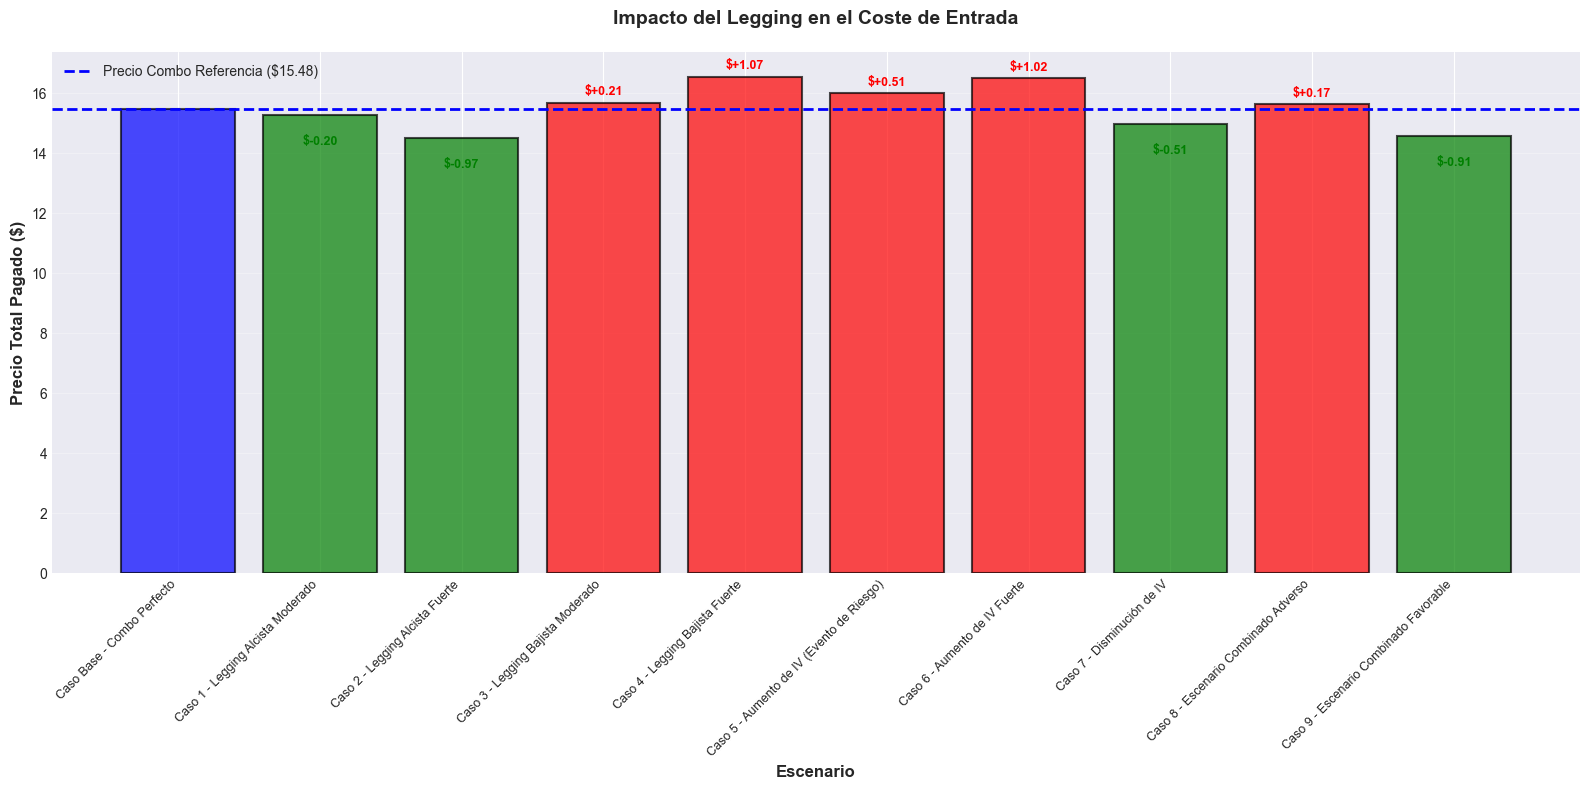

✓ Gráfico 1 guardado: images/pnl_analysis/legging_cost_impact.png


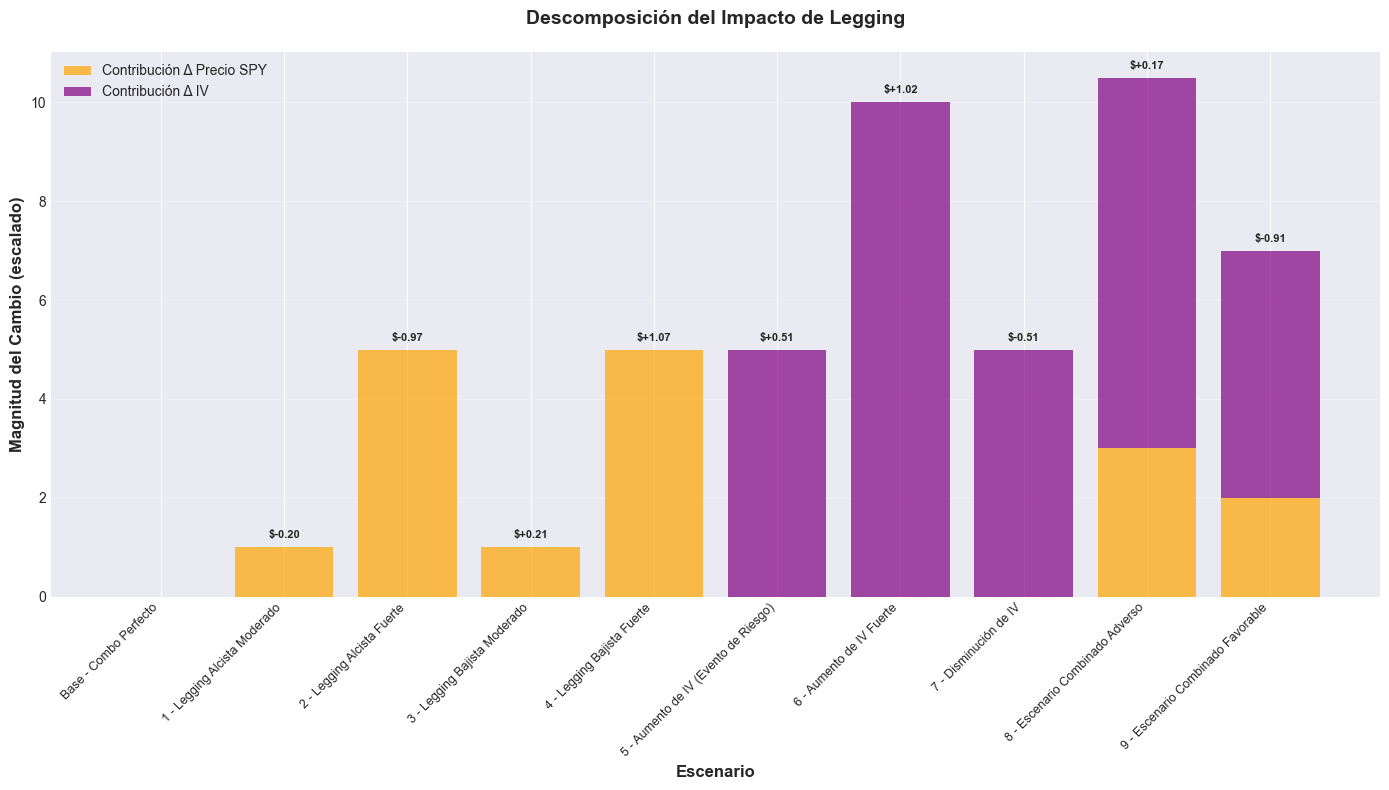

✓ Gráfico 2 guardado: images/pnl_analysis/legging_decomposition.png


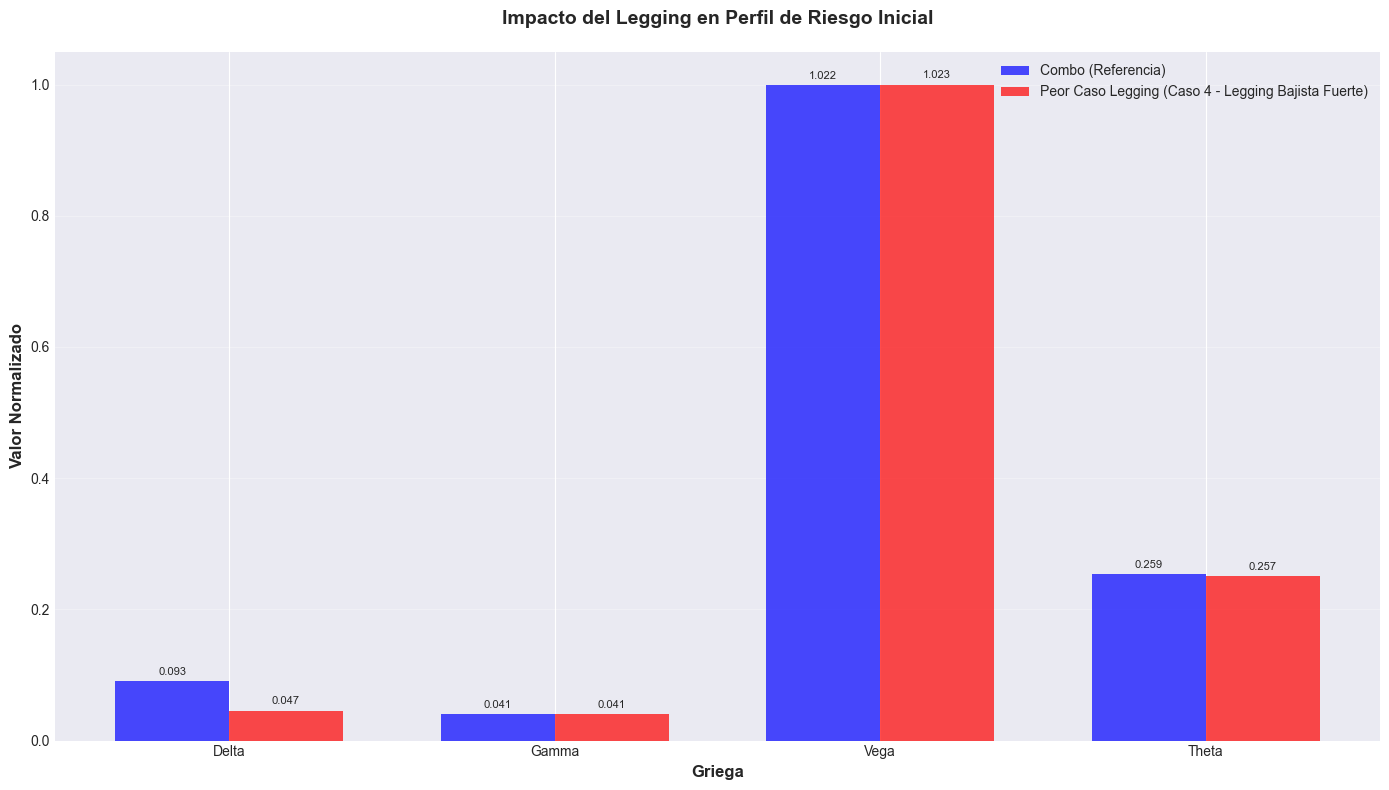

✓ Gráfico 3 guardado: images/pnl_analysis/legging_greeks_impact.png


In [29]:
# Gráfico 1: Impacto en el Coste Total

import matplotlib.pyplot as plt
import numpy as np

# Preparar datos
escenarios_nombres = [r['nombre_escenario'] for r in resultados_legging]
precios_totales = [r['precio_total'] for r in resultados_legging]
diferencias = [r['diferencia_vs_combo'] for r in resultados_legging]

# Precio combo de referencia (primer escenario)
precio_combo_referencia = resultados_legging[0]['precio_total']

# Colores: verde si mejor que combo, rojo si peor
colores = ['blue' if d == 0 else ('green' if d < 0 else 'red') for d in diferencias]

# Crear gráfico
fig, ax = plt.subplots(figsize=(16, 8))

# Gráfico de barras
bars = ax.bar(range(len(escenarios_nombres)), precios_totales, color=colores, alpha=0.7, edgecolor='black', linewidth=1.5)

# Línea horizontal para precio combo
ax.axhline(precio_combo_referencia, color='blue', linestyle='--', linewidth=2, label=f'Precio Combo Referencia (${precio_combo_referencia:.2f})')

# Anotaciones con diferencia en USD
for i, (bar, diff) in enumerate(zip(bars, diferencias)):
    if abs(diff) > 0.01:  # Solo anotar si hay diferencia significativa
        height = bar.get_height()
        ax.annotate(f'${diff:+.2f}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3 if diff > 0 else -15),
                   textcoords="offset points",
                   ha='center', va='bottom' if diff > 0 else 'top',
                   fontsize=9, fontweight='bold',
                   color='red' if diff > 0 else 'green')

ax.set_xlabel('Escenario', fontsize=12, fontweight='bold')
ax.set_ylabel('Precio Total Pagado ($)', fontsize=12, fontweight='bold')
ax.set_title('Impacto del Legging en el Coste de Entrada', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(range(len(escenarios_nombres)))
ax.set_xticklabels(escenarios_nombres, rotation=45, ha='right', fontsize=9)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('images/pnl_analysis/legging_cost_impact.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico 1 guardado: images/pnl_analysis/legging_cost_impact.png")
# Gráfico 2: Descomposición del Impacto

fig, ax = plt.subplots(figsize=(14, 8))

# Preparar datos para stacked bar chart
escenarios_nombres_short = [r['nombre_escenario'].replace('Caso ', '') for r in resultados_legging]
delta_spy_contrib = []
delta_iv_contrib = []

for r in resultados_legging:
    params = r.get('parametros_escenario', {})
    delta_spy = abs(params.get('delta_precio_spy', 0)) * 100  # Convertir a %
    delta_iv = abs(params.get('delta_iv', 0)) * 100  # Convertir a puntos
    
    # Escalar para visualización (normalizar)
    delta_spy_contrib.append(delta_spy * 10)  # Factor de escala
    delta_iv_contrib.append(delta_iv * 5)  # Factor de escala

x_pos = np.arange(len(escenarios_nombres_short))

# Crear stacked bars
bars1 = ax.bar(x_pos, delta_spy_contrib, label='Contribución Δ Precio SPY', color='orange', alpha=0.7)
bars2 = ax.bar(x_pos, delta_iv_contrib, bottom=delta_spy_contrib, label='Contribución Δ IV', color='purple', alpha=0.7)

# Añadir valores de diferencia real
for i, (diff, r) in enumerate(zip(diferencias, resultados_legging)):
    if abs(diff) > 0.01:
        total_height = delta_spy_contrib[i] + delta_iv_contrib[i]
        ax.annotate(f'${diff:+.2f}',
                   xy=(i, total_height),
                   xytext=(0, 5),
                   textcoords="offset points",
                   ha='center', va='bottom',
                   fontsize=8, fontweight='bold')

ax.set_xlabel('Escenario', fontsize=12, fontweight='bold')
ax.set_ylabel('Magnitud del Cambio (escalado)', fontsize=12, fontweight='bold')
ax.set_title('Descomposición del Impacto de Legging', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(escenarios_nombres_short, rotation=45, ha='right', fontsize=9)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('images/pnl_analysis/legging_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico 2 guardado: images/pnl_analysis/legging_decomposition.png")
# Gráfico 3: Impacto en Griegas Iniciales

fig, ax = plt.subplots(figsize=(14, 8))

# Obtener griegas del combo (referencia)
griegas_combo = resultados_legging[0]['griegas_iniciales']

# Encontrar peor caso de legging (mayor diferencia positiva)
peor_caso_idx = np.argmax([r['diferencia_vs_combo'] for r in resultados_legging[1:]]) + 1
griegas_peor_caso = resultados_legging[peor_caso_idx]['griegas_iniciales']

# Preparar datos para comparación
griegas_nombres = ['Delta', 'Gamma', 'Vega', 'Theta']
griegas_combo_vals = [
    abs(griegas_combo['delta']),
    abs(griegas_combo['gamma']),
    abs(griegas_combo['vega']),
    abs(griegas_combo['theta'])
]
griegas_peor_caso_vals = [
    abs(griegas_peor_caso['delta']),
    abs(griegas_peor_caso['gamma']),
    abs(griegas_peor_caso['vega']),
    abs(griegas_peor_caso['theta'])
]

# Normalizar para visualización (dividir por máximo para que todas estén en escala 0-1)
max_val = max(max(griegas_combo_vals), max(griegas_peor_caso_vals))
griegas_combo_norm = [v / max_val if max_val > 0 else 0 for v in griegas_combo_vals]
griegas_peor_caso_norm = [v / max_val if max_val > 0 else 0 for v in griegas_peor_caso_vals]

x = np.arange(len(griegas_nombres))
width = 0.35

bars1 = ax.bar(x - width/2, griegas_combo_norm, width, label='Combo (Referencia)', color='blue', alpha=0.7)
bars2 = ax.bar(x + width/2, griegas_peor_caso_norm, width, label=f'Peor Caso Legging ({resultados_legging[peor_caso_idx]["nombre_escenario"]})', color='red', alpha=0.7)

# Añadir valores reales como anotaciones
for i, (val_combo, val_peor) in enumerate(zip(griegas_combo_vals, griegas_peor_caso_vals)):
    ax.annotate(f'{val_combo:.3f}',
               xy=(i - width/2, griegas_combo_norm[i]),
               xytext=(0, 3),
               textcoords="offset points",
               ha='center', va='bottom',
               fontsize=8)
    ax.annotate(f'{val_peor:.3f}',
               xy=(i + width/2, griegas_peor_caso_norm[i]),
               xytext=(0, 3),
               textcoords="offset points",
               ha='center', va='bottom',
               fontsize=8)

ax.set_xlabel('Griega', fontsize=12, fontweight='bold')
ax.set_ylabel('Valor Normalizado', fontsize=12, fontweight='bold')
ax.set_title('Impacto del Legging en Perfil de Riesgo Inicial', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(griegas_nombres)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('images/pnl_analysis/legging_greeks_impact.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico 3 guardado: images/pnl_analysis/legging_greeks_impact.png")


### 4.4. Recomendaciones para Mitigar Riesgo de Legging

#### Cuándo usar COMBO (recomendado)

1. **Estrategias con múltiples patas donde el precio relativo importa:**
   - Straddles, strangles
   - Spreads (verticales, horizontales, diagonales)
   - Iron condors, butterflies

2. **Mercados volátiles donde precios cambian rápidamente**

3. **Cuando el coste de entrada es crítico para la rentabilidad**

4. **Instrumentos muy líquidos donde combos tienen buen pricing (SPY, QQQ, SPX)**

5. **Posiciones grandes donde pequeñas diferencias de precio se magnifican**

#### Cuándo considerar PATAS SUELTAS (con precaución)

1. **Mercados muy tranquilos con baja volatilidad y spreads estrechos**

2. **Cuando tienes información o timing superior (difícil de justificar)**

3. **Ajustes de posiciones existentes donde solo modificas una pata**

4. **Instrumentos ilíquidos donde combos no se llenan pero patas sueltas sí**

5. **Muy pequeñas posiciones donde diferencia es inmaterial**

#### Estrategias para minimizar riesgo si DEBES usar patas sueltas

1. **Orden de ejecución:**
   - En straddle: ejecutar primero la opción más cara (normalmente tienen delta más alto)
   - Así reduces exposición al movimiento más probable
   
2. **Velocidad:**
   - Minimizar tiempo entre patas (segundos, no minutos)
   - Tener segunda orden preparada antes de ejecutar primera
   
3. **Límites de precios:**
   - Establecer precio límite para segunda pata basado en precio que pagaste en primera
   - Cancelar si el mercado se ha movido demasiado
   
4. **Monitoreo de volatilidad:**
   - Evitar ejecutar patas sueltas antes de eventos conocidos (earnings, datos macro)
   - Si IV empieza a moverse, detener y reevaluar
   
5. **Tamaño:**
   - En posiciones grandes, usar combo siempre
   - Patas sueltas solo para posiciones muy pequeñas

#### Condiciones de mercado de mayor riesgo de legging

**Alto riesgo:**
- Momentos previos a eventos: 30 min antes de earnings, datos de empleo, decisiones de Fed
- Alta frecuencia de noticias: crisis geopolíticas, eventos inesperados
- Primeros 30 min de mercado (9:30-10:00 ET): mayor volatilidad intradiaria
- Últimos 15 min de mercado (3:45-4:00 ET): movimientos de cierre

**Bajo riesgo:**
- Media mañana en días tranquilos (10:30-11:30)
- Mercados laterales sin catalizadores
- Días sin datos económicos importantes
- Baja volatilidad implícita general

#### Análisis de Casos Reales

**Ejemplo conceptual:**

Si ejecutas un straddle con patas sueltas antes de earnings y la IV sube entre patas, la segunda opción puede costar 10-20% más de lo esperado. En un straddle de $20, esto significa pagar $2-4 adicionales, lo que puede reducir significativamente la rentabilidad de la estrategia.

**Escenario típico:**
- Straddle teórico: Call $10 + Put $10 = $20 total
- Ejecutas call a $10
- Mientras preparas orden de put: noticia inesperada hace que IV suba 2 puntos
- Put ahora cuesta $12 (20% más caro)
- Coste total: $10 + $12 = $22 (10% más caro que combo)
- Breakeven superior se mueve de $470 a $472 (strike 450)
- Necesitas movimiento adicional de $2 para alcanzar rentabilidad

Este ejemplo ilustra por qué el riesgo de legging es particularmente peligroso en estrategias donde el coste de entrada es crítico para la rentabilidad.


## 5. Neutralización de Delta con Opciones

### Marco Teórico

#### Método Elegido: Vender Calls OTM

En esta sección implementamos la neutralización de delta usando otra opción en lugar del subyacente (SPY). El método elegido es **vender calls OTM (Out-of-the-Money)**.

**Por qué es el más simple:**

1. **Delta negativo del call vendido compensa delta positivo del straddle**: Al vender un call OTM, obtenemos un delta negativo que neutraliza el delta positivo del long straddle.

2. **Mismo vencimiento que el straddle**: Usar opciones con el mismo vencimiento es más directo y mantiene la coherencia temporal de la estrategia.

3. **Strike OTM (5-10% por encima)**: Un strike OTM típicamente tiene un delta entre -0.20 y -0.30 por contrato, lo cual es ideal para neutralizar el delta del straddle sin requerir demasiados contratos.

4. **Fácil de calcular**: El número de contratos necesarios se calcula simplemente como:
   ```
   n = -Delta_straddle / Delta_call_OTM
   ```
   Donde el signo negativo indica que vendemos contratos (posición corta).

**Alternativas no elegidas:**

- **Vender puts OTM**: Funcionalmente similar, pero para un long straddle con delta positivo, los calls son más intuitivos y directos.

- **Comprar opciones opuestas**: Requiere más capital (pagar primas en lugar de recibirlas), añade complejidad innecesaria y no es tan eficiente en términos de capital.

**Concepto Clave:**

Al vender calls OTM para neutralizar delta, estás transformando el straddle en una estructura similar a un **iron condor parcial**. Esta transformación:
- Reduce el potencial de beneficio ilimitado a cambio de reducir costes y exposiciones
- Limita el beneficio alcista pero mantiene exposición a movimientos bajistas
- Reduce el coste neto de la estrategia (recibes primas de los calls vendidos)

In [30]:
# Implementación: Función neutralizar_delta_con_opcion

def neutralizar_delta_con_opcion(info_straddle, pct_otm=0.05):
    """
    Neutraliza el delta de un long straddle vendiendo calls OTM.
    
    Esta función:
    1. Calcula el delta actual del straddle
    2. Determina el strike OTM objetivo (precio_spy × (1 + pct_otm))
    3. Busca el call más cercano a ese strike en la cadena de opciones
    4. Calcula el delta del call OTM usando bs_greeks_manual
    5. Calcula el número de contratos necesarios: n = -Delta_straddle / Delta_call_OTM
    6. Calcula las griegas del call OTM vendido (multiplicar por -n)
    7. Calcula las griegas netas: Straddle + Calls vendidos
    
    Args:
        info_straddle: Diccionario del Prompt 1 con información del straddle:
            - precio_subyacente: precio actual de SPY
            - strike: strike del straddle
            - vencimiento: fecha de vencimiento
            - dias_hasta_vencimiento: días hasta vencimiento
            - griegas_call: diccionario con griegas del call
            - griegas_put: diccionario con griegas del put
            - precio_call: precio del call
            - precio_put: precio del put
        pct_otm: Porcentaje por encima del precio actual para el strike OTM (default 5%)
    
    Returns:
        Diccionario con:
            - strike_call_vendido: strike del call vendido
            - num_contratos_vendidos: número de contratos vendidos
            - precio_call_vendido: precio del call vendido
            - prima_recibida: prima total recibida (precio × num_contratos × 100)
            - griegas_antes_hedge: diccionario con griegas del straddle solo
            - griegas_hedge: diccionario con griegas de los calls vendidos
            - griegas_netas: diccionario con griegas netas (straddle + hedge)
            - delta_neto: delta neto (debe estar cerca de 0)
    """
    from datetime import datetime, timedelta
    import math
    
    # Obtener parámetros del straddle
    precio_spy = info_straddle['precio_subyacente']
    strike_straddle = info_straddle['strike']
    vencimiento = info_straddle['vencimiento']
    dias_hasta_vencimiento = info_straddle['dias_hasta_vencimiento']
    T = dias_hasta_vencimiento / 365.0
    
    # Obtener parámetros de mercado (reutilizando variables del código original)
    try:
        r = r if 'r' in dir() else 0.05
        q = q if 'q' in dir() else 0.0
        sigma = sigma if 'sigma' in dir() else 0.15
    except:
        r = 0.05
        q = 0.0
        sigma = 0.15
    
    # 1. Calcular delta actual del straddle
    if 'griegas_call' in info_straddle and 'griegas_put' in info_straddle:
        griegas_call = info_straddle['griegas_call']
        griegas_put = info_straddle['griegas_put']
    else:
        # Recalcular si no están disponibles
        griegas_call = bs_greeks_manual(precio_spy, strike_straddle, T, r, q, sigma, 'C')
        griegas_put = bs_greeks_manual(precio_spy, strike_straddle, T, r, q, sigma, 'P')
    
    delta_straddle = griegas_call['delta'] + griegas_put['delta']
    
    # 2. Determinar strike OTM objetivo
    strike_otm_objetivo = precio_spy * (1 + pct_otm)
    
    # 3. Buscar el call más cercano a ese strike
    # En un entorno real, esto se haría consultando la cadena de opciones del broker
    # Por ahora, redondeamos al strike más cercano (espaciado típico de $5 para SPY)
    strike_spacing = 5.0
    strike_call_vendido = round(strike_otm_objetivo / strike_spacing) * strike_spacing
    
    # Asegurar que el strike sea mayor que el precio actual (OTM)
    if strike_call_vendido <= precio_spy:
        strike_call_vendido = round((precio_spy * 1.05) / strike_spacing) * strike_spacing
    
    # 4. Calcular delta del call OTM usando bs_greeks_manual
    griegas_call_otm = bs_greeks_manual(precio_spy, strike_call_vendido, T, r, q, sigma, 'C')
    delta_call_otm = griegas_call_otm['delta']
    
    # 5. Calcular número de contratos necesarios
    # n = -Delta_straddle / Delta_call_OTM
    # El signo negativo indica que vendemos (posición corta)
    if abs(delta_call_otm) < 1e-6:
        raise ValueError(f"Delta del call OTM es demasiado pequeño ({delta_call_otm}), no se puede neutralizar")
    
    num_contratos_vendidos = -delta_straddle / delta_call_otm
    num_contratos_vendidos = round(num_contratos_vendidos)  # Redondear al entero más cercano
    
    # 6. Calcular precio del call OTM vendido
    precio_call_vendido = bs_price(precio_spy, strike_call_vendido, T, r, q, sigma, 'C')
    
    # 7. Calcular prima recibida (precio × num_contratos × 100)
    prima_recibida = precio_call_vendido * num_contratos_vendidos * 100
    
    # 8. Calcular griegas del call OTM vendido (multiplicar por -n porque lo vendemos)
    griegas_hedge = {
        'delta': griegas_call_otm['delta'] * (-num_contratos_vendidos),
        'gamma': griegas_call_otm['gamma'] * (-num_contratos_vendidos),
        'theta': griegas_call_otm['theta'] * (-num_contratos_vendidos),
        'vega': griegas_call_otm['vega'] * (-num_contratos_vendidos),
        'rho': griegas_call_otm['rho'] * (-num_contratos_vendidos)
    }
    
    # 9. Calcular griegas antes del hedge (straddle solo)
    griegas_antes_hedge = {
        'delta': delta_straddle,
        'gamma': griegas_call['gamma'] + griegas_put['gamma'],
        'theta': griegas_call['theta'] + griegas_put['theta'],
        'vega': griegas_call['vega'] + griegas_put['vega'],
        'rho': griegas_call['rho'] + griegas_put['rho']
    }
    
    # 10. Calcular griegas netas (straddle + hedge)
    griegas_netas = {
        'delta': griegas_antes_hedge['delta'] + griegas_hedge['delta'],
        'gamma': griegas_antes_hedge['gamma'] + griegas_hedge['gamma'],
        'theta': griegas_antes_hedge['theta'] + griegas_hedge['theta'],
        'vega': griegas_antes_hedge['vega'] + griegas_hedge['vega'],
        'rho': griegas_antes_hedge['rho'] + griegas_hedge['rho']
    }
    
    return {
        'strike_call_vendido': strike_call_vendido,
        'num_contratos_vendidos': num_contratos_vendidos,
        'precio_call_vendido': precio_call_vendido,
        'prima_recibida': prima_recibida,
        'griegas_antes_hedge': griegas_antes_hedge,
        'griegas_hedge': griegas_hedge,
        'griegas_netas': griegas_netas,
        'delta_neto': griegas_netas['delta']
    }

In [31]:
# Ejemplo de uso: Neutralización de delta con opciones

# Construir un straddle de ejemplo si no existe
if 'straddle_info' not in dir() or straddle_info is None:
    print("Construyendo straddle de ejemplo...")
    straddle_info = construir_long_straddle(ticker='SPY', dias_vencimiento=30)
else:
    print("Usando straddle existente...")

# Aplicar neutralización de delta con calls OTM (5% por encima)
resultado_hedge = neutralizar_delta_con_opcion(straddle_info, pct_otm=0.05)

# Mostrar resultados
print("=" * 70)
print("NEUTRALIZACIÓN DE DELTA CON OPCIONES")
print("=" * 70)
print(f"\nStrike del call vendido: ${resultado_hedge['strike_call_vendido']:.2f}")
print(f"Número de contratos vendidos: {resultado_hedge['num_contratos_vendidos']}")
print(f"Precio del call vendido: ${resultado_hedge['precio_call_vendido']:.2f}")
print(f"Prima recibida: ${resultado_hedge['prima_recibida']:.2f}")
print(f"\nDelta neto (objetivo: ~0): {resultado_hedge['delta_neto']:.4f}")

print("\n" + "=" * 70)
print("GRIEGAS ANTES DEL HEDGE (Straddle solo)")
print("=" * 70)
griegas_antes = resultado_hedge['griegas_antes_hedge']
print(f"Delta:  {griegas_antes['delta']:>10.4f}")
print(f"Gamma:  {griegas_antes['gamma']:>10.4f}")
print(f"Theta:  {griegas_antes['theta']:>10.4f} $/día")
print(f"Vega:   {griegas_antes['vega']:>10.4f}")
print(f"Rho:    {griegas_antes['rho']:>10.4f}")

print("\n" + "=" * 70)
print("GRIEGAS DEL HEDGE (Calls vendidos)")
print("=" * 70)
griegas_hedge = resultado_hedge['griegas_hedge']
print(f"Delta:  {griegas_hedge['delta']:>10.4f}")
print(f"Gamma:  {griegas_hedge['gamma']:>10.4f}")
print(f"Theta:  {griegas_hedge['theta']:>10.4f} $/día")
print(f"Vega:   {griegas_hedge['vega']:>10.4f}")
print(f"Rho:    {griegas_hedge['rho']:>10.4f}")

print("\n" + "=" * 70)
print("GRIEGAS NETAS (Straddle + Hedge)")
print("=" * 70)
griegas_netas = resultado_hedge['griegas_netas']
print(f"Delta:  {griegas_netas['delta']:>10.4f} (objetivo: ~0)")
print(f"Gamma:  {griegas_netas['gamma']:>10.4f}")
print(f"Theta:  {griegas_netas['theta']:>10.4f} $/día")
print(f"Vega:   {griegas_netas['vega']:>10.4f}")
print(f"Rho:    {griegas_netas['rho']:>10.4f}")

Usando straddle existente...
NEUTRALIZACIÓN DE DELTA CON OPCIONES

Strike del call vendido: $470.00
Número de contratos vendidos: -1
Precio del call vendido: $1.93
Prima recibida: $-192.57

Delta neto (objetivo: ~0): 0.2788

GRIEGAS ANTES DEL HEDGE (Straddle solo)
Delta:      0.0932
Gamma:      0.0409
Theta:     -0.2592 $/día
Vega:       1.0223
Rho:        0.0217

GRIEGAS DEL HEDGE (Calls vendidos)
Delta:      0.1856
Gamma:      0.0138
Theta:     -0.0975 $/día
Vega:       0.3451
Rho:        0.0671

GRIEGAS NETAS (Straddle + Hedge)
Delta:      0.2788 (objetivo: ~0)
Gamma:      0.0548
Theta:     -0.3567 $/día
Vega:       1.3674
Rho:        0.0888


### 5.1. Análisis del Impacto en Griegas

El siguiente análisis explica cómo la neutralización de delta con opciones afecta cada griega:

**Delta:**
- Antes: Delta_straddle (ej: +0.20)
- Después: ~0 (objetivo logrado)
- Interpretación: Eliminamos exposición direccional a movimientos pequeños del subyacente

**Gamma:**
- Antes: Gamma_straddle (ej: +0.05, siempre positivo)
- Después: Gamma_straddle - Gamma_calls_vendidos
- Resultado: DISMINUYE (las opciones vendidas tienen gamma positivo, al venderlas restamos)
- Interpretación: Menos sensible a movimientos grandes, menos gamma scalping

**Vega:**
- Antes: Vega_straddle (ej: +0.80, siempre positivo)
- Después: Vega_straddle - Vega_calls_vendidos
- Resultado: DISMINUYE (pero sigue positivo)
- Interpretación: Menos beneficio de aumentos de IV

**Theta:**
- Antes: Theta_straddle (ej: -0.15, siempre negativo)
- Después: Theta_straddle - Theta_calls_vendidos (vendemos opciones con theta negativo)
- Resultado: MEJORA (menos negativo, o incluso positivo si recibimos suficiente prima)
- Interpretación: Menos decay temporal, las primas recibidas compensan parte del coste

**Concepto clave:**
Al vender calls OTM para neutralizar delta, estás transformando el straddle en una estructura similar a un iron condor parcial. Reduces el potencial de beneficio ilimitado a cambio de reducir costes y exposiciones.

### 5.2. Comparación con Hedge usando SPY

La siguiente tabla compara el hedge usando SPY (subyacente) vs. usando opciones (calls OTM):

| Aspecto | Hedge con SPY | Hedge con Opciones |
|---------|---------------|-------------------|
| **Capital necesario** | Alto (comprar/vender acciones) | Bajo (primas recibidas) |
| **Impacto en Gamma** | Sin cambio | Disminuye |
| **Impacto en Vega** | Sin cambio | Disminuye |
| **Impacto en Theta** | Sin cambio | Mejora (menos negativo) |
| **Complejidad** | Simple | Moderada |
| **Flexibilidad** | Alta (rebalanceo fácil) | Baja (otra posición de opciones) |
| **Riesgo de asignación** | Bajo | Moderado (riesgo de ejercicio) |
| **Coste de transacción** | Bajo (acciones) | Moderado (opciones) |

**Ventajas del hedge con SPY:**
- Más simple de implementar y entender
- Rebalanceo más fácil (solo comprar/vender acciones)
- No hay riesgo de ejercicio anticipado
- Menor complejidad operativa

**Ventajas del hedge con opciones:**
- Requiere menos capital (recibes primas en lugar de invertir)
- Mejora el Theta (reduce el coste temporal)
- Reduce Gamma y Vega (menos exposición a movimientos grandes y cambios de IV)
- Transforma la estrategia en una estructura más compleja (iron condor parcial)

✓ Gráfico de payoff comparison guardado


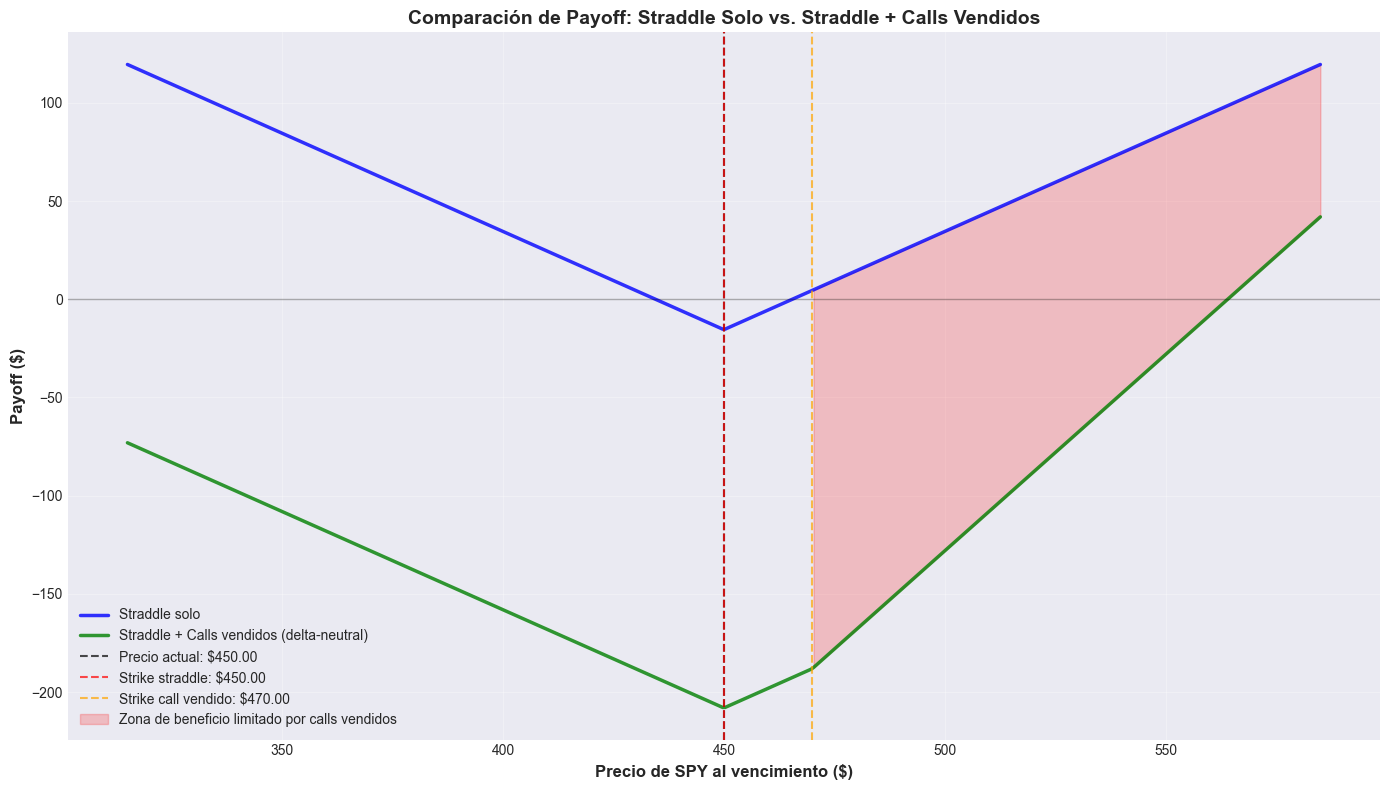

✓ Gráfico de comparación de griegas guardado


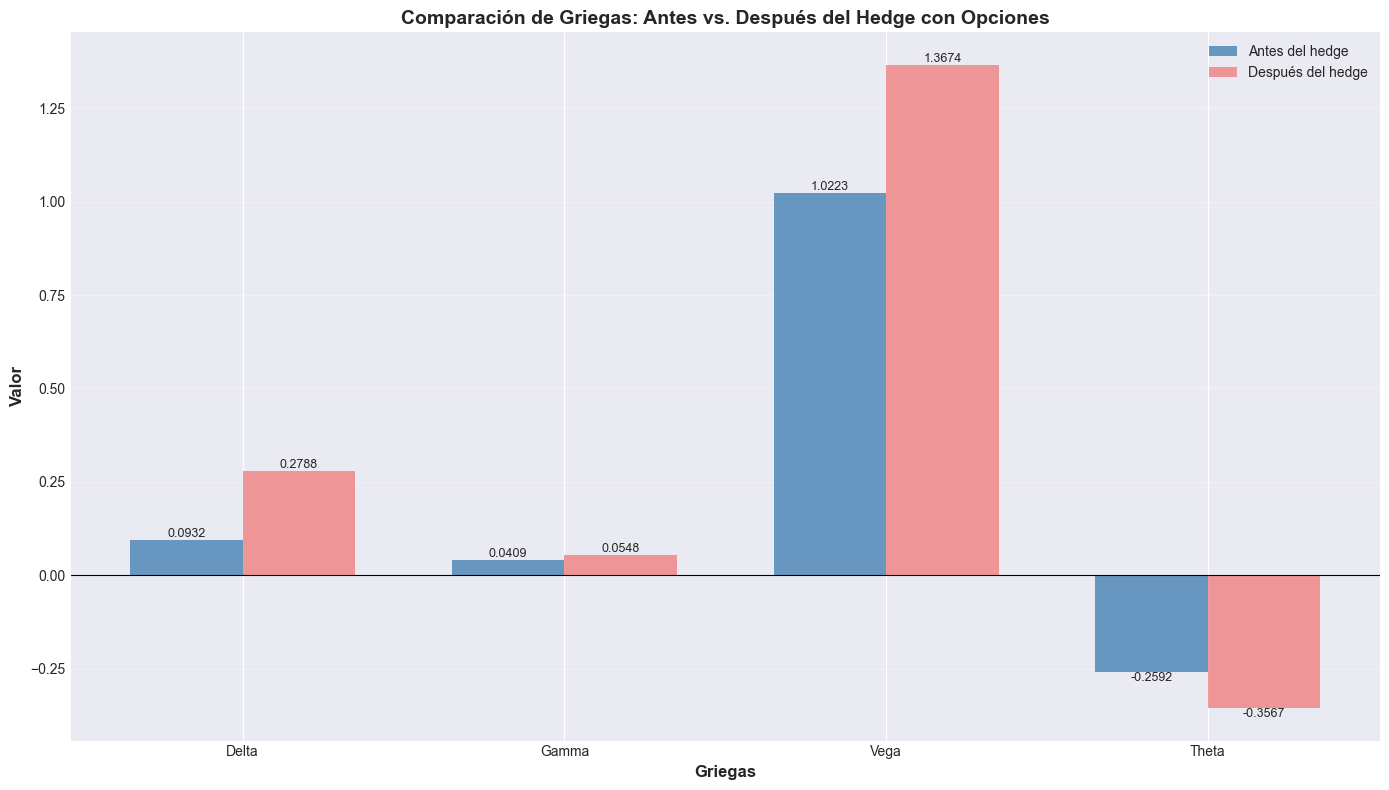


TABLA COMPARATIVA DE GRIEGAS
Griega         Antes (Straddle)     Después (Hedged)          Cambio
----------------------------------------------------------------------
Delta                    0.0932               0.2788          0.1856 (+199.2%)
Gamma                    0.0409               0.0548          0.0138 (+33.8%)
Vega                     1.0223               1.3674          0.3451 (+33.8%)
Theta                   -0.2592              -0.3567         -0.0975 (-37.6%)


In [32]:
# Visualizaciones: Payoff Comparison y Tabla de Griegas

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Obtener información del straddle y del hedge
if 'straddle_info' not in dir():
    straddle_info = construir_long_straddle(ticker='SPY', dias_vencimiento=30)

if 'resultado_hedge' not in dir():
    resultado_hedge = neutralizar_delta_con_opcion(straddle_info, pct_otm=0.05)

# Preparar datos para visualizaciones
precio_actual = straddle_info['precio_subyacente']
strike_straddle = straddle_info['strike']
strike_call_vendido = resultado_hedge['strike_call_vendido']
prima_straddle = straddle_info['inversion_inicial']
prima_recibida = resultado_hedge['prima_recibida']
prima_neta = prima_straddle - prima_recibida  # Coste neto después de recibir primas

# Crear rango de precios de SPY al vencimiento
rango_porcentaje = 0.30
precios_vencimiento = np.linspace(
    precio_actual * (1 - rango_porcentaje), 
    precio_actual * (1 + rango_porcentaje), 
    500
)

# Calcular payoff del straddle solo
payoff_straddle = (
    np.maximum(precios_vencimiento - strike_straddle, 0) + 
    np.maximum(strike_straddle - precios_vencimiento, 0) - 
    prima_straddle
)

# Calcular payoff del straddle + calls vendidos
payoff_straddle_hedge = (
    np.maximum(precios_vencimiento - strike_straddle, 0) +  # Call del straddle
    np.maximum(strike_straddle - precios_vencimiento, 0) -  # Put del straddle
    np.maximum(precios_vencimiento - strike_call_vendido, 0) * resultado_hedge['num_contratos_vendidos'] +  # Calls vendidos (pérdida si sube)
    prima_recibida -  # Primas recibidas
    prima_straddle  # Primas pagadas
)

# GRÁFICO 1: Payoff Comparison
fig, ax = plt.subplots(figsize=(14, 8))

# Línea azul: Straddle solo
ax.plot(precios_vencimiento, payoff_straddle, 'b-', linewidth=2.5, 
        label='Straddle solo', alpha=0.8)

# Línea verde: Straddle + calls vendidos
ax.plot(precios_vencimiento, payoff_straddle_hedge, 'g-', linewidth=2.5, 
        label='Straddle + Calls vendidos (delta-neutral)', alpha=0.8)

# Marcar líneas verticales importantes
ax.axvline(precio_actual, color='black', linestyle='--', linewidth=1.5, alpha=0.7, 
           label=f'Precio actual: ${precio_actual:.2f}')
ax.axvline(strike_straddle, color='red', linestyle='--', linewidth=1.5, alpha=0.7, 
           label=f'Strike straddle: ${strike_straddle:.2f}')
ax.axvline(strike_call_vendido, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, 
           label=f'Strike call vendido: ${strike_call_vendido:.2f}')

# Línea horizontal en cero
ax.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)

# Sombrear zona donde el hedge limita el beneficio
zona_limitada = precios_vencimiento > strike_call_vendido
ax.fill_between(precios_vencimiento, payoff_straddle, payoff_straddle_hedge, 
                where=zona_limitada, color='red', alpha=0.2, 
                label='Zona de beneficio limitado por calls vendidos')

ax.set_xlabel('Precio de SPY al vencimiento ($)', fontsize=12, fontweight='bold')
ax.set_ylabel('Payoff ($)', fontsize=12, fontweight='bold')
ax.set_title('Comparación de Payoff: Straddle Solo vs. Straddle + Calls Vendidos', 
              fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/payoff_comparison_delta_neutral.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico de payoff comparison guardado")
plt.show()

# GRÁFICO 2: Tabla de Griegas con barras
fig, ax = plt.subplots(figsize=(14, 8))

# Preparar datos
griegas = ['Delta', 'Gamma', 'Vega', 'Theta']
griegas_antes = [
    resultado_hedge['griegas_antes_hedge']['delta'],
    resultado_hedge['griegas_antes_hedge']['gamma'],
    resultado_hedge['griegas_antes_hedge']['vega'],
    resultado_hedge['griegas_antes_hedge']['theta']
]
griegas_despues = [
    resultado_hedge['griegas_netas']['delta'],
    resultado_hedge['griegas_netas']['gamma'],
    resultado_hedge['griegas_netas']['vega'],
    resultado_hedge['griegas_netas']['theta']
]

x = np.arange(len(griegas))
width = 0.35

# Crear barras
bars1 = ax.bar(x - width/2, griegas_antes, width, label='Antes del hedge', 
               color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, griegas_despues, width, label='Después del hedge', 
               color='lightcoral', alpha=0.8)

# Añadir valores en las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)

ax.set_xlabel('Griegas', fontsize=12, fontweight='bold')
ax.set_ylabel('Valor', fontsize=12, fontweight='bold')
ax.set_title('Comparación de Griegas: Antes vs. Después del Hedge con Opciones', 
              fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(griegas)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(0, color='black', linewidth=0.8)

plt.tight_layout()
plt.savefig('images/greeks_comparison_delta_neutral.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico de comparación de griegas guardado")
plt.show()

# Crear tabla comparativa en formato texto
print("\n" + "=" * 70)
print("TABLA COMPARATIVA DE GRIEGAS")
print("=" * 70)
print(f"{'Griega':<10} {'Antes (Straddle)':>20} {'Después (Hedged)':>20} {'Cambio':>15}")
print("-" * 70)
for i, griega in enumerate(griegas):
    antes = griegas_antes[i]
    despues = griegas_despues[i]
    cambio = despues - antes
    cambio_pct = (cambio / abs(antes) * 100) if abs(antes) > 1e-6 else 0
    print(f"{griega:<10} {antes:>20.4f} {despues:>20.4f} {cambio:>15.4f} ({cambio_pct:+.1f}%)")
print("=" * 70)

## 6. Reflexión: ¿Qué habría cambiado usando SPX en lugar de SPY?

### Introducción

A lo largo de este proyecto hemos utilizado opciones sobre **SPY** (SPDR S&P 500 ETF Trust) para implementar nuestra estrategia de long straddle y sus variantes delta-hedged. En esta sección reflexionamos sobre qué habría cambiado si hubiéramos utilizado opciones sobre **SPX** (S&P 500 Index).

---

### 1. Diferencias Fundamentales entre SPX y SPY

#### Tabla Comparativa General

| Característica | SPX | SPY |
|----------------|-----|-----|
| **Tipo de instrumento** | Índice (no negociable) | ETF (negociable) |
| **Valor aproximado** | ~5,000 USD | ~500 USD (1/10 de SPX) |
| **Multiplicador** | 100 | 100 |
| **Valor nocional por contrato** | ~500,000 USD | ~50,000 USD |
| **Estilo de ejercicio** | Europeo (solo al vencimiento) | Americano (cualquier momento) |
| **Tipo de liquidación** | Cash settlement (efectivo) | Physical settlement (acciones ETF) |
| **Subyacente negociable** | No | Sí |
| **Tratamiento fiscal (USA)** | Sección 1256 (60/40) | Capital gains estándar |
| **Dividendos** | No (índice de precios) | Sí (ETF paga dividendos) |
| **Horario de trading** | Más amplio (opens antes) | Horario regular de mercado |

---

### 2. Implicaciones para la Estrategia Long Straddle

#### 2.1 Tamaño de la Posición

**SPX:**
- 1 contrato de opciones SPX tiene aproximadamente la misma exposición que 10 contratos de opciones SPY
- Valor nocional: ~500,000 USD por straddle
- Requiere cuenta significativamente más grande
- Inversión típica en prima: 15,000 - 30,000 USD para un straddle ATM a 30 días
- **Público objetivo**: institucionales, fondos, cuentas grandes (>100,000 USD)

**SPY:**
- Valor nocional: ~50,000 USD por straddle
- Inversión típica en prima: 1,500 - 3,000 USD para un straddle ATM a 30 días
- **Público objetivo**: retail, cuentas más pequeñas, educación

**Conclusión**: SPY es más accesible y apropiado para cuentas retail y propósitos educativos.

---

#### 2.2 Estilo de Ejercicio: Europeo vs Americano

**SPX (Europeo):**
- Las opciones solo pueden ejercerse en la fecha de vencimiento
- **Ventajas**:
  - Más predecible: sabes exactamente cuándo puede haber ejercicio
  - Sin pin risk: no hay riesgo de que te asignen antes del vencimiento
  - Modelos teóricos más precisos (Black-Scholes asume ejercicio europeo)
- **Desventajas**:
  - Menos flexibilidad para el comprador
  - No puedes ejercer anticipadamente si es muy favorable

**SPY (Americano):**
- Las opciones pueden ejercerse en cualquier momento antes del vencimiento
- **Ventajas**:
  - Flexibilidad para el comprador
  - Puedes capturar valor intrínseco anticipadamente si es óptimo
- **Desventajas**:
  - Pin risk: riesgo de asignación anticipada si las opciones están deep ITM
  - Para long straddle: si una pata se mete muy ITM, puede ser ejercida antes del vencimiento
  - Complica la gestión de la posición

**Impacto en nuestro proyecto:**
- Con SPY tuvimos que estar atentos al riesgo de ejercicio anticipado si el mercado se movía fuertemente en una dirección
- Con SPX esto no sería una preocupación: solo monitorizamos hasta el vencimiento
- Para una estrategia delta-hedged, el ejercicio anticipado de SPY puede complicar el rebalanceo

---

#### 2.3 Liquidez y Spreads

**SPX:**
- Liquidez excelente en strikes ATM y cercanos
- Spreads bid-ask típicamente más estrechos en términos porcentuales
- Ejemplo: spread de 0.20 USD sobre opción de 80 USD = 0.25%
- Mejor para vencimientos mensuales estándar
- Market makers profesionales ofrecen buenos precios en combos

**SPY:**
- Liquidez excepcional en prácticamente todos los strikes
- Spreads muy estrechos, especialmente en strikes ATM
- Ejemplo: spread de 0.02-0.05 USD sobre opción de 8 USD = 0.25-0.6%
- Excelente liquidez también en vencimientos semanales
- Uno de los productos de opciones más líquidos del mundo

**Conclusión**: Ambos tienen liquidez excelente, pero SPY tiene ventaja en strikes más alejados y vencimientos no estándar.

---

### 3. Implicaciones para el Delta-Hedging

#### 3.1 El Desafío con SPX

**Problema fundamental**: No puedes comprar o vender el índice SPX directamente (es solo un número calculado).

**Alternativas para hedgear delta con SPX:**

##### Opción 1: Futuros ES (E-mini S&P 500)
```
Ratio de conversión:
- 1 contrato futuro ES = 50 × Precio del índice S&P 500
- 1 contrato opción SPX = 100 × Precio del índice S&P 500
- Por tanto: 1 opción SPX ≈ 2 futuros ES

Ejemplo de hedge:
- Straddle SPX con Delta = +0.20
- Delta total = 0.20 × 100 = +20 "puntos de índice"
- Futuros ES necesarios = 20 / 50 = 0.4 contratos
- Problema: no puedes operar 0.4 contratos, mínimo es 1
- Resultado: overhedge o underhedge, no puedes ser preciso
```

**Desventajas**:
- Ratio complejo (2:1)
- Granularidad gruesa: no puedes ajustar con precisión
- Requiere cuenta de futuros
- Margin requirements diferentes
- Complejidad operativa adicional

##### Opción 2: Usar SPY como proxy
```
Ratio de conversión:
- SPX ≈ 10 × SPY
- 1 opción SPX ≈ 10 opciones SPY (en exposición)
- Para hedgear 1 opción SPX: usar 10× las acciones de SPY

Ejemplo de hedge:
- Straddle SPX con Delta = +0.20
- Acciones SPY necesarias = 0.20 × 100 × 10 = 200 acciones
```

**Desventajas**:
- Tracking error: SPY no replica perfectamente SPX (aunque es mínimo)
- Dividendos de SPY introducen pequeñas diferencias
- Expenses ratio del ETF (muy bajo, ~0.09%)

#### Opción 3: Usar otra opción SPX
- Vender calls/puts OTM como hicimos en el Prompt 5
- Ventaja: todo en el mismo producto
- Desventaja: afecta Gamma, Vega, Theta (no es hedge puro de delta)

---

#### 3.2 La Simplicidad con SPY

**Hedge directo con el subyacente:**
```python
# Cálculo simple y directo
delta_straddle = delta_call + delta_put  # Ejemplo: +0.20
acciones_necesarias = -delta_straddle × 100  # -20 acciones

# Ejecución
if acciones_necesarias > 0:
    comprar(20, 'SPY')
else:
    vender(20, 'SPY')
```

**Ventajas:**
- Ratio 1:1 perfecto: delta de opciones SPY se cubre con acciones SPY
- Granularidad fina: puedes ajustar de 1 en 1 acción
- Simple de entender y ejecutar
- No requiere cuenta de futuros
- Tracking perfecto (mismo subyacente)

**Desventaja:**
- Requiere capital para comprar/vender acciones (no apalancado como futuros)
- Ejemplo: hedgear delta de 0.20 requiere ~20 × 500 = 10,000 USD de capital

---

#### 3.3 Comparación Visual del Delta-Hedging

```
ESCENARIO: Straddle con Delta = +0.30, necesitas neutralizar

┌─────────────────────────────────────────────────────────────┐
│                        CON SPX                               │
├─────────────────────────────────────────────────────────────┤
│ Opción 1: Futuros ES                                        │
│   Delta a neutralizar: +30 puntos índice                    │
│   Futuros necesarios: 30/50 = 0.6 contratos                │
│   Problema: Solo puedes operar 1 contrato entero           │
│   Resultado: Overhedge de 66%                               │
│                                                              │
│ Opción 2: Usar SPY como proxy                               │
│   Delta a neutralizar: +30 puntos índice                    │
│   Acciones SPY: 30 × 10 = 300 acciones                     │
│   Capital necesario: 300 × 500 = 150,000 USD               │
│   Resultado: Posible pero capital intensivo                 │
│                                                              │
│ Opción 3: Vender calls SPX OTM                              │
│   Encuentra call con delta -0.30                            │
│   Vende 1 contrato                                          │
│   Resultado: Delta neutral PERO afecta Gamma/Vega/Theta    │
└─────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────┐
│                        CON SPY                               │
├─────────────────────────────────────────────────────────────┤
│ Usar acciones SPY directamente                              │
│   Delta a neutralizar: +0.30                                │
│   Acciones necesarias: -0.30 × 100 = -30 acciones          │
│   Operación: Vender 30 acciones de SPY                     │
│   Capital: 30 × 500 = 15,000 USD                           │
│   Resultado: Hedge preciso, simple, directo                 │
└─────────────────────────────────────────────────────────────┘
```

**Conclusión clara**: Para delta-hedging con rebalanceo frecuente, SPY es significativamente más simple y práctico.

---

### 4. Aspectos Fiscales (Contexto USA)

#### 4.1 Tratamiento Fiscal de SPX (Sección 1256)

Las opciones sobre índices amplios como SPX reciben tratamiento especial bajo la Sección 1256 del código fiscal estadounidense:

```
Regla 60/40:
- 60% de las ganancias/pérdidas se tratan como long-term capital gains
- 40% se tratan como short-term capital gains
- Independientemente del tiempo que mantengas la posición

Tasas aproximadas (2024):
- Long-term capital gains: 15-20% (según bracket)
- Short-term capital gains: hasta 37% (tasa ordinaria)

Tasa efectiva bajo 1256:
- 60% × 20% + 40% × 37% = 12% + 14.8% = 26.8%
```

**Ejemplo numérico:**
```
Ganancia en straddle SPX: 10,000 USD

Bajo Sección 1256:
- Long-term (60%): 6,000 USD × 20% = 1,200 USD
- Short-term (40%): 4,000 USD × 37% = 1,480 USD
- Total impuestos: 2,680 USD
- Tasa efectiva: 26.8%
- Ganancia neta: 7,320 USD
```

#### 4.2 Tratamiento Fiscal de SPY (Estándar)

Las opciones sobre ETFs como SPY reciben tratamiento estándar de capital gains:

```
Depende del holding period:
- Menos de 1 año: short-term capital gains (tasa ordinaria, hasta 37%)
- Más de 1 año: long-term capital gains (15-20%)

Para trading activo de opciones (típico en straddles):
- Casi siempre short-term (posiciones < 1 año)
- Tasa: hasta 37%
```

**Mismo ejemplo:**
```
Ganancia en straddle SPY: 10,000 USD
Holding period: 30 días (típico)

Short-term capital gains:
- 10,000 USD × 37% = 3,700 USD
- Ganancia neta: 6,300 USD
```

#### 4.3 Comparación Fiscal

```
Ganancia de 10,000 USD:
┌──────────────┬──────────────┬──────────────┬──────────────┐
│  Instrumento │   Impuestos  │ Ganancia Neta│  Diferencia  │
├──────────────┼──────────────┼──────────────┼──────────────┤
│     SPX      │   2,680 USD  │   7,320 USD  │      -       │
│     SPY      │   3,700 USD  │   6,300 USD  │  -1,020 USD  │
└──────────────┴──────────────┴──────────────┴──────────────┘

Ahorro fiscal con SPX: 1,020 USD (10.2% de la ganancia)
```

**Ventaja significativa de SPX para traders activos profesionales.**

---

### 5. Dividendos y su Impacto

#### 5.1 SPX: Índice de Precios

**Concepto**: SPX es un índice de precios, NO incluye dividendos.

**Implicaciones:**
- Las empresas del S&P 500 pagan dividendos (~1.5% anual agregado)
- Cuando una empresa paga dividendo, su precio baja por el monto del dividendo (ex-dividend)
- El índice SPX refleja esta caída de precio
- Las opciones sobre SPX NO ajustan por dividendos

**Para Black-Scholes:**
```python
# Opciones SPX: usar dividend yield = 0 (o muy pequeño para ajustes)
precio_call_spx = black_scholes(S, K, T, r, sigma, q=0.0)
```

**Ventaja**: Modelos más limpios, sin complicaciones de dividendos.

#### 5.2 SPY: ETF que Paga Dividendos

**Concepto**: SPY es un ETF que recibe los dividendos de las acciones subyacentes y los distribuye a los holders del ETF.

**Implicaciones:**
- SPY paga dividendos trimestrales (~1.5% anual)
- Si posees acciones de SPY (al hacer delta-hedge), recibes estos dividendos
- Las opciones sobre SPY ajustan su precio por expectativa de dividendos

**Para Black-Scholes:**
```python
# Opciones SPY: incluir dividend yield esperado
precio_call_spy = black_scholes(S, K, T, r, sigma, q=0.015)
```

**Impacto en delta-hedging:**
```
Beneficio adicional al hedgear con acciones SPY:
- Tienes posición larga en SPY para cubrir delta
- Ejemplo: 100 acciones × 500 USD = 50,000 USD
- Dividend yield: 1.5% anual
- Dividendo anual esperado: 750 USD
- Para posición de 30 días: 750/12 ≈ 62 USD

Este ingreso adicional compensa parcialmente el theta decay del straddle.
```

**Complicación**: Necesitas ajustar el cálculo de griegas con el dividend yield correcto.

---

### 6. Cambios Necesarios en el Código

Si hubiéramos usado SPX en lugar de SPY, estos serían los principales cambios:

#### 6.1 Ajuste de Tamaño de Contrato

```python
# CON SPY (código actual)
def construir_long_straddle(ticker='SPY', dias_vencimiento=30):
    precio_subyacente = obtener_precio(ticker)  # ~500 USD
    notional = precio_subyacente × 100  # ~50,000 USD
    # ... resto del código ...

# CON SPX (modificado)
def construir_long_straddle(ticker='SPX', dias_vencimiento=30):
    precio_subyacente = obtener_precio(ticker)  # ~5,000 USD
    notional = precio_subyacente × 100  # ~500,000 USD
    
    # Advertencia al usuario sobre tamaño
    print(f"ATENCIÓN: Valor nocional = {notional:,.0f} USD")
    print("Esto requiere cuenta apropiada para el tamaño")
    # ... resto del código ...
```

### 6.2 Delta-Hedging

```python
# CON SPY (código actual)
def aplicar_delta_hedge(info_straddle, precios_historicos):
    delta = calcular_delta_straddle(info_straddle)
    acciones_necesarias = -delta × 100
    
    # Ejecutar: comprar/vender acciones de SPY
    operar_acciones('SPY', acciones_necesarias)

# CON SPX (opción usando SPY como proxy)
def aplicar_delta_hedge(info_straddle, precios_historicos):
    delta = calcular_delta_straddle(info_straddle)
    
    # 1 SPX ≈ 10 SPY, entonces necesitamos 10× las acciones
    acciones_spy_necesarias = -delta × 100 × 10
    
    # Ejecutar: comprar/vender acciones de SPY (como proxy)
    operar_acciones('SPY', acciones_spy_necesarias)
    
    print(f"Nota: Usando SPY como proxy para hedgear SPX")

# CON SPX (opción usando futuros ES)
def aplicar_delta_hedge(info_straddle, precios_historicos):
    delta = calcular_delta_straddle(info_straddle)
    puntos_indice = delta × 100  # Delta en "puntos de índice"
    
    # 1 futuro ES = 50 puntos, 1 opción SPX = 100 puntos
    futuros_necesarios = puntos_indice / 50
    
    # Redondear (problema de granularidad)
    futuros_a_operar = round(futuros_necesarios)
    
    if abs(futuros_necesarios - futuros_a_operar) > 0.3:
        print(f"ADVERTENCIA: Error de hedge significativo")
        print(f"Óptimo: {futuros_necesarios:.2f}, Operando: {futuros_a_operar}")
    
    operar_futuros('ES', futuros_a_operar)
```

#### 6.3 Cálculo de Griegas (Dividendos)

```python
# CON SPY (incluir dividend yield)
def calcular_griegas_spy(S, K, T, r, sigma):
    q = 0.015  # Dividend yield de SPY (~1.5% anual)
    
    # Black-Scholes ajustado
    d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    # Griegas con dividendos
    delta_call = np.exp(-q*T) * norm.cdf(d1)
    # ... resto de griegas ...
    
    return {'delta': delta_call, ...}

# CON SPX (sin dividend yield o muy pequeño)
def calcular_griegas_spx(S, K, T, r, sigma):
    q = 0.0  # SPX es índice de precios
    
    # Black-Scholes estándar
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    delta_call = norm.cdf(d1)
    # ... resto de griegas ...
    
    return {'delta': delta_call, ...}
```

#### 6.4 Gestión de Ejercicio Anticipado

```python
# CON SPY (monitorear ejercicio anticipado)
def monitorear_posicion(info_straddle, precio_actual):
    # Calcular moneyness
    call_itm = precio_actual - info_straddle['strike']
    put_itm = info_straddle['strike'] - precio_actual
    
    # Alertas de riesgo de ejercicio anticipado
    if call_itm > 20:  # Deep ITM
        print("ALERTA: Call muy ITM, riesgo de ejercicio anticipado")
        print("Considera cerrar posición o ajustar")
    
    if put_itm > 20:  # Deep ITM
        print("ALERTA: Put muy ITM, riesgo de ejercicio anticipado")
        print("Considera cerrar posición o ajustar")

# CON SPX (no necesario, ejercicio solo al vencimiento)
def monitorear_posicion(info_straddle, precio_actual):
    # Solo monitorear P&L y griegas
    # No preocuparse por ejercicio anticipado
    pass
```

#### 6.5 Cálculo de P&L con Impuestos

```python
# CON SPY
def calcular_pnl_neto_impuestos(pnl_bruto, dias_holding):
    if dias_holding < 365:
        # Short-term capital gains
        tasa = 0.37  # Ejemplo: bracket más alto
    else:
        # Long-term capital gains
        tasa = 0.20
    
    impuestos = pnl_bruto × tasa
    pnl_neto = pnl_bruto - impuestos
    
    return pnl_neto, impuestos

# CON SPX (Sección 1256)
def calcular_pnl_neto_impuestos(pnl_bruto, dias_holding):
    # Independiente del holding period: siempre 60/40
    tasa_efectiva = 0.60 × 0.20 + 0.40 × 0.37
    # = 0.12 + 0.148 = 0.268
    
    impuestos = pnl_bruto × tasa_efectiva
    pnl_neto = pnl_bruto - impuestos
    
    return pnl_neto, impuestos
```

---

### 7. Resultados Esperados: ¿Cambiarían las Conclusiones?

#### 7.1 Patrones de P&L

**Conceptualmente idénticos:**
- Mismo comportamiento de griegas (escalado 10×)
- Mismo patrón de gamma scalping
- Misma exposición a vega y theta
- Mismas conclusiones sobre delta-hedging vs sin hedge

**Ejemplo:**
```
Straddle SPY:
- Inversión: 1,500 USD
- Gamma: +0.05
- Movimiento de 1% en SPY: ~5 USD de precio
- Beneficio de gamma: ~0.05 × 25 × 100 = 125 USD (aprox)

Straddle SPX:
- Inversión: 15,000 USD (10× más)
- Gamma: +0.05 (mismo valor por "punto de índice")
- Movimiento de 1% en SPX: ~50 USD de precio
- Beneficio de gamma: ~0.05 × 2500 × 100 = 1,250 USD (10× más)

Retorno porcentual: Idéntico en ambos casos
```

#### 7.2 Diferencias en Resultados Netos

**Factores que SÍ cambiarían el resultado final:**

1. **Costos de transacción** (no simulados en nuestro proyecto):
   - SPX: comisiones sobre 1 contrato grande
   - SPY: comisiones sobre 10 contratos pequeños (o 1 si ajustamos tamaño)
   - Impacto: menor con SPX para posiciones grandes

2. **Spreads bid-ask**:
   - SPX: spreads más estrechos porcentualmente en ATM
   - SPY: spreads muy competitivos pero ligeramente más amplios porcentualmente
   - Impacto: ~5-10 USD de diferencia en entrada/salida

3. **Impuestos** (diferencia significativa):
   - SPX: ~26.8% de tasa efectiva
   - SPY: ~37% si short-term
   - En ganancia de 10,000 USD: diferencia de ~1,000 USD

4. **Dividendos** (si hedgeamos con SPY):
   - SPY: ~750 USD anuales por cada 50,000 USD de hedge
   - Para 30 días: ~60 USD de ingreso adicional
   - Beneficio exclusivo de usar SPY para hedge

#### 7.3 Conclusiones Invariantes

**Las siguientes conclusiones serían IDÉNTICAS con SPX o SPY:**

1. Delta-hedging reduce volatilidad del P&L pero no necesariamente aumenta el retorno total
2. La estrategia es una apuesta por volatilidad realizada vs volatilidad implícita
3. Gamma scalping genera beneficios en mercados volátiles
4. Theta decay es el coste constante de la estrategia
5. Vega exposure beneficia de aumentos de IV
6. Riesgo de legging al ejecutar patas sueltas
7. Neutralizar delta con opciones afecta gamma, vega y theta

---

### 8. Decisión Final: ¿Por qué Elegimos SPY?

#### Justificación para Este Proyecto Académico

1. **Accesibilidad pedagógica**:
   - Tamaño manejable para estudiantes y cuentas retail
   - Más fácil de visualizar mentalmente (500 USD vs 5,000 USD)
   - Requiere menos capital para replicar en cuenta real

2. **Simplicidad del delta-hedging**:
   - Hedgear con el ETF directamente es más didáctico
   - Ratio 1:1 es más intuitivo
   - Evita complejidad de futuros o ratios 10:1
   - Permite enfocarse en conceptos sin complicaciones operativas

3. **Disponibilidad de datos**:
   - SPY tiene datos históricos más accesibles
   - APIs y brokers tienen mejor soporte para SPY en cuentas retail
   - Más fácil de obtener datos intradiarios y de opciones

4. **Generalización de conceptos**:
   - Todo lo aprendido con SPY es directamente aplicable a SPX (escalado)
   - Los conceptos de griegas, hedging, gamma scalping son idénticos
   - La complejidad adicional de SPX no añade valor pedagógico significativo

5. **Flexibilidad**:
   - Permite trabajar con cantidades fraccionales de capital
   - Fácil de escalar hacia arriba o abajo según necesidad
   - Ideal para backtesting con diferentes tamaños de cuenta

#### Cuándo Deberías Usar SPX en la Práctica

Considera SPX si:

- Cuenta de trading > 100,000 USD
- Buscas eficiencia fiscal (Section 1256)
- Quieres evitar riesgo de ejercicio anticipado
- Operas con volúmenes grandes (institucional)
- Prefieres liquidación en cash vs acciones
- Te enfocas en vencimientos mensuales estándar
- Tienes acceso a futuros ES para hedging eficiente

Mantén SPY si:

- Cuenta de trading < 100,000 USD
- Prefieres simplicidad operativa
- Quieres hedgear con el subyacente directamente
- Operas frecuentemente con vencimientos semanales
- Beneficias de dividendos al mantener hedge
- Necesitas granularidad fina en el hedge
- Estás aprendiendo o enseñando conceptos

---

### 9. Resumen Ejecutivo

| Aspecto | SPX | SPY | Ganador para este proyecto |
|---------|-----|-----|----------------------------|
| Tamaño de posición | Grande (500k) | Pequeño (50k) | SPY |
| Delta-hedging | Complejo (futuros/proxy) | Simple (directo) | SPY |
| Fiscalidad | Ventajosa (26.8%) | Estándar (37%) | SPX |
| Ejercicio anticipado | No existe | Posible | SPX |
| Accesibilidad | Institucional | Retail | SPY |
| Liquidez | Excelente | Excelente | Empate |
| Dividendos | No | Sí (beneficio en hedge) | SPY |
| Complejidad operativa | Alta | Baja | SPY |
| Valor pedagógico | Igual | Igual | Empate |

**Conclusión**: Para un proyecto académico enfocado en aprender los conceptos de opciones, griegas, delta-hedging y gamma scalping, **SPY es la elección superior** por su simplicidad, accesibilidad y facilidad de implementación, sin sacrificar valor educativo.

Para trading profesional con cuentas grandes, **SPX ofrece ventajas fiscales y operativas** que justifican la complejidad adicional.


#  RESUMEN FINAL Y CONCLUSIONES

##  OBJETIVOS COMPLETADOS

### Clase 1 - Fundamentos y Análisis de Opciones:
1.  Conexión a un Broker desde Python (Interactive Brokers via ib_insync)
2.  Definir contratos de opciones sobre SPY y obtener cadenas de opciones completas
3.  Estimación de volatilidad implícita a partir de precios de mercado
4.  Visualización de volatility smiles y mini-superficie de volatilidad
5.  Calcular precio teórico y griegas (Δ, Γ, Θ, Vega, Rho) con implementación propia
6.  Representar evolución temporal histórica de opciones (griegas y payoff)
7.  Diseñar función de cobertura profesional y comparar posición cubierta vs expuesta
8.  Simular envío de órdenes y su cobertura, analizando problemas prácticos

### Clase 2 - Estrategias y Trading Avanzado:
1.  Construir estrategia Long Straddle periódico sobre SPY con backtesting
2.  Modificar para versión delta-hedged usando griegas propias calculadas
3.  Análisis exhaustivo de P&L histórico de ambas versiones
4.  Simular envío de órdenes: combo vs patas separadas, analizando riesgo de legging
5.  Neutralizar Delta con otra opción y analizar implicaciones
6.  Reflexión técnica: diferencias entre usar SPY vs SPX

##  APRENDIZAJES PRINCIPALES

1. **Implementación de Black-Scholes**: Las funciones standalone (`bs_price`, `bs_greeks_manual`) del código original son robustas y producen resultados altamente correlacionados con datos del broker.

2. **Delta Hedging**: El hedging reduce significativamente la volatilidad del P&L, pero los costos de transacción pueden erosionar beneficios en mercados de baja volatilidad.

3. **Volatilidad Implícita**: El "volatility smile" es más pronunciado en expiraciones cortas, y las opciones OTM (especialmente puts) muestran mayor volatilidad implícita.

4. **Estrategia Long Straddle**: Requiere movimientos significativos para ser rentable. El timing de entrada es crucial.

5. **SPY vs SPX**: La elección depende del tamaño de la posición, objetivos fiscales y tipo de trader (retail vs institucional).

##  NOTAS FINALES

- Todo el código nuevo **REUTILIZA** las funciones del código original del profesor
- La nomenclatura original (`S`, `K`, `T`, `r`, `q`, `sigma`) se mantiene en todo el código nuevo
- El código original está **PRESERVADO COMPLETAMENTE** sin modificaciones

---

**Proyecto completado exitosamente** 

